In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.loss_weight import loss_grad_norm, update_lambda
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field, plot_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cuda'

In [3]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, L
src = [-0.4, 0.75]
k = 2 * np.pi * 100 / 1500 * 100

In [4]:
## hyperparameter
w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(1e2)
learning_rate = 2e-5

In [6]:
## Dataset

def get_dataset(Lx, Ly, src, std=0.01, device=device):
    # pde
    x0, y0 = 2 * Lx * torch.rand(100000, 1) - Lx, 2 * Ly * torch.rand(100000, 1) - Ly
    r, theta = torch.linspace(0, 2.5, 500), torch.linspace(0, 2 * np.pi, 360)
    r, theta = torch.meshgrid(r, theta)
    r, theta = r.reshape(-1, 1), theta.reshape(-1, 1)
    x, y = r * torch.cos(theta) + src[0], r * torch.sin(theta) + src[1]
    x_min, x_max = -Lx, Lx
    y_min, y_max = -Ly, Ly
    mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
    x, y = x[mask].reshape(-1, 1), y[mask].reshape(-1, 1)
    x0[-len(x):, :], y0[-len(x):, :] = x, y
    f = 1 / (2 * np.pi * std ** 2) * torch.exp(-0.5 * (((x0 - src[0])/std)**2 + ((y0 - src[1])/std)**2))
    f = torch.cat([f, torch.zeros_like(f)], dim=-1)
    return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
             f.to(device)

def data_iter(batch_size, x, y, f):
    import random as rd
    num = len(f)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x[batch_id], y[batch_id], f[batch_id]

In [7]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(- y - (Lx - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, src, k, f, L_pml=0.3, sigma0=3.5):
    x, y = x.reshape(-1, 1).to(device), y.reshape(-1, 1).to(device)
    x, y = x.requires_grad_(), y.requires_grad_()
    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1], x, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2], x, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1], x, torch.ones_like(px[:, 0:1]), create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2], x, torch.ones_like(px[:, 1:2]), create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1], y, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2], y, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1], y, torch.ones_like(py[:, 0:1]), create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2], y, torch.ones_like(py[:, 1:2]), create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p) - f
    del pyy, pxx
    return (res ** 2).mean()

def loss_bd(model, Lx, Ly, device=device):
    x, y = torch.linspace(-Lx, Lx, 500), torch.ones(500)
    #y[:int(y.shape[0] / 2)] = -y[:int(x.shape[0] / 2)]
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
    y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    return (p ** 2).mean()

In [8]:
new_train = True
if new_train:
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.apply(sine_init)
    model.net[0].apply(first_layer_sine_init)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lamb = [1, 1]
    l_lst = []
    n_lamb_update = 50
else:
    import joblib
    state_dict = joblib.load('model_batches.joblib')
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.load_state_dict(state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lamb = [1, 1]
    l_lst = []
    n_lamb_update = 50

In [9]:
n_epochs = int(5e3)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [10]:
x0, y0, f0 = get_dataset(Lx, Ly, src)
i = 0
loss_min = 2
model = model.to(device)
for epoch in tqdm(range(n_epochs)):
    if epoch == 1000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    if epoch == 3000:
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
    if epoch == 4000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    for x, y, f in data_iter(10000, x0, y0, f0):
        optimizer.zero_grad()
        loss_pde = loss_fn(model, x, y, src, k, f, L_pml=0.3, sigma0=5)
        loss_bound = loss_bd(model, Lx, Ly)
        if i % 50 == 0:
            loss_lst = [loss_pde, loss_bound]
            lamb = update_lambda(model, loss_lst, lamb, 0.9)
        loss = loss_pde + loss_bound * lamb[1] / lamb[0]
        loss.backward()
        optimizer.step()
        i = i + 1
    
    if (epoch + 1) % 5 == 0: 
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Loss_pde: {loss_pde.item()}, Loss_bound: {loss_bound.item()}')
    if loss_min > loss.item():
        loss_min = loss.item()
        model0 = model
    l_lst.append(loss)

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_33143/1648869101.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_33143/1648869101.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_33143/735888669.

Epoch 5, Loss: 509.7720947265625, Loss_pde: 501.5404968261719, Loss_bound: 9.092080290429294e-06


  0%|          | 10/5000 [00:19<2:23:26,  1.72s/it]

Epoch 10, Loss: 126.24516296386719, Loss_pde: 124.90823364257812, Loss_bound: 7.065086151669675e-07


  0%|          | 15/5000 [00:28<2:22:22,  1.71s/it]

Epoch 15, Loss: 80.83563232421875, Loss_pde: 80.29879760742188, Loss_bound: 2.2208833172498998e-07


  0%|          | 20/5000 [00:37<2:22:41,  1.72s/it]

Epoch 20, Loss: 60.757503509521484, Loss_pde: 60.41428756713867, Loss_bound: 1.2413325123361574e-07


  0%|          | 25/5000 [00:46<2:22:59,  1.72s/it]

Epoch 25, Loss: 49.23068618774414, Loss_pde: 49.02741622924805, Loss_bound: 6.74262494726463e-08


  1%|          | 30/5000 [00:55<2:23:23,  1.73s/it]

Epoch 30, Loss: 40.96867752075195, Loss_pde: 40.78761291503906, Loss_bound: 4.5875697907149515e-08


  1%|          | 35/5000 [01:04<2:23:51,  1.74s/it]

Epoch 35, Loss: 36.24820327758789, Loss_pde: 36.09341812133789, Loss_bound: 3.4520599712095645e-08


  1%|          | 40/5000 [01:13<2:23:49,  1.74s/it]

Epoch 40, Loss: 31.249919891357422, Loss_pde: 31.1329402923584, Loss_bound: 2.557301748140617e-08


  1%|          | 45/5000 [01:22<2:24:00,  1.74s/it]

Epoch 45, Loss: 27.469175338745117, Loss_pde: 27.363306045532227, Loss_bound: 2.0126718069946037e-08


  1%|          | 50/5000 [01:31<2:23:58,  1.75s/it]

Epoch 50, Loss: 24.814346313476562, Loss_pde: 24.728586196899414, Loss_bound: 1.4250432833762261e-08


  1%|          | 55/5000 [01:40<2:24:04,  1.75s/it]

Epoch 55, Loss: 22.75625991821289, Loss_pde: 22.676136016845703, Loss_bound: 1.2494403733853687e-08


  1%|          | 60/5000 [01:49<2:24:07,  1.75s/it]

Epoch 60, Loss: 20.453927993774414, Loss_pde: 20.366575241088867, Loss_bound: 1.1190496529422944e-08


  1%|▏         | 65/5000 [01:58<2:24:06,  1.75s/it]

Epoch 65, Loss: 24.469484329223633, Loss_pde: 22.52060317993164, Loss_bound: 1.929447819293273e-07


  1%|▏         | 70/5000 [02:07<2:24:13,  1.76s/it]

Epoch 70, Loss: 18.37234878540039, Loss_pde: 18.211000442504883, Loss_bound: 1.633239499199135e-08


  2%|▏         | 75/5000 [02:16<2:24:11,  1.76s/it]

Epoch 75, Loss: 16.979820251464844, Loss_pde: 16.922382354736328, Loss_bound: 5.87455550871141e-09


  2%|▏         | 80/5000 [02:26<2:24:15,  1.76s/it]

Epoch 80, Loss: 15.600303649902344, Loss_pde: 15.540857315063477, Loss_bound: 5.246004075587507e-09


  2%|▏         | 85/5000 [02:35<2:24:16,  1.76s/it]

Epoch 85, Loss: 14.831356048583984, Loss_pde: 14.782234191894531, Loss_bound: 4.0717402782775025e-09


  2%|▏         | 90/5000 [02:44<2:25:53,  1.78s/it]

Epoch 90, Loss: 26.896240234375, Loss_pde: 19.273677825927734, Loss_bound: 4.803563342647976e-07


  2%|▏         | 95/5000 [02:53<2:25:16,  1.78s/it]

Epoch 95, Loss: 14.601457595825195, Loss_pde: 14.453049659729004, Loss_bound: 9.87110304606631e-09


  2%|▏         | 100/5000 [03:03<2:25:28,  1.78s/it]

Epoch 100, Loss: 13.250967979431152, Loss_pde: 13.192671775817871, Loss_bound: 3.894999434095325e-09


  2%|▏         | 105/5000 [03:12<2:24:39,  1.77s/it]

Epoch 105, Loss: 12.487960815429688, Loss_pde: 12.444846153259277, Loss_bound: 2.910929275401486e-09


  2%|▏         | 110/5000 [03:21<2:23:46,  1.76s/it]

Epoch 110, Loss: 12.049007415771484, Loss_pde: 11.99842643737793, Loss_bound: 3.1654432408600996e-09


  2%|▏         | 115/5000 [03:30<2:25:15,  1.78s/it]

Epoch 115, Loss: 11.676153182983398, Loss_pde: 11.62187671661377, Loss_bound: 3.2422773355023082e-09


  2%|▏         | 120/5000 [03:40<2:25:48,  1.79s/it]

Epoch 120, Loss: 10.764105796813965, Loss_pde: 10.718473434448242, Loss_bound: 2.8022493214763244e-09


  2%|▎         | 125/5000 [03:49<2:25:05,  1.79s/it]

Epoch 125, Loss: 10.208261489868164, Loss_pde: 10.166095733642578, Loss_bound: 2.4952828692192952e-09


  3%|▎         | 130/5000 [03:58<2:24:57,  1.79s/it]

Epoch 130, Loss: 9.816959381103516, Loss_pde: 9.782629013061523, Loss_bound: 2.0889776575216956e-09


  3%|▎         | 135/5000 [04:07<2:24:59,  1.79s/it]

Epoch 135, Loss: 10.053060531616211, Loss_pde: 10.00274658203125, Loss_bound: 2.81262946266736e-09


  3%|▎         | 140/5000 [04:17<2:24:54,  1.79s/it]

Epoch 140, Loss: 38.35114288330078, Loss_pde: 20.257518768310547, Loss_bound: 8.359027106052963e-07


  3%|▎         | 145/5000 [04:26<2:26:27,  1.81s/it]

Epoch 145, Loss: 12.631529808044434, Loss_pde: 12.446630477905273, Loss_bound: 8.956883235100577e-09


  3%|▎         | 150/5000 [04:36<2:26:12,  1.81s/it]

Epoch 150, Loss: 11.39388656616211, Loss_pde: 11.344657897949219, Loss_bound: 2.439532797993138e-09


  3%|▎         | 155/5000 [04:45<2:29:05,  1.85s/it]

Epoch 155, Loss: 10.228472709655762, Loss_pde: 10.183594703674316, Loss_bound: 1.9802159911819217e-09


  3%|▎         | 160/5000 [04:55<2:25:45,  1.81s/it]

Epoch 160, Loss: 9.650472640991211, Loss_pde: 9.608959197998047, Loss_bound: 1.675407368395554e-09


  3%|▎         | 165/5000 [05:04<2:25:25,  1.80s/it]

Epoch 165, Loss: 9.169794082641602, Loss_pde: 9.127671241760254, Loss_bound: 1.5906551631417187e-09


  3%|▎         | 170/5000 [05:13<2:27:54,  1.84s/it]

Epoch 170, Loss: 9.309059143066406, Loss_pde: 9.266167640686035, Loss_bound: 1.6133914204630173e-09


  4%|▎         | 175/5000 [05:23<2:29:19,  1.86s/it]

Epoch 175, Loss: 19.111190795898438, Loss_pde: 11.851303100585938, Loss_bound: 2.574197992544214e-07


  4%|▎         | 180/5000 [05:33<2:27:52,  1.84s/it]

Epoch 180, Loss: 8.588874816894531, Loss_pde: 8.552535057067871, Loss_bound: 1.3742981197495396e-09


  4%|▎         | 185/5000 [05:42<2:26:59,  1.83s/it]

Epoch 185, Loss: 8.136165618896484, Loss_pde: 8.109915733337402, Loss_bound: 1.0427965158044117e-09


  4%|▍         | 190/5000 [05:52<2:27:39,  1.84s/it]

Epoch 190, Loss: 8.758673667907715, Loss_pde: 8.714804649353027, Loss_bound: 1.7101513538619884e-09


  4%|▍         | 195/5000 [06:01<2:26:48,  1.83s/it]

Epoch 195, Loss: 18.868038177490234, Loss_pde: 18.397146224975586, Loss_bound: 1.685231865167225e-08


  4%|▍         | 200/5000 [06:11<2:33:13,  1.92s/it]

Epoch 200, Loss: 51.22541046142578, Loss_pde: 28.074954986572266, Loss_bound: 5.585745270764164e-07


  4%|▍         | 205/5000 [06:21<2:28:53,  1.86s/it]

Epoch 205, Loss: 14.611668586730957, Loss_pde: 14.27438735961914, Loss_bound: 8.72780603344836e-09


  4%|▍         | 210/5000 [06:31<2:29:38,  1.87s/it]

Epoch 210, Loss: 12.23444938659668, Loss_pde: 12.136153221130371, Loss_bound: 2.5597826081025232e-09


  4%|▍         | 215/5000 [06:40<2:25:31,  1.82s/it]

Epoch 215, Loss: 10.629487037658691, Loss_pde: 10.558469772338867, Loss_bound: 1.871316879231699e-09


  4%|▍         | 220/5000 [06:50<2:30:12,  1.89s/it]

Epoch 220, Loss: 10.438260078430176, Loss_pde: 10.379561424255371, Loss_bound: 1.661422888155073e-09


  4%|▍         | 225/5000 [07:00<2:30:30,  1.89s/it]

Epoch 225, Loss: 9.680611610412598, Loss_pde: 9.634743690490723, Loss_bound: 1.290271667286902e-09


  5%|▍         | 230/5000 [07:10<2:29:16,  1.88s/it]

Epoch 230, Loss: 8.917439460754395, Loss_pde: 8.87448501586914, Loss_bound: 1.144253136686757e-09


  5%|▍         | 235/5000 [07:19<2:28:57,  1.88s/it]

Epoch 235, Loss: 8.522823333740234, Loss_pde: 8.48373031616211, Loss_bound: 1.013208072997429e-09


  5%|▍         | 240/5000 [07:29<2:31:35,  1.91s/it]

Epoch 240, Loss: 8.378976821899414, Loss_pde: 8.339004516601562, Loss_bound: 9.916768517470587e-10


  5%|▍         | 245/5000 [07:39<2:31:27,  1.91s/it]

Epoch 245, Loss: 8.179496765136719, Loss_pde: 8.145684242248535, Loss_bound: 8.14065981291634e-10


  5%|▌         | 250/5000 [07:49<2:31:29,  1.91s/it]

Epoch 250, Loss: 7.692503452301025, Loss_pde: 7.629302978515625, Loss_bound: 1.391001869244235e-09


  5%|▌         | 255/5000 [07:59<2:31:20,  1.91s/it]

Epoch 255, Loss: 7.369313716888428, Loss_pde: 7.336767196655273, Loss_bound: 7.708148563878581e-10


  5%|▌         | 260/5000 [08:09<2:29:49,  1.90s/it]

Epoch 260, Loss: 7.397865295410156, Loss_pde: 7.348782539367676, Loss_bound: 1.1825223023009812e-09


  5%|▌         | 265/5000 [08:19<2:29:11,  1.89s/it]

Epoch 265, Loss: 7.041184425354004, Loss_pde: 7.014468669891357, Loss_bound: 6.858712486845775e-10


  5%|▌         | 270/5000 [08:29<2:29:04,  1.89s/it]

Epoch 270, Loss: 7.148486614227295, Loss_pde: 6.773484230041504, Loss_bound: 9.231338360393693e-09


  6%|▌         | 275/5000 [08:39<2:28:54,  1.89s/it]

Epoch 275, Loss: 6.822343349456787, Loss_pde: 6.788755416870117, Loss_bound: 9.03363051030226e-10


  6%|▌         | 280/5000 [08:48<2:28:33,  1.89s/it]

Epoch 280, Loss: 6.590177536010742, Loss_pde: 6.559367656707764, Loss_bound: 8.259433137425276e-10


  6%|▌         | 285/5000 [08:58<2:28:25,  1.89s/it]

Epoch 285, Loss: 6.363150119781494, Loss_pde: 6.338827133178711, Loss_bound: 7.012490033098118e-10


  6%|▌         | 290/5000 [09:08<2:28:33,  1.89s/it]

Epoch 290, Loss: 6.263702869415283, Loss_pde: 6.116242408752441, Loss_bound: 4.2123740051636105e-09


  6%|▌         | 295/5000 [09:18<2:29:54,  1.91s/it]

Epoch 295, Loss: 5.9912567138671875, Loss_pde: 5.97291374206543, Loss_bound: 5.535909508580517e-10


  6%|▌         | 300/5000 [09:28<2:29:54,  1.91s/it]

Epoch 300, Loss: 14.078222274780273, Loss_pde: 10.538037300109863, Loss_bound: 9.719717297684838e-08


  6%|▌         | 305/5000 [09:38<2:33:54,  1.97s/it]

Epoch 305, Loss: 6.607093811035156, Loss_pde: 6.549880504608154, Loss_bound: 1.6578040051840048e-09


  6%|▌         | 310/5000 [09:48<2:34:21,  1.97s/it]

Epoch 310, Loss: 6.325769901275635, Loss_pde: 6.302399635314941, Loss_bound: 6.895466420075991e-10


  6%|▋         | 315/5000 [09:59<2:32:46,  1.96s/it]

Epoch 315, Loss: 6.40030574798584, Loss_pde: 6.373394966125488, Loss_bound: 6.374568095601774e-10


  6%|▋         | 320/5000 [10:09<2:30:58,  1.94s/it]

Epoch 320, Loss: 6.165959358215332, Loss_pde: 6.110630035400391, Loss_bound: 1.0509462189389751e-09


  6%|▋         | 325/5000 [10:19<2:29:51,  1.92s/it]

Epoch 325, Loss: 7.1952385902404785, Loss_pde: 6.9688286781311035, Loss_bound: 4.447147539110574e-09


  7%|▋         | 330/5000 [10:29<2:32:43,  1.96s/it]

Epoch 330, Loss: 41.40565872192383, Loss_pde: 25.218158721923828, Loss_bound: 2.6808257302946004e-07


  7%|▋         | 335/5000 [10:39<2:33:09,  1.97s/it]

Epoch 335, Loss: 9.962763786315918, Loss_pde: 9.685726165771484, Loss_bound: 4.79206496706297e-09


  7%|▋         | 340/5000 [10:49<2:34:01,  1.98s/it]

Epoch 340, Loss: 8.608319282531738, Loss_pde: 8.539844512939453, Loss_bound: 1.0455580845558643e-09


  7%|▋         | 345/5000 [11:00<2:30:31,  1.94s/it]

Epoch 345, Loss: 7.760781764984131, Loss_pde: 7.711033344268799, Loss_bound: 7.687228076314057e-10


  7%|▋         | 350/5000 [11:10<2:33:08,  1.98s/it]

Epoch 350, Loss: 7.200357913970947, Loss_pde: 7.152259349822998, Loss_bound: 7.560815307172675e-10


  7%|▋         | 355/5000 [11:20<2:33:47,  1.99s/it]

Epoch 355, Loss: 6.827179431915283, Loss_pde: 6.792480945587158, Loss_bound: 5.551422654903604e-10


  7%|▋         | 360/5000 [11:30<2:32:07,  1.97s/it]

Epoch 360, Loss: 7.83635950088501, Loss_pde: 6.687865257263184, Loss_bound: 1.850628628119466e-08


  7%|▋         | 365/5000 [11:41<2:33:56,  1.99s/it]

Epoch 365, Loss: 6.380344867706299, Loss_pde: 6.35272741317749, Loss_bound: 4.802664932412881e-10


  7%|▋         | 370/5000 [11:51<2:32:17,  1.97s/it]

Epoch 370, Loss: 6.162862300872803, Loss_pde: 6.140186786651611, Loss_bound: 4.2012568424176777e-10


  8%|▊         | 375/5000 [12:01<2:33:32,  1.99s/it]

Epoch 375, Loss: 6.13942289352417, Loss_pde: 6.1192731857299805, Loss_bound: 4.0563777337077056e-10


  8%|▊         | 380/5000 [12:12<2:31:17,  1.96s/it]

Epoch 380, Loss: 5.827316761016846, Loss_pde: 5.802795886993408, Loss_bound: 4.5332526621422176e-10


  8%|▊         | 385/5000 [12:22<2:32:37,  1.98s/it]

Epoch 385, Loss: 5.687664031982422, Loss_pde: 5.610118389129639, Loss_bound: 1.4090876243599837e-09


  8%|▊         | 390/5000 [12:32<2:32:21,  1.98s/it]

Epoch 390, Loss: 5.3557586669921875, Loss_pde: 5.317007541656494, Loss_bound: 7.693239933992402e-10


  8%|▊         | 395/5000 [12:42<2:30:23,  1.96s/it]

Epoch 395, Loss: 8.741978645324707, Loss_pde: 8.67585563659668, Loss_bound: 1.4014831517528137e-09


  8%|▊         | 400/5000 [12:52<2:28:40,  1.94s/it]

Epoch 400, Loss: 41.19248962402344, Loss_pde: 40.035888671875, Loss_bound: 2.5854586027662663e-08


  8%|▊         | 405/5000 [13:03<2:32:38,  1.99s/it]

Epoch 405, Loss: 7.603659152984619, Loss_pde: 6.619593620300293, Loss_bound: 1.9658182637272148e-08


  8%|▊         | 410/5000 [13:13<2:33:05,  2.00s/it]

Epoch 410, Loss: 5.624508380889893, Loss_pde: 5.593502044677734, Loss_bound: 6.702730037666527e-10


  8%|▊         | 415/5000 [13:24<2:30:52,  1.97s/it]

Epoch 415, Loss: 5.402451038360596, Loss_pde: 5.38606071472168, Loss_bound: 3.496658518287177e-10


  8%|▊         | 420/5000 [13:34<2:30:02,  1.97s/it]

Epoch 420, Loss: 5.170597076416016, Loss_pde: 5.156886577606201, Loss_bound: 3.07222164375176e-10


  8%|▊         | 425/5000 [13:44<2:30:51,  1.98s/it]

Epoch 425, Loss: 5.08478307723999, Loss_pde: 5.07014274597168, Loss_bound: 3.3434022217448955e-10


  9%|▊         | 430/5000 [13:54<2:30:54,  1.98s/it]

Epoch 430, Loss: 5.086481094360352, Loss_pde: 5.0716352462768555, Loss_bound: 3.5233960193892244e-10


  9%|▊         | 435/5000 [14:05<2:30:49,  1.98s/it]

Epoch 435, Loss: 4.931753635406494, Loss_pde: 4.920302867889404, Loss_bound: 2.8180585642800793e-10


  9%|▉         | 440/5000 [14:15<2:30:45,  1.98s/it]

Epoch 440, Loss: 9.473624229431152, Loss_pde: 5.395797252655029, Loss_bound: 8.97718379633261e-08


  9%|▉         | 445/5000 [14:25<2:31:01,  1.99s/it]

Epoch 445, Loss: 4.633006572723389, Loss_pde: 4.6144185066223145, Loss_bound: 4.457292313020389e-10


  9%|▉         | 450/5000 [14:36<2:31:11,  1.99s/it]

Epoch 450, Loss: 4.714553356170654, Loss_pde: 4.703860759735107, Loss_bound: 2.7453850304226535e-10


  9%|▉         | 455/5000 [14:46<2:31:35,  2.00s/it]

Epoch 455, Loss: 13.88132095336914, Loss_pde: 5.841590404510498, Loss_bound: 1.8974577642438817e-07


  9%|▉         | 460/5000 [14:56<2:30:30,  1.99s/it]

Epoch 460, Loss: 4.679418087005615, Loss_pde: 4.649248123168945, Loss_bound: 7.763549247918888e-10


  9%|▉         | 465/5000 [15:07<2:29:35,  1.98s/it]

Epoch 465, Loss: 5.211548805236816, Loss_pde: 5.16096305847168, Loss_bound: 1.2832614970648137e-09


  9%|▉         | 470/5000 [15:17<2:30:24,  1.99s/it]

Epoch 470, Loss: 19.761518478393555, Loss_pde: 9.995628356933594, Loss_bound: 2.0260469568711414e-07


 10%|▉         | 475/5000 [15:27<2:30:34,  2.00s/it]

Epoch 475, Loss: 5.589034080505371, Loss_pde: 5.492571830749512, Loss_bound: 2.022888967445624e-09


 10%|▉         | 480/5000 [15:38<2:30:10,  1.99s/it]

Epoch 480, Loss: 4.991225719451904, Loss_pde: 4.95178747177124, Loss_bound: 8.865342904229578e-10


 10%|▉         | 485/5000 [15:48<2:29:37,  1.99s/it]

Epoch 485, Loss: 4.6993408203125, Loss_pde: 4.659482479095459, Loss_bound: 8.531018669266643e-10


 10%|▉         | 490/5000 [15:58<2:29:26,  1.99s/it]

Epoch 490, Loss: 9.998165130615234, Loss_pde: 5.93582820892334, Loss_bound: 7.830954729115547e-08


 10%|▉         | 495/5000 [16:09<2:29:27,  1.99s/it]

Epoch 495, Loss: 4.8888325691223145, Loss_pde: 4.802364826202393, Loss_bound: 1.7940766650070827e-09


 10%|█         | 500/5000 [16:19<2:29:24,  1.99s/it]

Epoch 500, Loss: 4.472232818603516, Loss_pde: 4.448002338409424, Loss_bound: 5.327076557648525e-10


 10%|█         | 505/5000 [16:30<2:29:00,  1.99s/it]

Epoch 505, Loss: 7.076150894165039, Loss_pde: 6.939332485198975, Loss_bound: 2.591537207052852e-09


 10%|█         | 510/5000 [16:40<2:28:34,  1.99s/it]

Epoch 510, Loss: 21.52070426940918, Loss_pde: 18.703052520751953, Loss_bound: 4.432335387605235e-08


 10%|█         | 515/5000 [16:50<2:28:30,  1.99s/it]

Epoch 515, Loss: 4.745255470275879, Loss_pde: 4.635633945465088, Loss_bound: 1.7421469822309632e-09


 10%|█         | 520/5000 [17:01<2:29:14,  2.00s/it]

Epoch 520, Loss: 4.585330009460449, Loss_pde: 4.557216644287109, Loss_bound: 4.792827246191678e-10


 10%|█         | 525/5000 [17:11<2:28:50,  2.00s/it]

Epoch 525, Loss: 4.278959274291992, Loss_pde: 4.252880573272705, Loss_bound: 4.4053249936837346e-10


 11%|█         | 530/5000 [17:21<2:28:07,  1.99s/it]

Epoch 530, Loss: 4.629260063171387, Loss_pde: 4.594705104827881, Loss_bound: 5.757341825507467e-10


 11%|█         | 535/5000 [17:32<2:28:54,  2.00s/it]

Epoch 535, Loss: 4.420884132385254, Loss_pde: 4.148953914642334, Loss_bound: 4.706718126357146e-09


 11%|█         | 540/5000 [17:42<2:28:49,  2.00s/it]

Epoch 540, Loss: 8.449163436889648, Loss_pde: 5.56787633895874, Loss_bound: 4.266983211209663e-08


 11%|█         | 545/5000 [17:52<2:28:43,  2.00s/it]

Epoch 545, Loss: 4.78326416015625, Loss_pde: 4.593095779418945, Loss_bound: 3.0056790389920707e-09


 11%|█         | 550/5000 [18:03<2:28:24,  2.00s/it]

Epoch 550, Loss: 5.389981746673584, Loss_pde: 5.334510326385498, Loss_bound: 8.229105175061591e-10


 11%|█         | 555/5000 [18:13<2:27:40,  1.99s/it]

Epoch 555, Loss: 564.9635009765625, Loss_pde: 178.99429321289062, Loss_bound: 4.630066541722044e-06


 11%|█         | 560/5000 [18:24<2:27:19,  1.99s/it]

Epoch 560, Loss: 76.77193450927734, Loss_pde: 73.85509490966797, Loss_bound: 3.801934767011517e-08


 11%|█▏        | 565/5000 [18:34<2:26:28,  1.98s/it]

Epoch 565, Loss: 55.105464935302734, Loss_pde: 54.70734405517578, Loss_bound: 5.566451299898745e-09


 11%|█▏        | 570/5000 [18:44<2:27:15,  1.99s/it]

Epoch 570, Loss: 44.12181091308594, Loss_pde: 43.849647521972656, Loss_bound: 3.852192786979458e-09


 12%|█▏        | 575/5000 [18:55<2:27:32,  2.00s/it]

Epoch 575, Loss: 37.61534118652344, Loss_pde: 37.39033508300781, Loss_bound: 2.905559126631374e-09


 12%|█▏        | 580/5000 [19:05<2:27:04,  2.00s/it]

Epoch 580, Loss: 32.70941925048828, Loss_pde: 32.529537200927734, Loss_bound: 2.3626982592617196e-09


 12%|█▏        | 585/5000 [19:15<2:26:55,  2.00s/it]

Epoch 585, Loss: 29.618160247802734, Loss_pde: 29.463224411010742, Loss_bound: 1.9872210543780966e-09


 12%|█▏        | 590/5000 [19:26<2:27:07,  2.00s/it]

Epoch 590, Loss: 26.76238250732422, Loss_pde: 26.624462127685547, Loss_bound: 1.6954950776693067e-09


 12%|█▏        | 595/5000 [19:36<2:26:56,  2.00s/it]

Epoch 595, Loss: 25.00623893737793, Loss_pde: 24.884199142456055, Loss_bound: 1.5370683614790437e-09


 12%|█▏        | 600/5000 [19:47<2:26:44,  2.00s/it]

Epoch 600, Loss: 23.484594345092773, Loss_pde: 23.380571365356445, Loss_bound: 1.3400527354434644e-09


 12%|█▏        | 605/5000 [19:57<2:26:33,  2.00s/it]

Epoch 605, Loss: 21.593122482299805, Loss_pde: 21.50255584716797, Loss_bound: 1.2139584892878474e-09


 12%|█▏        | 610/5000 [20:07<2:26:24,  2.00s/it]

Epoch 610, Loss: 20.238483428955078, Loss_pde: 20.159931182861328, Loss_bound: 1.114668690682663e-09


 12%|█▏        | 615/5000 [20:18<2:26:12,  2.00s/it]

Epoch 615, Loss: 18.992555618286133, Loss_pde: 18.915430068969727, Loss_bound: 1.0744489742364749e-09


 12%|█▏        | 620/5000 [20:28<2:25:46,  2.00s/it]

Epoch 620, Loss: 17.535451889038086, Loss_pde: 17.467863082885742, Loss_bound: 9.615291896025724e-10


 12%|█▎        | 625/5000 [20:39<2:25:26,  1.99s/it]

Epoch 625, Loss: 16.863508224487305, Loss_pde: 16.796531677246094, Loss_bound: 9.968154079942337e-10


 13%|█▎        | 630/5000 [20:49<2:25:36,  2.00s/it]

Epoch 630, Loss: 16.26930046081543, Loss_pde: 16.212059020996094, Loss_bound: 8.850138955018849e-10


 13%|█▎        | 635/5000 [20:59<2:24:48,  1.99s/it]

Epoch 635, Loss: 15.350127220153809, Loss_pde: 15.294352531433105, Loss_bound: 8.63826787877997e-10


 13%|█▎        | 640/5000 [21:10<2:24:41,  1.99s/it]

Epoch 640, Loss: 14.56417465209961, Loss_pde: 14.508434295654297, Loss_bound: 8.322327271770291e-10


 13%|█▎        | 645/5000 [21:20<2:25:08,  2.00s/it]

Epoch 645, Loss: 13.875222206115723, Loss_pde: 13.823385238647461, Loss_bound: 7.37575778231303e-10


 13%|█▎        | 650/5000 [21:30<2:25:08,  2.00s/it]

Epoch 650, Loss: 13.461759567260742, Loss_pde: 13.412922859191895, Loss_bound: 6.644620964557646e-10


 13%|█▎        | 655/5000 [21:41<2:24:54,  2.00s/it]

Epoch 655, Loss: 12.906384468078613, Loss_pde: 12.856443405151367, Loss_bound: 7.005626079248373e-10


 13%|█▎        | 660/5000 [21:51<2:24:48,  2.00s/it]

Epoch 660, Loss: 12.71018123626709, Loss_pde: 12.665352821350098, Loss_bound: 6.344785252743179e-10


 13%|█▎        | 665/5000 [22:02<2:24:37,  2.00s/it]

Epoch 665, Loss: 11.85565185546875, Loss_pde: 11.814194679260254, Loss_bound: 5.747191611504832e-10


 13%|█▎        | 670/5000 [22:12<2:23:47,  1.99s/it]

Epoch 670, Loss: 11.566962242126465, Loss_pde: 11.519779205322266, Loss_bound: 6.5703775753434e-10


 14%|█▎        | 675/5000 [22:22<2:24:04,  2.00s/it]

Epoch 675, Loss: 11.204805374145508, Loss_pde: 11.167062759399414, Loss_bound: 5.36348243596052e-10


 14%|█▎        | 680/5000 [22:33<2:24:02,  2.00s/it]

Epoch 680, Loss: 10.852510452270508, Loss_pde: 10.80989933013916, Loss_bound: 5.639505529231315e-10


 14%|█▎        | 685/5000 [22:43<2:24:02,  2.00s/it]

Epoch 685, Loss: 10.372506141662598, Loss_pde: 10.32807445526123, Loss_bound: 5.769534294763901e-10


 14%|█▍        | 690/5000 [22:54<2:23:43,  2.00s/it]

Epoch 690, Loss: 10.159242630004883, Loss_pde: 10.120996475219727, Loss_bound: 5.06912345432653e-10


 14%|█▍        | 695/5000 [23:04<2:23:40,  2.00s/it]

Epoch 695, Loss: 10.052424430847168, Loss_pde: 10.020145416259766, Loss_bound: 4.5972650686287864e-10


 14%|█▍        | 700/5000 [23:14<2:23:05,  2.00s/it]

Epoch 700, Loss: 9.581003189086914, Loss_pde: 9.545653343200684, Loss_bound: 5.133172775728667e-10


 14%|█▍        | 705/5000 [23:25<2:23:06,  2.00s/it]

Epoch 705, Loss: 9.233240127563477, Loss_pde: 9.204384803771973, Loss_bound: 4.453048207953003e-10


 14%|█▍        | 710/5000 [23:35<2:22:54,  2.00s/it]

Epoch 710, Loss: 9.106493949890137, Loss_pde: 9.077917098999023, Loss_bound: 4.555484045543068e-10


 14%|█▍        | 715/5000 [23:46<2:22:56,  2.00s/it]

Epoch 715, Loss: 8.744597434997559, Loss_pde: 8.718116760253906, Loss_bound: 4.195082892177737e-10


 14%|█▍        | 720/5000 [23:56<2:22:52,  2.00s/it]

Epoch 720, Loss: 8.505602836608887, Loss_pde: 8.471893310546875, Loss_bound: 5.378465450789349e-10


 14%|█▍        | 725/5000 [24:06<2:22:23,  2.00s/it]

Epoch 725, Loss: 8.357539176940918, Loss_pde: 8.329713821411133, Loss_bound: 4.72911154680844e-10


 15%|█▍        | 730/5000 [24:17<2:22:30,  2.00s/it]

Epoch 730, Loss: 8.353448867797852, Loss_pde: 8.330927848815918, Loss_bound: 3.938887827015236e-10


 15%|█▍        | 735/5000 [24:27<2:22:12,  2.00s/it]

Epoch 735, Loss: 7.952130317687988, Loss_pde: 7.907553672790527, Loss_bound: 7.8862077979025e-10


 15%|█▍        | 740/5000 [24:38<2:22:04,  2.00s/it]

Epoch 740, Loss: 7.790780544281006, Loss_pde: 7.769240379333496, Loss_bound: 4.132199304951456e-10


 15%|█▍        | 745/5000 [24:48<2:21:53,  2.00s/it]

Epoch 745, Loss: 7.588128566741943, Loss_pde: 7.565138816833496, Loss_bound: 4.522889007763098e-10


 15%|█▌        | 750/5000 [24:58<2:21:46,  2.00s/it]

Epoch 750, Loss: 7.415813446044922, Loss_pde: 7.390212535858154, Loss_bound: 4.673912923358614e-10


 15%|█▌        | 755/5000 [25:09<2:21:41,  2.00s/it]

Epoch 755, Loss: 7.267728805541992, Loss_pde: 7.24246072769165, Loss_bound: 4.5150011507288923e-10


 15%|█▌        | 760/5000 [25:19<2:21:21,  2.00s/it]

Epoch 760, Loss: 7.264209747314453, Loss_pde: 7.238417148590088, Loss_bound: 4.75205930161593e-10


 15%|█▌        | 765/5000 [25:30<2:21:14,  2.00s/it]

Epoch 765, Loss: 6.909879207611084, Loss_pde: 6.887292861938477, Loss_bound: 4.200014225297366e-10


 15%|█▌        | 770/5000 [25:40<2:20:54,  2.00s/it]

Epoch 770, Loss: 6.789845943450928, Loss_pde: 6.771523475646973, Loss_bound: 3.6288977378617915e-10


 16%|█▌        | 775/5000 [25:50<2:20:55,  2.00s/it]

Epoch 775, Loss: 6.741941452026367, Loss_pde: 6.722334861755371, Loss_bound: 4.13957673695009e-10


 16%|█▌        | 780/5000 [26:01<2:20:49,  2.00s/it]

Epoch 780, Loss: 6.581401348114014, Loss_pde: 6.5431809425354, Loss_bound: 8.054458766615369e-10


 16%|█▌        | 785/5000 [26:11<2:20:34,  2.00s/it]

Epoch 785, Loss: 6.455550670623779, Loss_pde: 6.418691158294678, Loss_bound: 8.318756239411584e-10


 16%|█▌        | 790/5000 [26:22<2:20:32,  2.00s/it]

Epoch 790, Loss: 6.24484920501709, Loss_pde: 6.215267658233643, Loss_bound: 7.037014304600575e-10


 16%|█▌        | 795/5000 [26:32<2:20:18,  2.00s/it]

Epoch 795, Loss: 6.141939640045166, Loss_pde: 6.106075763702393, Loss_bound: 8.837696685581875e-10


 16%|█▌        | 800/5000 [26:43<2:20:15,  2.00s/it]

Epoch 800, Loss: 5.910948276519775, Loss_pde: 5.897411823272705, Loss_bound: 3.5724986857665897e-10


 16%|█▌        | 805/5000 [26:53<2:20:06,  2.00s/it]

Epoch 805, Loss: 5.900672912597656, Loss_pde: 5.883182048797607, Loss_bound: 4.499585704031972e-10


 16%|█▌        | 810/5000 [27:03<2:19:56,  2.00s/it]

Epoch 810, Loss: 5.809627056121826, Loss_pde: 5.796123504638672, Loss_bound: 3.643478851955706e-10


 16%|█▋        | 815/5000 [27:14<2:19:41,  2.00s/it]

Epoch 815, Loss: 5.60200309753418, Loss_pde: 5.588634014129639, Loss_bound: 3.75178110800789e-10


 16%|█▋        | 820/5000 [27:24<2:19:35,  2.00s/it]

Epoch 820, Loss: 5.493958950042725, Loss_pde: 5.479963302612305, Loss_bound: 3.832248129942428e-10


 16%|█▋        | 825/5000 [27:35<2:19:23,  2.00s/it]

Epoch 825, Loss: 5.774532318115234, Loss_pde: 5.672806739807129, Loss_bound: 2.7413218361971303e-09


 17%|█▋        | 830/5000 [27:45<2:19:10,  2.00s/it]

Epoch 830, Loss: 5.477622985839844, Loss_pde: 5.445127010345459, Loss_bound: 9.43893851967914e-10


 17%|█▋        | 835/5000 [27:55<2:19:02,  2.00s/it]

Epoch 835, Loss: 8.479772567749023, Loss_pde: 5.98067569732666, Loss_bound: 6.419213605113328e-08


 17%|█▋        | 840/5000 [28:06<2:18:53,  2.00s/it]

Epoch 840, Loss: 5.512714385986328, Loss_pde: 5.414677143096924, Loss_bound: 2.721392444726689e-09


 17%|█▋        | 845/5000 [28:16<2:18:22,  2.00s/it]

Epoch 845, Loss: 5.154884338378906, Loss_pde: 5.125181674957275, Loss_bound: 8.500532500121949e-10


 17%|█▋        | 850/5000 [28:27<2:18:25,  2.00s/it]

Epoch 850, Loss: 5.135212421417236, Loss_pde: 5.105208396911621, Loss_bound: 9.006326240346141e-10


 17%|█▋        | 855/5000 [28:37<2:18:12,  2.00s/it]

Epoch 855, Loss: 6.9907307624816895, Loss_pde: 6.9719109535217285, Loss_bound: 4.715195456306276e-10


 17%|█▋        | 860/5000 [28:47<2:18:09,  2.00s/it]

Epoch 860, Loss: 29.79043960571289, Loss_pde: 15.451534271240234, Loss_bound: 2.7741853614315914e-07


 17%|█▋        | 865/5000 [28:58<2:18:06,  2.00s/it]

Epoch 865, Loss: 9.474156379699707, Loss_pde: 9.262504577636719, Loss_bound: 4.442883838606804e-09


 17%|█▋        | 870/5000 [29:08<2:17:56,  2.00s/it]

Epoch 870, Loss: 7.76336669921875, Loss_pde: 7.684372425079346, Loss_bound: 1.7527485018931088e-09


 18%|█▊        | 875/5000 [29:19<2:17:36,  2.00s/it]

Epoch 875, Loss: 7.120911598205566, Loss_pde: 7.060463905334473, Loss_bound: 1.2876005817119562e-09


 18%|█▊        | 880/5000 [29:29<2:17:28,  2.00s/it]

Epoch 880, Loss: 6.67800760269165, Loss_pde: 6.630331039428711, Loss_bound: 9.951177659672794e-10


 18%|█▊        | 885/5000 [29:39<2:17:19,  2.00s/it]

Epoch 885, Loss: 6.575771331787109, Loss_pde: 6.522637844085693, Loss_bound: 8.295639175592839e-10


 18%|█▊        | 890/5000 [29:50<2:17:16,  2.00s/it]

Epoch 890, Loss: 6.042599678039551, Loss_pde: 5.997692584991455, Loss_bound: 6.509726091508128e-10


 18%|█▊        | 895/5000 [30:00<2:16:56,  2.00s/it]

Epoch 895, Loss: 5.922504425048828, Loss_pde: 5.884081840515137, Loss_bound: 5.640509170845576e-10


 18%|█▊        | 900/5000 [30:11<2:16:42,  2.00s/it]

Epoch 900, Loss: 5.644001007080078, Loss_pde: 5.609745979309082, Loss_bound: 5.085722953879213e-10


 18%|█▊        | 905/5000 [30:21<2:16:43,  2.00s/it]

Epoch 905, Loss: 5.542004585266113, Loss_pde: 5.502899646759033, Loss_bound: 5.392688517957822e-10


 18%|█▊        | 910/5000 [30:32<2:16:32,  2.00s/it]

Epoch 910, Loss: 12.931407928466797, Loss_pde: 6.048983573913574, Loss_bound: 8.914993543385208e-08


 18%|█▊        | 915/5000 [30:42<2:16:07,  2.00s/it]

Epoch 915, Loss: 16.56796646118164, Loss_pde: 16.39152717590332, Loss_bound: 2.505685214870823e-09


 18%|█▊        | 920/5000 [30:52<2:16:14,  2.00s/it]

Epoch 920, Loss: 7.644382476806641, Loss_pde: 7.497260570526123, Loss_bound: 1.9437083054185678e-09


 18%|█▊        | 925/5000 [31:03<2:16:00,  2.00s/it]

Epoch 925, Loss: 7.134242534637451, Loss_pde: 5.757273197174072, Loss_bound: 1.6663834756514007e-08


 19%|█▊        | 930/5000 [31:13<2:15:56,  2.00s/it]

Epoch 930, Loss: 5.106013298034668, Loss_pde: 5.0797505378723145, Loss_bound: 3.4460817532888655e-10


 19%|█▊        | 935/5000 [31:24<2:15:44,  2.00s/it]

Epoch 935, Loss: 4.956905364990234, Loss_pde: 4.935271739959717, Loss_bound: 3.034003881463576e-10


 19%|█▉        | 940/5000 [31:34<2:15:34,  2.00s/it]

Epoch 940, Loss: 4.84217643737793, Loss_pde: 4.817111015319824, Loss_bound: 3.651258739800767e-10


 19%|█▉        | 945/5000 [31:44<2:15:25,  2.00s/it]

Epoch 945, Loss: 6.08407735824585, Loss_pde: 6.04935884475708, Loss_bound: 5.003814029791442e-10


 19%|█▉        | 950/5000 [31:55<2:15:07,  2.00s/it]

Epoch 950, Loss: 23.537525177001953, Loss_pde: 9.298880577087402, Loss_bound: 1.4852538754439593e-07


 19%|█▉        | 955/5000 [32:05<2:14:55,  2.00s/it]

Epoch 955, Loss: 6.72882604598999, Loss_pde: 6.580247402191162, Loss_bound: 1.6889726284219364e-09


 19%|█▉        | 960/5000 [32:16<2:14:39,  2.00s/it]

Epoch 960, Loss: 5.875338554382324, Loss_pde: 5.837800979614258, Loss_bound: 4.599061964594142e-10


 19%|█▉        | 965/5000 [32:26<2:14:40,  2.00s/it]

Epoch 965, Loss: 5.576824188232422, Loss_pde: 5.549428939819336, Loss_bound: 3.470669862615239e-10


 19%|█▉        | 970/5000 [32:36<2:14:37,  2.00s/it]

Epoch 970, Loss: 5.276827335357666, Loss_pde: 5.252397537231445, Loss_bound: 2.838472235033862e-10


 20%|█▉        | 975/5000 [32:47<2:14:14,  2.00s/it]

Epoch 975, Loss: 5.332475662231445, Loss_pde: 5.308784008026123, Loss_bound: 2.6121740881457356e-10


 20%|█▉        | 980/5000 [32:57<2:14:02,  2.00s/it]

Epoch 980, Loss: 5.01007080078125, Loss_pde: 4.981658458709717, Loss_bound: 2.666507292747866e-10


 20%|█▉        | 985/5000 [33:08<2:14:01,  2.00s/it]

Epoch 985, Loss: 33.372161865234375, Loss_pde: 14.346755981445312, Loss_bound: 1.438708068235428e-07


 20%|█▉        | 990/5000 [33:18<2:13:55,  2.00s/it]

Epoch 990, Loss: 6.515419960021973, Loss_pde: 6.322593688964844, Loss_bound: 1.5824126453622966e-09


 20%|█▉        | 995/5000 [33:29<2:13:43,  2.00s/it]

Epoch 995, Loss: 5.883445739746094, Loss_pde: 5.821498870849609, Loss_bound: 4.92308804833641e-10


 20%|██        | 1000/5000 [33:39<2:13:27,  2.00s/it]

Epoch 1000, Loss: 16.681093215942383, Loss_pde: 6.495956897735596, Loss_bound: 5.647278555898083e-08


 20%|██        | 1005/5000 [33:49<2:13:22,  2.00s/it]

Epoch 1005, Loss: 13.941707611083984, Loss_pde: 6.967317581176758, Loss_bound: 4.273880804817054e-08


 20%|██        | 1010/5000 [34:00<2:13:14,  2.00s/it]

Epoch 1010, Loss: 6.23015832901001, Loss_pde: 6.111056804656982, Loss_bound: 8.002301044029991e-10


 20%|██        | 1015/5000 [34:10<2:12:57,  2.00s/it]

Epoch 1015, Loss: 5.680377960205078, Loss_pde: 5.628850936889648, Loss_bound: 3.6390485069759393e-10


 20%|██        | 1020/5000 [34:21<2:12:52,  2.00s/it]

Epoch 1020, Loss: 5.587618827819824, Loss_pde: 5.5481462478637695, Loss_bound: 2.878784988169514e-10


 20%|██        | 1025/5000 [34:31<2:12:45,  2.00s/it]

Epoch 1025, Loss: 5.3497843742370605, Loss_pde: 5.315363883972168, Loss_bound: 2.433864498829763e-10


 21%|██        | 1030/5000 [34:41<2:12:35,  2.00s/it]

Epoch 1030, Loss: 5.21347188949585, Loss_pde: 5.184867858886719, Loss_bound: 2.0654020160826292e-10


 21%|██        | 1035/5000 [34:52<2:12:15,  2.00s/it]

Epoch 1035, Loss: 4.996050834655762, Loss_pde: 4.970078945159912, Loss_bound: 1.7973963983841656e-10


 21%|██        | 1040/5000 [35:02<2:12:13,  2.00s/it]

Epoch 1040, Loss: 4.970010757446289, Loss_pde: 4.945986747741699, Loss_bound: 1.716594921763459e-10


 21%|██        | 1045/5000 [35:13<2:12:07,  2.00s/it]

Epoch 1045, Loss: 4.806724548339844, Loss_pde: 4.781601905822754, Loss_bound: 1.9038799703441356e-10


 21%|██        | 1050/5000 [35:23<2:11:55,  2.00s/it]

Epoch 1050, Loss: 4.680472373962402, Loss_pde: 4.662564754486084, Loss_bound: 1.44297823689854e-10


 21%|██        | 1055/5000 [35:33<2:11:37,  2.00s/it]

Epoch 1055, Loss: 4.673069477081299, Loss_pde: 4.656225681304932, Loss_bound: 1.4253787039564259e-10


 21%|██        | 1060/5000 [35:44<2:11:28,  2.00s/it]

Epoch 1060, Loss: 4.684673309326172, Loss_pde: 4.665307521820068, Loss_bound: 1.6685036685615273e-10


 21%|██▏       | 1065/5000 [35:54<2:11:25,  2.00s/it]

Epoch 1065, Loss: 4.844224452972412, Loss_pde: 4.47890567779541, Loss_bound: 3.1315927628838836e-09


 21%|██▏       | 1070/5000 [36:05<2:11:16,  2.00s/it]

Epoch 1070, Loss: 5.513075828552246, Loss_pde: 5.4863739013671875, Loss_bound: 2.5155164062873325e-10


 22%|██▏       | 1075/5000 [36:15<2:11:01,  2.00s/it]

Epoch 1075, Loss: 7.6467108726501465, Loss_pde: 5.250879764556885, Loss_bound: 1.775561742078935e-08


 22%|██▏       | 1080/5000 [36:26<2:10:54,  2.00s/it]

Epoch 1080, Loss: 5.1838836669921875, Loss_pde: 5.147171974182129, Loss_bound: 2.954016475875676e-10


 22%|██▏       | 1085/5000 [36:36<2:10:42,  2.00s/it]

Epoch 1085, Loss: 4.7653374671936035, Loss_pde: 4.746819972991943, Loss_bound: 1.3857397174188435e-10


 22%|██▏       | 1090/5000 [36:46<2:10:36,  2.00s/it]

Epoch 1090, Loss: 4.5849928855896, Loss_pde: 4.569422245025635, Loss_bound: 1.1781728370685585e-10


 22%|██▏       | 1095/5000 [36:57<2:10:20,  2.00s/it]

Epoch 1095, Loss: 4.460422992706299, Loss_pde: 4.43335485458374, Loss_bound: 1.9963887487595144e-10


 22%|██▏       | 1100/5000 [37:07<2:10:08,  2.00s/it]

Epoch 1100, Loss: 4.568950176239014, Loss_pde: 4.54769229888916, Loss_bound: 1.5570598976832883e-10


 22%|██▏       | 1105/5000 [37:18<2:10:00,  2.00s/it]

Epoch 1105, Loss: 4.396660327911377, Loss_pde: 4.366661548614502, Loss_bound: 2.0381936416402624e-10


 22%|██▏       | 1110/5000 [37:28<2:09:44,  2.00s/it]

Epoch 1110, Loss: 4.268830299377441, Loss_pde: 4.23694372177124, Loss_bound: 2.190291004122713e-10


 22%|██▏       | 1115/5000 [37:38<2:09:43,  2.00s/it]

Epoch 1115, Loss: 8.02685832977295, Loss_pde: 7.614239692687988, Loss_bound: 2.869732895760535e-09


 22%|██▏       | 1120/5000 [37:49<2:09:28,  2.00s/it]

Epoch 1120, Loss: 4.767897129058838, Loss_pde: 4.5426554679870605, Loss_bound: 1.667876836641824e-09


 22%|██▎       | 1125/5000 [37:59<2:09:09,  2.00s/it]

Epoch 1125, Loss: 4.0820722579956055, Loss_pde: 4.066415309906006, Loss_bound: 1.2315272412966038e-10


 23%|██▎       | 1130/5000 [38:10<2:09:14,  2.00s/it]

Epoch 1130, Loss: 3.9978084564208984, Loss_pde: 3.987865447998047, Loss_bound: 7.957226544341722e-11


 23%|██▎       | 1135/5000 [38:20<2:09:03,  2.00s/it]

Epoch 1135, Loss: 3.817807674407959, Loss_pde: 3.803942918777466, Loss_bound: 1.1073484490475849e-10


 23%|██▎       | 1140/5000 [38:30<2:08:47,  2.00s/it]

Epoch 1140, Loss: 3.9282402992248535, Loss_pde: 3.9026217460632324, Loss_bound: 2.1854706933055468e-10


 23%|██▎       | 1145/5000 [38:41<2:08:39,  2.00s/it]

Epoch 1145, Loss: 8.05133056640625, Loss_pde: 7.811624050140381, Loss_bound: 1.8557726466639224e-09


 23%|██▎       | 1150/5000 [38:51<2:08:32,  2.00s/it]

Epoch 1150, Loss: 5.671069145202637, Loss_pde: 4.660910606384277, Loss_bound: 7.824291436975273e-09


 23%|██▎       | 1155/5000 [39:02<2:08:24,  2.00s/it]

Epoch 1155, Loss: 3.849440813064575, Loss_pde: 3.8029706478118896, Loss_bound: 3.9570685617107415e-10


 23%|██▎       | 1160/5000 [39:12<2:08:08,  2.00s/it]

Epoch 1160, Loss: 3.7070178985595703, Loss_pde: 3.6911487579345703, Loss_bound: 1.4408517434727486e-10


 23%|██▎       | 1165/5000 [39:22<2:07:59,  2.00s/it]

Epoch 1165, Loss: 3.6744914054870605, Loss_pde: 3.656334400177002, Loss_bound: 1.6698763205535982e-10


 23%|██▎       | 1170/5000 [39:33<2:07:53,  2.00s/it]

Epoch 1170, Loss: 3.6009392738342285, Loss_pde: 3.586165189743042, Loss_bound: 1.4259285419093715e-10


 24%|██▎       | 1175/5000 [39:43<2:07:34,  2.00s/it]

Epoch 1175, Loss: 3.971860885620117, Loss_pde: 3.596834182739258, Loss_bound: 3.457209629686986e-09


 24%|██▎       | 1180/5000 [39:54<2:07:36,  2.00s/it]

Epoch 1180, Loss: 3.7905898094177246, Loss_pde: 3.755574941635132, Loss_bound: 3.511832213920485e-10


 24%|██▎       | 1185/5000 [40:04<2:07:22,  2.00s/it]

Epoch 1185, Loss: 5.780606269836426, Loss_pde: 5.612040996551514, Loss_bound: 1.71898761891498e-09


 24%|██▍       | 1190/5000 [40:15<2:07:20,  2.01s/it]

Epoch 1190, Loss: 4.5353569984436035, Loss_pde: 4.331469535827637, Loss_bound: 2.1928827642625492e-09


 24%|██▍       | 1195/5000 [40:25<2:07:05,  2.00s/it]

Epoch 1195, Loss: 6.245068550109863, Loss_pde: 4.341849327087402, Loss_bound: 1.6753020304349775e-08


 24%|██▍       | 1200/5000 [40:35<2:06:46,  2.00s/it]

Epoch 1200, Loss: 3.6510562896728516, Loss_pde: 3.631051778793335, Loss_bound: 1.9200675771546827e-10


 24%|██▍       | 1205/5000 [40:46<2:06:41,  2.00s/it]

Epoch 1205, Loss: 3.786045789718628, Loss_pde: 3.771629571914673, Loss_bound: 1.4486674360103535e-10


 24%|██▍       | 1210/5000 [40:56<2:06:34,  2.00s/it]

Epoch 1210, Loss: 3.5782554149627686, Loss_pde: 3.5644073486328125, Loss_bound: 1.3383784358556028e-10


 24%|██▍       | 1215/5000 [41:07<2:06:25,  2.00s/it]

Epoch 1215, Loss: 3.427964925765991, Loss_pde: 3.415569543838501, Loss_bound: 1.1964168544764675e-10


 24%|██▍       | 1220/5000 [41:17<2:06:12,  2.00s/it]

Epoch 1220, Loss: 3.473505735397339, Loss_pde: 3.4535105228424072, Loss_bound: 2.0849487414320578e-10


 24%|██▍       | 1225/5000 [41:27<2:06:05,  2.00s/it]

Epoch 1225, Loss: 3.3873438835144043, Loss_pde: 3.3739709854125977, Loss_bound: 1.4067820519603202e-10


 25%|██▍       | 1230/5000 [41:38<2:06:01,  2.01s/it]

Epoch 1230, Loss: 3.389542579650879, Loss_pde: 3.3686046600341797, Loss_bound: 2.1896116864095205e-10


 25%|██▍       | 1235/5000 [41:48<2:05:45,  2.00s/it]

Epoch 1235, Loss: 3.2301013469696045, Loss_pde: 3.2123656272888184, Loss_bound: 2.025727918741893e-10


 25%|██▍       | 1240/5000 [41:59<2:05:41,  2.01s/it]

Epoch 1240, Loss: 3.330888271331787, Loss_pde: 3.313730478286743, Loss_bound: 2.0088419816488567e-10


 25%|██▍       | 1245/5000 [42:09<2:05:27,  2.00s/it]

Epoch 1245, Loss: 3.5930607318878174, Loss_pde: 3.5592615604400635, Loss_bound: 3.9582548350125535e-10


 25%|██▌       | 1250/5000 [42:20<2:05:12,  2.00s/it]

Epoch 1250, Loss: 3.297652244567871, Loss_pde: 3.270040512084961, Loss_bound: 3.3587954639813233e-10


 25%|██▌       | 1255/5000 [42:30<2:05:00,  2.00s/it]

Epoch 1255, Loss: 3.36673641204834, Loss_pde: 3.248361587524414, Loss_bound: 1.3740830695496697e-09


 25%|██▌       | 1260/5000 [42:40<2:04:49,  2.00s/it]

Epoch 1260, Loss: 5.3120622634887695, Loss_pde: 5.0504045486450195, Loss_bound: 3.2366425095631257e-09


 25%|██▌       | 1265/5000 [42:51<2:04:41,  2.00s/it]

Epoch 1265, Loss: 7.341150283813477, Loss_pde: 7.165770053863525, Loss_bound: 2.1995012478015497e-09


 25%|██▌       | 1270/5000 [43:01<2:04:37,  2.00s/it]

Epoch 1270, Loss: 8.69489860534668, Loss_pde: 7.411095142364502, Loss_bound: 1.395197202214149e-08


 26%|██▌       | 1275/5000 [43:12<2:04:21,  2.00s/it]

Epoch 1275, Loss: 3.5972981452941895, Loss_pde: 3.5457468032836914, Loss_bound: 5.733421515330406e-10


 26%|██▌       | 1280/5000 [43:22<2:04:09,  2.00s/it]

Epoch 1280, Loss: 3.482025623321533, Loss_pde: 3.456294536590576, Loss_bound: 2.947906085903895e-10


 26%|██▌       | 1285/5000 [43:32<2:04:01,  2.00s/it]

Epoch 1285, Loss: 3.22951078414917, Loss_pde: 3.2200734615325928, Loss_bound: 1.103791502643503e-10


 26%|██▌       | 1290/5000 [43:43<2:04:04,  2.01s/it]

Epoch 1290, Loss: 3.1651690006256104, Loss_pde: 3.144038677215576, Loss_bound: 2.44053333098293e-10


 26%|██▌       | 1295/5000 [43:53<2:03:47,  2.00s/it]

Epoch 1295, Loss: 3.077084541320801, Loss_pde: 3.0674638748168945, Loss_bound: 1.189204151819112e-10


 26%|██▌       | 1300/5000 [44:04<2:03:24,  2.00s/it]

Epoch 1300, Loss: 3.154892683029175, Loss_pde: 3.1421802043914795, Loss_bound: 1.6812695680101797e-10


 26%|██▌       | 1305/5000 [44:14<2:03:25,  2.00s/it]

Epoch 1305, Loss: 3.0210037231445312, Loss_pde: 3.0092861652374268, Loss_bound: 1.4870950304501918e-10


 26%|██▌       | 1310/5000 [44:24<2:03:12,  2.00s/it]

Epoch 1310, Loss: 4.046439170837402, Loss_pde: 3.4646623134613037, Loss_bound: 6.541638342127953e-09


 26%|██▋       | 1315/5000 [44:35<2:03:03,  2.00s/it]

Epoch 1315, Loss: 3.178197145462036, Loss_pde: 3.1216890811920166, Loss_bound: 7.007950331150425e-10


 26%|██▋       | 1320/5000 [44:45<2:02:47,  2.00s/it]

Epoch 1320, Loss: 3.0522634983062744, Loss_pde: 2.984780788421631, Loss_bound: 8.265508832927537e-10


 26%|██▋       | 1325/5000 [44:56<2:02:42,  2.00s/it]

Epoch 1325, Loss: 3.0181260108947754, Loss_pde: 2.9679155349731445, Loss_bound: 6.39386654732732e-10


 27%|██▋       | 1330/5000 [45:06<2:02:32,  2.00s/it]

Epoch 1330, Loss: 15.731751441955566, Loss_pde: 14.839971542358398, Loss_bound: 1.1578192626870987e-08


 27%|██▋       | 1335/5000 [45:17<2:02:24,  2.00s/it]

Epoch 1335, Loss: 3.4605343341827393, Loss_pde: 3.3628880977630615, Loss_bound: 1.2209384614436658e-09


 27%|██▋       | 1340/5000 [45:27<2:02:13,  2.00s/it]

Epoch 1340, Loss: 2.8618574142456055, Loss_pde: 2.8523929119110107, Loss_bound: 1.2282964922949446e-10


 27%|██▋       | 1345/5000 [45:37<2:02:04,  2.00s/it]

Epoch 1345, Loss: 2.8025808334350586, Loss_pde: 2.790799856185913, Loss_bound: 1.5599607716687558e-10


 27%|██▋       | 1350/5000 [45:48<2:01:52,  2.00s/it]

Epoch 1350, Loss: 2.915417194366455, Loss_pde: 2.8926095962524414, Loss_bound: 2.989676839426636e-10


 27%|██▋       | 1355/5000 [45:58<2:01:45,  2.00s/it]

Epoch 1355, Loss: 2.743851661682129, Loss_pde: 2.726356267929077, Loss_bound: 2.386708608526078e-10


 27%|██▋       | 1360/5000 [46:09<2:01:36,  2.00s/it]

Epoch 1360, Loss: 2.783120632171631, Loss_pde: 2.7447845935821533, Loss_bound: 5.502384659017423e-10


 27%|██▋       | 1365/5000 [46:19<2:01:24,  2.00s/it]

Epoch 1365, Loss: 2.65375018119812, Loss_pde: 2.644085645675659, Loss_bound: 1.5028624178459182e-10


 27%|██▋       | 1370/5000 [46:29<2:01:13,  2.00s/it]

Epoch 1370, Loss: 2.6456940174102783, Loss_pde: 2.635843276977539, Loss_bound: 1.5929993435470635e-10


 28%|██▊       | 1375/5000 [46:40<2:01:04,  2.00s/it]

Epoch 1375, Loss: 2.6340184211730957, Loss_pde: 2.624389886856079, Loss_bound: 1.6090451193662147e-10


 28%|██▊       | 1380/5000 [46:50<2:00:55,  2.00s/it]

Epoch 1380, Loss: 2.7971138954162598, Loss_pde: 2.7518951892852783, Loss_bound: 7.485308484156405e-10


 28%|██▊       | 1385/5000 [47:01<2:00:40,  2.00s/it]

Epoch 1385, Loss: 2.6305551528930664, Loss_pde: 2.5439863204956055, Loss_bound: 1.4559596861474233e-09


 28%|██▊       | 1390/5000 [47:11<2:00:33,  2.00s/it]

Epoch 1390, Loss: 5.950560569763184, Loss_pde: 5.204614162445068, Loss_bound: 1.3462674530728691e-08


 28%|██▊       | 1395/5000 [47:22<2:00:24,  2.00s/it]

Epoch 1395, Loss: 3.12707781791687, Loss_pde: 2.83935546875, Loss_bound: 5.451154194702212e-09


 28%|██▊       | 1400/5000 [47:32<2:00:13,  2.00s/it]

Epoch 1400, Loss: 9.996315002441406, Loss_pde: 9.40869140625, Loss_bound: 1.1381938946897208e-08


 28%|██▊       | 1405/5000 [47:42<1:59:58,  2.00s/it]

Epoch 1405, Loss: 4.458193302154541, Loss_pde: 3.5103912353515625, Loss_bound: 1.8165726700658524e-08


 28%|██▊       | 1410/5000 [47:53<1:59:48,  2.00s/it]

Epoch 1410, Loss: 2.5283732414245605, Loss_pde: 2.494630813598633, Loss_bound: 6.804362073786763e-10


 28%|██▊       | 1415/5000 [48:03<1:59:41,  2.00s/it]

Epoch 1415, Loss: 2.4447031021118164, Loss_pde: 2.4232935905456543, Loss_bound: 4.387193663912825e-10


 28%|██▊       | 1420/5000 [48:14<1:59:32,  2.00s/it]

Epoch 1420, Loss: 2.490351915359497, Loss_pde: 2.4458844661712646, Loss_bound: 9.656141441993782e-10


 28%|██▊       | 1425/5000 [48:24<1:59:19,  2.00s/it]

Epoch 1425, Loss: 2.613147497177124, Loss_pde: 2.588226079940796, Loss_bound: 5.779741685252304e-10


 29%|██▊       | 1430/5000 [48:34<1:59:09,  2.00s/it]

Epoch 1430, Loss: 2.3821372985839844, Loss_pde: 2.3658807277679443, Loss_bound: 3.8983855032981296e-10


 29%|██▊       | 1435/5000 [48:45<1:58:55,  2.00s/it]

Epoch 1435, Loss: 2.344832420349121, Loss_pde: 2.3117218017578125, Loss_bound: 7.29339755256575e-10


 29%|██▉       | 1440/5000 [48:55<1:58:47,  2.00s/it]

Epoch 1440, Loss: 12.13875961303711, Loss_pde: 8.26346206665039, Loss_bound: 8.757258740388352e-08


 29%|██▉       | 1445/5000 [49:06<1:58:39,  2.00s/it]

Epoch 1445, Loss: 2.922292947769165, Loss_pde: 2.693179130554199, Loss_bound: 5.6179580987247846e-09


 29%|██▉       | 1450/5000 [49:16<1:58:25,  2.00s/it]

Epoch 1450, Loss: 2.573288917541504, Loss_pde: 2.512537717819214, Loss_bound: 1.550485961843151e-09


 29%|██▉       | 1455/5000 [49:26<1:58:16,  2.00s/it]

Epoch 1455, Loss: 2.266890048980713, Loss_pde: 2.2437031269073486, Loss_bound: 5.850819273511831e-10


 29%|██▉       | 1460/5000 [49:37<1:58:02,  2.00s/it]

Epoch 1460, Loss: 2.582219123840332, Loss_pde: 2.3785629272460938, Loss_bound: 5.202410946480995e-09


 29%|██▉       | 1465/5000 [49:47<1:57:58,  2.00s/it]

Epoch 1465, Loss: 5.688236713409424, Loss_pde: 5.558841705322266, Loss_bound: 3.502453660431115e-09


 29%|██▉       | 1470/5000 [49:58<1:57:52,  2.00s/it]

Epoch 1470, Loss: 5.884550094604492, Loss_pde: 4.906613349914551, Loss_bound: 2.1404749972475656e-08


 30%|██▉       | 1475/5000 [50:08<1:57:38,  2.00s/it]

Epoch 1475, Loss: 2.4681031703948975, Loss_pde: 2.4303314685821533, Loss_bound: 8.737753853793606e-10


 30%|██▉       | 1480/5000 [50:19<1:57:31,  2.00s/it]

Epoch 1480, Loss: 2.299203395843506, Loss_pde: 2.2905027866363525, Loss_bound: 2.0146918855434848e-10


 30%|██▉       | 1485/5000 [50:29<1:57:13,  2.00s/it]

Epoch 1485, Loss: 2.267716646194458, Loss_pde: 2.254232406616211, Loss_bound: 3.343642862585483e-10


 30%|██▉       | 1490/5000 [50:39<1:57:05,  2.00s/it]

Epoch 1490, Loss: 2.4416263103485107, Loss_pde: 2.383423089981079, Loss_bound: 1.4883059229475748e-09


 30%|██▉       | 1495/5000 [50:50<1:56:58,  2.00s/it]

Epoch 1495, Loss: 2.2293992042541504, Loss_pde: 2.1877994537353516, Loss_bound: 1.1002451172359429e-09


 30%|███       | 1500/5000 [51:00<1:56:53,  2.00s/it]

Epoch 1500, Loss: 2.307647466659546, Loss_pde: 2.262385606765747, Loss_bound: 1.251126202639341e-09


 30%|███       | 1505/5000 [51:11<1:56:43,  2.00s/it]

Epoch 1505, Loss: 5.164607048034668, Loss_pde: 3.7465925216674805, Loss_bound: 3.912868962174798e-08


 30%|███       | 1510/5000 [51:21<1:56:33,  2.00s/it]

Epoch 1510, Loss: 3.2063465118408203, Loss_pde: 2.6416423320770264, Loss_bound: 1.6340347741561345e-08


 30%|███       | 1515/5000 [51:31<1:56:16,  2.00s/it]

Epoch 1515, Loss: 2.7324986457824707, Loss_pde: 2.6673996448516846, Loss_bound: 1.9858468203182156e-09


 30%|███       | 1520/5000 [51:42<1:56:09,  2.00s/it]

Epoch 1520, Loss: 4.102043628692627, Loss_pde: 3.9852514266967773, Loss_bound: 3.4283595962136815e-09


 30%|███       | 1525/5000 [51:52<1:55:59,  2.00s/it]

Epoch 1525, Loss: 4.465671062469482, Loss_pde: 3.655250310897827, Loss_bound: 2.2112367048521264e-08


 31%|███       | 1530/5000 [52:03<1:55:47,  2.00s/it]

Epoch 1530, Loss: 2.9384570121765137, Loss_pde: 2.8606717586517334, Loss_bound: 2.219839645434263e-09


 31%|███       | 1535/5000 [52:13<1:55:29,  2.00s/it]

Epoch 1535, Loss: 4.372002124786377, Loss_pde: 4.209394931793213, Loss_bound: 4.783575757727476e-09


 31%|███       | 1540/5000 [52:23<1:55:28,  2.00s/it]

Epoch 1540, Loss: 6.520714282989502, Loss_pde: 5.210789680480957, Loss_bound: 3.3453925851745225e-08


 31%|███       | 1545/5000 [52:34<1:55:16,  2.00s/it]

Epoch 1545, Loss: 3.189030170440674, Loss_pde: 2.5882318019866943, Loss_bound: 1.6454386297937162e-08


 31%|███       | 1550/5000 [52:44<1:55:13,  2.00s/it]

Epoch 1550, Loss: 2.635183334350586, Loss_pde: 2.535106658935547, Loss_bound: 2.6792832397148914e-09


 31%|███       | 1555/5000 [52:55<1:55:03,  2.00s/it]

Epoch 1555, Loss: 2.2653815746307373, Loss_pde: 2.197343587875366, Loss_bound: 1.7656378581420995e-09


 31%|███       | 1560/5000 [53:05<1:54:53,  2.00s/it]

Epoch 1560, Loss: 1.985474705696106, Loss_pde: 1.9382202625274658, Loss_bound: 1.2983694119839129e-09


 31%|███▏      | 1565/5000 [53:15<1:54:42,  2.00s/it]

Epoch 1565, Loss: 2.010186195373535, Loss_pde: 1.9976575374603271, Loss_bound: 3.6595129704330986e-10


 31%|███▏      | 1570/5000 [53:26<1:54:31,  2.00s/it]

Epoch 1570, Loss: 2.1218698024749756, Loss_pde: 1.9933093786239624, Loss_bound: 3.655316715978074e-09


 32%|███▏      | 1575/5000 [53:36<1:54:24,  2.00s/it]

Epoch 1575, Loss: 1.8814157247543335, Loss_pde: 1.8667439222335815, Loss_bound: 4.410294907053469e-10


 32%|███▏      | 1580/5000 [53:47<1:54:11,  2.00s/it]

Epoch 1580, Loss: 4.120945930480957, Loss_pde: 3.3747851848602295, Loss_bound: 2.2608494631981557e-08


 32%|███▏      | 1585/5000 [53:57<1:53:55,  2.00s/it]

Epoch 1585, Loss: 3.220703601837158, Loss_pde: 2.7883431911468506, Loss_bound: 1.4036276141382587e-08


 32%|███▏      | 1590/5000 [54:08<1:53:47,  2.00s/it]

Epoch 1590, Loss: 5.163028240203857, Loss_pde: 4.6145477294921875, Loss_bound: 1.7480630276622833e-08


 32%|███▏      | 1595/5000 [54:18<1:53:42,  2.00s/it]

Epoch 1595, Loss: 2.204134464263916, Loss_pde: 2.1164705753326416, Loss_bound: 2.856152869767925e-09


 32%|███▏      | 1600/5000 [54:28<1:53:32,  2.00s/it]

Epoch 1600, Loss: 2.2798101902008057, Loss_pde: 2.2495853900909424, Loss_bound: 9.788432286939042e-10


 32%|███▏      | 1605/5000 [54:39<1:53:20,  2.00s/it]

Epoch 1605, Loss: 6.572371959686279, Loss_pde: 5.240118503570557, Loss_bound: 3.64164769450781e-08


 32%|███▏      | 1610/5000 [54:49<1:53:11,  2.00s/it]

Epoch 1610, Loss: 2.9957425594329834, Loss_pde: 2.618306875228882, Loss_bound: 1.0777350567536814e-08


 32%|███▏      | 1615/5000 [55:00<1:53:04,  2.00s/it]

Epoch 1615, Loss: 2.0214829444885254, Loss_pde: 1.9690768718719482, Loss_bound: 1.4838883455325913e-09


 32%|███▏      | 1620/5000 [55:10<1:52:53,  2.00s/it]

Epoch 1620, Loss: 1.942730188369751, Loss_pde: 1.9277702569961548, Loss_bound: 3.8919015232785625e-10


 32%|███▎      | 1625/5000 [55:20<1:52:31,  2.00s/it]

Epoch 1625, Loss: 1.8386090993881226, Loss_pde: 1.8278952836990356, Loss_bound: 2.9136193457901527e-10


 33%|███▎      | 1630/5000 [55:31<1:52:22,  2.00s/it]

Epoch 1630, Loss: 3.2579007148742676, Loss_pde: 2.1451916694641113, Loss_bound: 3.020389627295117e-08


 33%|███▎      | 1635/5000 [55:41<1:52:20,  2.00s/it]

Epoch 1635, Loss: 2.063150405883789, Loss_pde: 1.951699137687683, Loss_bound: 3.1610125628134256e-09


 33%|███▎      | 1640/5000 [55:52<1:52:13,  2.00s/it]

Epoch 1640, Loss: 2.0202486515045166, Loss_pde: 1.8985095024108887, Loss_bound: 3.6482430409989774e-09


 33%|███▎      | 1645/5000 [56:02<1:52:01,  2.00s/it]

Epoch 1645, Loss: 2.009028434753418, Loss_pde: 1.9969385862350464, Loss_bound: 3.782374968785973e-10


 33%|███▎      | 1650/5000 [56:12<1:51:54,  2.00s/it]

Epoch 1650, Loss: 2.457582712173462, Loss_pde: 2.262403726577759, Loss_bound: 5.471048059035866e-09


 33%|███▎      | 1655/5000 [56:23<1:51:37,  2.00s/it]

Epoch 1655, Loss: 1.7462096214294434, Loss_pde: 1.7306567430496216, Loss_bound: 4.574660927847418e-10


 33%|███▎      | 1660/5000 [56:33<1:51:31,  2.00s/it]

Epoch 1660, Loss: 2.6998424530029297, Loss_pde: 2.4496169090270996, Loss_bound: 6.856269774146995e-09


 33%|███▎      | 1665/5000 [56:44<1:51:19,  2.00s/it]

Epoch 1665, Loss: 2.1387782096862793, Loss_pde: 1.9073842763900757, Loss_bound: 6.149862397109018e-09


 33%|███▎      | 1670/5000 [56:54<1:51:10,  2.00s/it]

Epoch 1670, Loss: 1.7957128286361694, Loss_pde: 1.7742739915847778, Loss_bound: 5.982689899042271e-10


 34%|███▎      | 1675/5000 [57:05<1:51:03,  2.00s/it]

Epoch 1675, Loss: 5.181931972503662, Loss_pde: 4.597550392150879, Loss_bound: 1.504041335920192e-08


 34%|███▎      | 1680/5000 [57:15<1:50:52,  2.00s/it]

Epoch 1680, Loss: 4.103676795959473, Loss_pde: 3.4286046028137207, Loss_bound: 1.7160338927624252e-08


 34%|███▎      | 1685/5000 [57:25<1:50:40,  2.00s/it]

Epoch 1685, Loss: 1.8584481477737427, Loss_pde: 1.775860071182251, Loss_bound: 2.1527437610302513e-09


 34%|███▍      | 1690/5000 [57:36<1:50:25,  2.00s/it]

Epoch 1690, Loss: 1.675931453704834, Loss_pde: 1.6535757780075073, Loss_bound: 6.114586614813788e-10


 34%|███▍      | 1695/5000 [57:46<1:50:22,  2.00s/it]

Epoch 1695, Loss: 1.6700879335403442, Loss_pde: 1.6518501043319702, Loss_bound: 5.131666203084251e-10


 34%|███▍      | 1700/5000 [57:57<1:50:13,  2.00s/it]

Epoch 1700, Loss: 1.6307909488677979, Loss_pde: 1.6230827569961548, Loss_bound: 2.302128765396816e-10


 34%|███▍      | 1705/5000 [58:07<1:49:56,  2.00s/it]

Epoch 1705, Loss: 1.5896028280258179, Loss_pde: 1.5805503129959106, Loss_bound: 2.87878165750044e-10


 34%|███▍      | 1710/5000 [58:17<1:49:48,  2.00s/it]

Epoch 1710, Loss: 1.6830862760543823, Loss_pde: 1.6709092855453491, Loss_bound: 3.860529396160217e-10


 34%|███▍      | 1715/5000 [58:28<1:49:33,  2.00s/it]

Epoch 1715, Loss: 5.319685935974121, Loss_pde: 3.9758732318878174, Loss_bound: 4.198786385245512e-08


 34%|███▍      | 1720/5000 [58:38<1:49:32,  2.00s/it]

Epoch 1720, Loss: 3.2137413024902344, Loss_pde: 2.6178042888641357, Loss_bound: 2.0023563251925225e-08


 34%|███▍      | 1725/5000 [58:49<1:49:19,  2.00s/it]

Epoch 1725, Loss: 1.744266152381897, Loss_pde: 1.6835788488388062, Loss_bound: 2.1985857578954437e-09


 35%|███▍      | 1730/5000 [58:59<1:49:09,  2.00s/it]

Epoch 1730, Loss: 2.042032480239868, Loss_pde: 1.810714840888977, Loss_bound: 8.473771906380989e-09


 35%|███▍      | 1735/5000 [59:09<1:49:01,  2.00s/it]

Epoch 1735, Loss: 6.148074626922607, Loss_pde: 5.761805057525635, Loss_bound: 1.39249305419753e-08


 35%|███▍      | 1740/5000 [59:20<1:48:44,  2.00s/it]

Epoch 1740, Loss: 4.001856327056885, Loss_pde: 3.1608238220214844, Loss_bound: 2.4243812291047107e-08


 35%|███▍      | 1745/5000 [59:30<1:48:39,  2.00s/it]

Epoch 1745, Loss: 1.8557838201522827, Loss_pde: 1.7933573722839355, Loss_bound: 1.7084842429682112e-09


 35%|███▌      | 1750/5000 [59:41<1:48:33,  2.00s/it]

Epoch 1750, Loss: 1.6637825965881348, Loss_pde: 1.655853033065796, Loss_bound: 2.309991087301455e-10


 35%|███▌      | 1755/5000 [59:51<1:48:16,  2.00s/it]

Epoch 1755, Loss: 1.6861196756362915, Loss_pde: 1.6406519412994385, Loss_bound: 1.211328259920208e-09


 35%|███▌      | 1760/5000 [1:00:02<1:48:11,  2.00s/it]

Epoch 1760, Loss: 1.5813630819320679, Loss_pde: 1.573283314704895, Loss_bound: 2.2747506656095595e-10


 35%|███▌      | 1765/5000 [1:00:12<1:48:04,  2.00s/it]

Epoch 1765, Loss: 1.5833193063735962, Loss_pde: 1.5747570991516113, Loss_bound: 2.45957088029769e-10


 35%|███▌      | 1770/5000 [1:00:22<1:47:51,  2.00s/it]

Epoch 1770, Loss: 1.5528390407562256, Loss_pde: 1.5346221923828125, Loss_bound: 5.394033553152155e-10


 36%|███▌      | 1775/5000 [1:00:33<1:47:35,  2.00s/it]

Epoch 1775, Loss: 1.5410029888153076, Loss_pde: 1.497994303703308, Loss_bound: 1.3420616840065236e-09


 36%|███▌      | 1780/5000 [1:00:43<1:47:13,  2.00s/it]

Epoch 1780, Loss: 1.647313117980957, Loss_pde: 1.6095457077026367, Loss_bound: 1.2500034340945376e-09


 36%|███▌      | 1785/5000 [1:00:54<1:47:15,  2.00s/it]

Epoch 1785, Loss: 2.755931854248047, Loss_pde: 2.17177152633667, Loss_bound: 1.9508528126266356e-08


 36%|███▌      | 1790/5000 [1:01:04<1:47:12,  2.00s/it]

Epoch 1790, Loss: 1.5807733535766602, Loss_pde: 1.5502516031265259, Loss_bound: 1.0354153090474938e-09


 36%|███▌      | 1795/5000 [1:01:14<1:46:58,  2.00s/it]

Epoch 1795, Loss: 1.9276031255722046, Loss_pde: 1.7604132890701294, Loss_bound: 5.411034287305938e-09


 36%|███▌      | 1800/5000 [1:01:25<1:46:48,  2.00s/it]

Epoch 1800, Loss: 3.7541003227233887, Loss_pde: 3.1949338912963867, Loss_bound: 1.9166412457138904e-08


 36%|███▌      | 1805/5000 [1:01:35<1:46:39,  2.00s/it]

Epoch 1805, Loss: 1.7954047918319702, Loss_pde: 1.5828603506088257, Loss_bound: 6.7037628781463354e-09


 36%|███▌      | 1810/5000 [1:01:46<1:46:32,  2.00s/it]

Epoch 1810, Loss: 1.6481670141220093, Loss_pde: 1.5389379262924194, Loss_bound: 3.6183522844623894e-09


 36%|███▋      | 1815/5000 [1:01:56<1:46:25,  2.00s/it]

Epoch 1815, Loss: 1.9517924785614014, Loss_pde: 1.7126400470733643, Loss_bound: 8.127454265149936e-09


 36%|███▋      | 1820/5000 [1:02:06<1:46:13,  2.00s/it]

Epoch 1820, Loss: 1.5391337871551514, Loss_pde: 1.471291422843933, Loss_bound: 2.4047859259468396e-09


 36%|███▋      | 1825/5000 [1:02:17<1:45:55,  2.00s/it]

Epoch 1825, Loss: 2.0199134349823, Loss_pde: 1.6340821981430054, Loss_bound: 1.4285151728188339e-08


 37%|███▋      | 1830/5000 [1:02:27<1:45:47,  2.00s/it]

Epoch 1830, Loss: 1.4455124139785767, Loss_pde: 1.4216294288635254, Loss_bound: 9.12468989255899e-10


 37%|███▋      | 1835/5000 [1:02:38<1:45:39,  2.00s/it]

Epoch 1835, Loss: 2.2119338512420654, Loss_pde: 1.9027280807495117, Loss_bound: 1.1534373456356661e-08


 37%|███▋      | 1840/5000 [1:02:48<1:45:33,  2.00s/it]

Epoch 1840, Loss: 1.4678380489349365, Loss_pde: 1.3850152492523193, Loss_bound: 3.1810081235761345e-09


 37%|███▋      | 1845/5000 [1:02:59<1:45:24,  2.00s/it]

Epoch 1845, Loss: 2.1500372886657715, Loss_pde: 2.0931007862091064, Loss_bound: 2.3079143041115913e-09


 37%|███▋      | 1850/5000 [1:03:09<1:45:14,  2.00s/it]

Epoch 1850, Loss: 11.23237419128418, Loss_pde: 9.823127746582031, Loss_bound: 5.196642760552095e-08


 37%|███▋      | 1855/5000 [1:03:19<1:44:59,  2.00s/it]

Epoch 1855, Loss: 3.9112319946289062, Loss_pde: 3.5283913612365723, Loss_bound: 1.2685183570226854e-08


 37%|███▋      | 1860/5000 [1:03:30<1:44:35,  2.00s/it]

Epoch 1860, Loss: 1.383439064025879, Loss_pde: 1.3506726026535034, Loss_bound: 1.1137040178965663e-09


 37%|███▋      | 1865/5000 [1:03:40<1:44:38,  2.00s/it]

Epoch 1865, Loss: 1.321532964706421, Loss_pde: 1.3033955097198486, Loss_bound: 6.493885429392776e-10


 37%|███▋      | 1870/5000 [1:03:51<1:44:27,  2.00s/it]

Epoch 1870, Loss: 3.0702881813049316, Loss_pde: 2.321396827697754, Loss_bound: 2.3627487522048796e-08


 38%|███▊      | 1875/5000 [1:04:01<1:44:23,  2.00s/it]

Epoch 1875, Loss: 1.422111988067627, Loss_pde: 1.3984850645065308, Loss_bound: 7.5919881492581e-10


 38%|███▊      | 1880/5000 [1:04:11<1:44:09,  2.00s/it]

Epoch 1880, Loss: 1.3202426433563232, Loss_pde: 1.3126769065856934, Loss_bound: 2.5454796603874286e-10


 38%|███▊      | 1885/5000 [1:04:22<1:44:03,  2.00s/it]

Epoch 1885, Loss: 1.3329410552978516, Loss_pde: 1.3211193084716797, Loss_bound: 3.9102751592245966e-10


 38%|███▊      | 1890/5000 [1:04:32<1:43:54,  2.00s/it]

Epoch 1890, Loss: 1.3370361328125, Loss_pde: 1.3286702632904053, Loss_bound: 2.9393340539307644e-10


 38%|███▊      | 1895/5000 [1:04:43<1:43:38,  2.00s/it]

Epoch 1895, Loss: 3.232728958129883, Loss_pde: 2.642387866973877, Loss_bound: 1.784189329612218e-08


 38%|███▊      | 1900/5000 [1:04:53<1:43:28,  2.00s/it]

Epoch 1900, Loss: 1.4246115684509277, Loss_pde: 1.3814254999160767, Loss_bound: 1.3764315243136593e-09


 38%|███▊      | 1905/5000 [1:05:03<1:43:25,  2.00s/it]

Epoch 1905, Loss: 1.288290023803711, Loss_pde: 1.273483157157898, Loss_bound: 4.706664502585056e-10


 38%|███▊      | 1910/5000 [1:05:14<1:43:03,  2.00s/it]

Epoch 1910, Loss: 1.2412444353103638, Loss_pde: 1.2339327335357666, Loss_bound: 2.4060012315807455e-10


 38%|███▊      | 1915/5000 [1:05:24<1:42:53,  2.00s/it]

Epoch 1915, Loss: 1.608217716217041, Loss_pde: 1.4704909324645996, Loss_bound: 4.568815104022406e-09


 38%|███▊      | 1920/5000 [1:05:35<1:42:50,  2.00s/it]

Epoch 1920, Loss: 1.7758276462554932, Loss_pde: 1.7338497638702393, Loss_bound: 1.4225073341478378e-09


 38%|███▊      | 1925/5000 [1:05:45<1:42:41,  2.00s/it]

Epoch 1925, Loss: 3.019577980041504, Loss_pde: 2.7297561168670654, Loss_bound: 9.232800302072519e-09


 39%|███▊      | 1930/5000 [1:05:55<1:42:31,  2.00s/it]

Epoch 1930, Loss: 1.3823236227035522, Loss_pde: 1.3546361923217773, Loss_bound: 8.40789160516664e-10


 39%|███▊      | 1935/5000 [1:06:06<1:42:23,  2.00s/it]

Epoch 1935, Loss: 1.2972129583358765, Loss_pde: 1.2381829023361206, Loss_bound: 1.8363517373387594e-09


 39%|███▉      | 1940/5000 [1:06:16<1:42:12,  2.00s/it]

Epoch 1940, Loss: 1.2211304903030396, Loss_pde: 1.2003917694091797, Loss_bound: 6.760067505773293e-10


 39%|███▉      | 1945/5000 [1:06:27<1:41:59,  2.00s/it]

Epoch 1945, Loss: 4.986916542053223, Loss_pde: 4.302685737609863, Loss_bound: 2.1508864023189744e-08


 39%|███▉      | 1950/5000 [1:06:37<1:41:53,  2.00s/it]

Epoch 1950, Loss: 3.57926607131958, Loss_pde: 3.3427529335021973, Loss_bound: 7.017027847666668e-09


 39%|███▉      | 1955/5000 [1:06:48<1:41:42,  2.00s/it]

Epoch 1955, Loss: 1.316853404045105, Loss_pde: 1.2618863582611084, Loss_bound: 1.7420723752437084e-09


 39%|███▉      | 1960/5000 [1:06:58<1:41:33,  2.00s/it]

Epoch 1960, Loss: 1.1973390579223633, Loss_pde: 1.1870414018630981, Loss_bound: 3.2699767893440423e-10


 39%|███▉      | 1965/5000 [1:07:08<1:41:18,  2.00s/it]

Epoch 1965, Loss: 1.1791279315948486, Loss_pde: 1.1720083951950073, Loss_bound: 2.424764555808423e-10


 39%|███▉      | 1970/5000 [1:07:19<1:41:07,  2.00s/it]

Epoch 1970, Loss: 1.1637805700302124, Loss_pde: 1.157492995262146, Loss_bound: 2.196742787674566e-10


 40%|███▉      | 1975/5000 [1:07:29<1:41:00,  2.00s/it]

Epoch 1975, Loss: 1.1454633474349976, Loss_pde: 1.1278685331344604, Loss_bound: 6.077692238370958e-10


 40%|███▉      | 1980/5000 [1:07:40<1:40:53,  2.00s/it]

Epoch 1980, Loss: 1.1560040712356567, Loss_pde: 1.1272839307785034, Loss_bound: 1.0367600111749198e-09


 40%|███▉      | 1985/5000 [1:07:50<1:40:45,  2.01s/it]

Epoch 1985, Loss: 1.2434911727905273, Loss_pde: 1.2193734645843506, Loss_bound: 9.219824348427608e-10


 40%|███▉      | 1990/5000 [1:08:00<1:40:29,  2.00s/it]

Epoch 1990, Loss: 2.0024240016937256, Loss_pde: 1.91434645652771, Loss_bound: 3.232933698527063e-09


 40%|███▉      | 1995/5000 [1:08:11<1:40:20,  2.00s/it]

Epoch 1995, Loss: 3.0585639476776123, Loss_pde: 2.3115885257720947, Loss_bound: 2.5243069856628608e-08


 40%|████      | 2000/5000 [1:08:21<1:40:13,  2.00s/it]

Epoch 2000, Loss: 1.33870267868042, Loss_pde: 1.2509233951568604, Loss_bound: 3.163016293328269e-09


 40%|████      | 2005/5000 [1:08:32<1:39:59,  2.00s/it]

Epoch 2005, Loss: 1.1309300661087036, Loss_pde: 1.107805609703064, Loss_bound: 8.739940438040605e-10


 40%|████      | 2010/5000 [1:08:42<1:39:51,  2.00s/it]

Epoch 2010, Loss: 2.4288535118103027, Loss_pde: 2.0189156532287598, Loss_bound: 1.6178635320329704e-08


 40%|████      | 2015/5000 [1:08:53<1:39:39,  2.00s/it]

Epoch 2015, Loss: 1.663277506828308, Loss_pde: 1.526410698890686, Loss_bound: 5.0403063944770565e-09


 40%|████      | 2020/5000 [1:09:03<1:39:31,  2.00s/it]

Epoch 2020, Loss: 1.6923890113830566, Loss_pde: 1.5090904235839844, Loss_bound: 7.067366691870802e-09


 40%|████      | 2025/5000 [1:09:13<1:39:22,  2.00s/it]

Epoch 2025, Loss: 1.462069034576416, Loss_pde: 1.342496395111084, Loss_bound: 4.6105124162920674e-09


 41%|████      | 2030/5000 [1:09:24<1:39:12,  2.00s/it]

Epoch 2030, Loss: 1.6166658401489258, Loss_pde: 1.4093581438064575, Loss_bound: 8.178707489037151e-09


 41%|████      | 2035/5000 [1:09:34<1:39:03,  2.00s/it]

Epoch 2035, Loss: 9.900861740112305, Loss_pde: 8.597441673278809, Loss_bound: 5.350911891355281e-08


 41%|████      | 2040/5000 [1:09:45<1:38:50,  2.00s/it]

Epoch 2040, Loss: 1.5699769258499146, Loss_pde: 1.4301409721374512, Loss_bound: 4.780755791244928e-09


 41%|████      | 2045/5000 [1:09:55<1:38:35,  2.00s/it]

Epoch 2045, Loss: 1.1224905252456665, Loss_pde: 1.0864263772964478, Loss_bound: 1.2806790072872332e-09


 41%|████      | 2050/5000 [1:10:05<1:38:35,  2.01s/it]

Epoch 2050, Loss: 1.0717215538024902, Loss_pde: 1.0523113012313843, Loss_bound: 7.346925290363515e-10


 41%|████      | 2055/5000 [1:10:16<1:38:23,  2.00s/it]

Epoch 2055, Loss: 1.1623557806015015, Loss_pde: 1.0936856269836426, Loss_bound: 2.5812374460087995e-09


 41%|████      | 2060/5000 [1:10:26<1:38:11,  2.00s/it]

Epoch 2060, Loss: 1.5149768590927124, Loss_pde: 1.277758002281189, Loss_bound: 9.123332311844479e-09


 41%|████▏     | 2065/5000 [1:10:37<1:37:59,  2.00s/it]

Epoch 2065, Loss: 1.057953953742981, Loss_pde: 1.0175800323486328, Loss_bound: 1.6003106617645813e-09


 41%|████▏     | 2070/5000 [1:10:47<1:37:51,  2.00s/it]

Epoch 2070, Loss: 1.306652307510376, Loss_pde: 1.1721198558807373, Loss_bound: 5.5697695344747444e-09


 42%|████▏     | 2075/5000 [1:10:58<1:37:43,  2.00s/it]

Epoch 2075, Loss: 12.428333282470703, Loss_pde: 10.768861770629883, Loss_bound: 7.006097746398154e-08


 42%|████▏     | 2080/5000 [1:11:08<1:37:29,  2.00s/it]

Epoch 2080, Loss: 1.7481075525283813, Loss_pde: 1.4949923753738403, Loss_bound: 1.0608623313146381e-08


 42%|████▏     | 2085/5000 [1:11:18<1:37:17,  2.00s/it]

Epoch 2085, Loss: 1.120435357093811, Loss_pde: 1.0991158485412598, Loss_bound: 9.175185611276504e-10


 42%|████▏     | 2090/5000 [1:11:29<1:37:14,  2.00s/it]

Epoch 2090, Loss: 1.0299068689346313, Loss_pde: 1.002296805381775, Loss_bound: 1.2391995207750028e-09


 42%|████▏     | 2095/5000 [1:11:39<1:37:02,  2.00s/it]

Epoch 2095, Loss: 0.9844088554382324, Loss_pde: 0.9620318412780762, Loss_bound: 1.011703720799062e-09


 42%|████▏     | 2100/5000 [1:11:50<1:36:33,  2.00s/it]

Epoch 2100, Loss: 0.9845329523086548, Loss_pde: 0.9664736986160278, Loss_bound: 8.507558546533289e-10


 42%|████▏     | 2105/5000 [1:12:00<1:36:39,  2.00s/it]

Epoch 2105, Loss: 2.513692855834961, Loss_pde: 2.186631441116333, Loss_bound: 1.6241017419815762e-08


 42%|████▏     | 2110/5000 [1:12:10<1:36:32,  2.00s/it]

Epoch 2110, Loss: 1.5489099025726318, Loss_pde: 1.465254306793213, Loss_bound: 4.115085161515708e-09


 42%|████▏     | 2115/5000 [1:12:21<1:36:21,  2.00s/it]

Epoch 2115, Loss: 1.3935484886169434, Loss_pde: 1.2659521102905273, Loss_bound: 5.969765126678794e-09


 42%|████▏     | 2120/5000 [1:12:31<1:36:05,  2.00s/it]

Epoch 2120, Loss: 2.3112757205963135, Loss_pde: 1.9181208610534668, Loss_bound: 1.852089681619873e-08


 42%|████▎     | 2125/5000 [1:12:42<1:36:01,  2.00s/it]

Epoch 2125, Loss: 2.67240047454834, Loss_pde: 2.3093905448913574, Loss_bound: 1.487200496086416e-08


 43%|████▎     | 2130/5000 [1:12:52<1:35:57,  2.01s/it]

Epoch 2130, Loss: 1.3200669288635254, Loss_pde: 1.2788969278335571, Loss_bound: 1.7502252980250432e-09


 43%|████▎     | 2135/5000 [1:13:02<1:35:38,  2.00s/it]

Epoch 2135, Loss: 1.5592552423477173, Loss_pde: 1.2290050983428955, Loss_bound: 1.369082980318126e-08


 43%|████▎     | 2140/5000 [1:13:13<1:35:32,  2.00s/it]

Epoch 2140, Loss: 1.2246098518371582, Loss_pde: 1.1326889991760254, Loss_bound: 3.9614120872499825e-09


 43%|████▎     | 2145/5000 [1:13:23<1:35:21,  2.00s/it]

Epoch 2145, Loss: 2.7485592365264893, Loss_pde: 2.423222780227661, Loss_bound: 1.4139660109435681e-08


 43%|████▎     | 2150/5000 [1:13:34<1:35:13,  2.00s/it]

Epoch 2150, Loss: 2.6463661193847656, Loss_pde: 2.256638526916504, Loss_bound: 1.691833695360856e-08


 43%|████▎     | 2155/5000 [1:13:44<1:35:01,  2.00s/it]

Epoch 2155, Loss: 1.6725419759750366, Loss_pde: 1.4672566652297974, Loss_bound: 8.92364226956488e-09


 43%|████▎     | 2160/5000 [1:13:55<1:34:48,  2.00s/it]

Epoch 2160, Loss: 9.057561874389648, Loss_pde: 8.0902681350708, Loss_bound: 4.210992443631767e-08


 43%|████▎     | 2165/5000 [1:14:05<1:34:42,  2.00s/it]

Epoch 2165, Loss: 2.6015095710754395, Loss_pde: 2.35821795463562, Loss_bound: 9.186305938158057e-09


 43%|████▎     | 2170/5000 [1:14:15<1:34:27,  2.00s/it]

Epoch 2170, Loss: 0.9687882661819458, Loss_pde: 0.95362788438797, Loss_bound: 5.933961100268448e-10


 44%|████▎     | 2175/5000 [1:14:26<1:34:13,  2.00s/it]

Epoch 2175, Loss: 0.9163224101066589, Loss_pde: 0.9099515676498413, Loss_bound: 2.3878801713728137e-10


 44%|████▎     | 2180/5000 [1:14:36<1:34:06,  2.00s/it]

Epoch 2180, Loss: 1.04099440574646, Loss_pde: 0.9028048515319824, Loss_bound: 4.8169073174619825e-09


 44%|████▎     | 2185/5000 [1:14:47<1:34:03,  2.00s/it]

Epoch 2185, Loss: 0.910694420337677, Loss_pde: 0.898625373840332, Loss_bound: 4.4722284209264274e-10


 44%|████▍     | 2190/5000 [1:14:57<1:33:52,  2.00s/it]

Epoch 2190, Loss: 0.8897452354431152, Loss_pde: 0.8848040699958801, Loss_bound: 1.866023724428345e-10


 44%|████▍     | 2195/5000 [1:15:07<1:33:40,  2.00s/it]

Epoch 2195, Loss: 2.072814702987671, Loss_pde: 1.2238390445709229, Loss_bound: 3.115408730991476e-08


 44%|████▍     | 2200/5000 [1:15:18<1:33:33,  2.00s/it]

Epoch 2200, Loss: 0.8978879451751709, Loss_pde: 0.8760867118835449, Loss_bound: 8.356092484618216e-10


 44%|████▍     | 2205/5000 [1:15:28<1:33:17,  2.00s/it]

Epoch 2205, Loss: 0.839774489402771, Loss_pde: 0.8344686031341553, Loss_bound: 2.1077506406896873e-10


 44%|████▍     | 2210/5000 [1:15:39<1:33:08,  2.00s/it]

Epoch 2210, Loss: 1.026906132698059, Loss_pde: 0.8819994926452637, Loss_bound: 5.584616324938452e-09


 44%|████▍     | 2215/5000 [1:15:49<1:33:00,  2.00s/it]

Epoch 2215, Loss: 0.8568311333656311, Loss_pde: 0.8384864926338196, Loss_bound: 7.489160958051855e-10


 44%|████▍     | 2220/5000 [1:16:00<1:32:52,  2.00s/it]

Epoch 2220, Loss: 0.8584254384040833, Loss_pde: 0.8389636278152466, Loss_bound: 8.126854189605126e-10


 44%|████▍     | 2225/5000 [1:16:10<1:32:40,  2.00s/it]

Epoch 2225, Loss: 0.9172470569610596, Loss_pde: 0.8745795488357544, Loss_bound: 1.8849197758186165e-09


 45%|████▍     | 2230/5000 [1:16:20<1:32:23,  2.00s/it]

Epoch 2230, Loss: 1.88185715675354, Loss_pde: 1.355657935142517, Loss_bound: 2.227169559887443e-08


 45%|████▍     | 2235/5000 [1:16:31<1:32:18,  2.00s/it]

Epoch 2235, Loss: 1.452194094657898, Loss_pde: 1.1410222053527832, Loss_bound: 1.4041603435543948e-08


 45%|████▍     | 2240/5000 [1:16:41<1:32:07,  2.00s/it]

Epoch 2240, Loss: 1.0142302513122559, Loss_pde: 0.9044778943061829, Loss_bound: 5.236703071176407e-09


 45%|████▍     | 2245/5000 [1:16:52<1:31:56,  2.00s/it]

Epoch 2245, Loss: 1.9233295917510986, Loss_pde: 1.7965893745422363, Loss_bound: 6.0748712726876875e-09


 45%|████▌     | 2250/5000 [1:17:02<1:31:52,  2.00s/it]

Epoch 2250, Loss: 2.3441624641418457, Loss_pde: 1.8632436990737915, Loss_bound: 1.842887087377676e-08


 45%|████▌     | 2255/5000 [1:17:12<1:31:29,  2.00s/it]

Epoch 2255, Loss: 1.133217453956604, Loss_pde: 1.0674123764038086, Loss_bound: 2.5421942329018066e-09


 45%|████▌     | 2260/5000 [1:17:23<1:31:27,  2.00s/it]

Epoch 2260, Loss: 0.9433121085166931, Loss_pde: 0.9345743060112, Loss_bound: 3.5206842996515775e-10


 45%|████▌     | 2265/5000 [1:17:33<1:31:21,  2.00s/it]

Epoch 2265, Loss: 0.8538332581520081, Loss_pde: 0.8486505746841431, Loss_bound: 2.0733853522969525e-10


 45%|████▌     | 2270/5000 [1:17:44<1:31:05,  2.00s/it]

Epoch 2270, Loss: 0.8813880681991577, Loss_pde: 0.8604153990745544, Loss_bound: 8.425471986761579e-10


 46%|████▌     | 2275/5000 [1:17:54<1:30:57,  2.00s/it]

Epoch 2275, Loss: 0.8407321572303772, Loss_pde: 0.8347120881080627, Loss_bound: 2.586564296080951e-10


 46%|████▌     | 2280/5000 [1:18:04<1:30:48,  2.00s/it]

Epoch 2280, Loss: 0.8727028369903564, Loss_pde: 0.8526901006698608, Loss_bound: 8.844243115646577e-10


 46%|████▌     | 2285/5000 [1:18:15<1:30:40,  2.00s/it]

Epoch 2285, Loss: 1.3472256660461426, Loss_pde: 1.275555968284607, Loss_bound: 3.175921747811117e-09


 46%|████▌     | 2290/5000 [1:18:25<1:30:30,  2.00s/it]

Epoch 2290, Loss: 5.766500949859619, Loss_pde: 5.512510776519775, Loss_bound: 1.044975306285778e-08


 46%|████▌     | 2295/5000 [1:18:36<1:30:21,  2.00s/it]

Epoch 2295, Loss: 5.614419937133789, Loss_pde: 5.416823387145996, Loss_bound: 7.83966846995554e-09


 46%|████▌     | 2300/5000 [1:18:46<1:30:06,  2.00s/it]

Epoch 2300, Loss: 0.9204429984092712, Loss_pde: 0.8719291687011719, Loss_bound: 1.8632724252398702e-09


 46%|████▌     | 2305/5000 [1:18:56<1:29:58,  2.00s/it]

Epoch 2305, Loss: 0.8157770037651062, Loss_pde: 0.8028029203414917, Loss_bound: 5.252123735921543e-10


 46%|████▌     | 2310/5000 [1:19:07<1:29:50,  2.00s/it]

Epoch 2310, Loss: 1.2870436906814575, Loss_pde: 1.0290555953979492, Loss_bound: 9.64881863296796e-09


 46%|████▋     | 2315/5000 [1:19:17<1:29:35,  2.00s/it]

Epoch 2315, Loss: 0.9763060808181763, Loss_pde: 0.9481021165847778, Loss_bound: 1.1138423516854346e-09


 46%|████▋     | 2320/5000 [1:19:28<1:29:25,  2.00s/it]

Epoch 2320, Loss: 0.8185818791389465, Loss_pde: 0.8110832571983337, Loss_bound: 2.9984950633554774e-10


 46%|████▋     | 2325/5000 [1:19:38<1:29:20,  2.00s/it]

Epoch 2325, Loss: 1.1337391138076782, Loss_pde: 0.9539480209350586, Loss_bound: 6.957201037494087e-09


 47%|████▋     | 2330/5000 [1:19:49<1:29:00,  2.00s/it]

Epoch 2330, Loss: 0.8170186877250671, Loss_pde: 0.7950711846351624, Loss_bound: 8.933736528327074e-10


 47%|████▋     | 2335/5000 [1:19:59<1:28:56,  2.00s/it]

Epoch 2335, Loss: 0.7886360883712769, Loss_pde: 0.772352933883667, Loss_bound: 6.690177301038602e-10


 47%|████▋     | 2340/5000 [1:20:09<1:28:42,  2.00s/it]

Epoch 2340, Loss: 0.9308075904846191, Loss_pde: 0.8470146059989929, Loss_bound: 3.5938962916759465e-09


 47%|████▋     | 2345/5000 [1:20:20<1:28:37,  2.00s/it]

Epoch 2345, Loss: 1.034132957458496, Loss_pde: 0.8674694895744324, Loss_bound: 7.4002994843169745e-09


 47%|████▋     | 2350/5000 [1:20:30<1:28:31,  2.00s/it]

Epoch 2350, Loss: 1.5107156038284302, Loss_pde: 1.2542306184768677, Loss_bound: 1.1758177542731119e-08


 47%|████▋     | 2355/5000 [1:20:41<1:28:17,  2.00s/it]

Epoch 2355, Loss: 1.0492457151412964, Loss_pde: 0.9356324672698975, Loss_bound: 5.075318831870845e-09


 47%|████▋     | 2360/5000 [1:20:51<1:28:09,  2.00s/it]

Epoch 2360, Loss: 0.8966794013977051, Loss_pde: 0.8154605031013489, Loss_bound: 3.6383798196482076e-09


 47%|████▋     | 2365/5000 [1:21:01<1:27:59,  2.00s/it]

Epoch 2365, Loss: 9.860000610351562, Loss_pde: 9.064247131347656, Loss_bound: 3.794380631916283e-08


 47%|████▋     | 2370/5000 [1:21:12<1:27:49,  2.00s/it]

Epoch 2370, Loss: 3.943035125732422, Loss_pde: 3.393956184387207, Loss_bound: 2.186246206292708e-08


 48%|████▊     | 2375/5000 [1:21:22<1:27:39,  2.00s/it]

Epoch 2375, Loss: 0.9656680822372437, Loss_pde: 0.9266373515129089, Loss_bound: 1.5527187313679747e-09


 48%|████▊     | 2380/5000 [1:21:33<1:27:28,  2.00s/it]

Epoch 2380, Loss: 0.7791123390197754, Loss_pde: 0.7650328874588013, Loss_bound: 5.508405398479965e-10


 48%|████▊     | 2385/5000 [1:21:43<1:27:13,  2.00s/it]

Epoch 2385, Loss: 0.7436889410018921, Loss_pde: 0.7400075793266296, Loss_bound: 1.526208187607736e-10


 48%|████▊     | 2390/5000 [1:21:53<1:27:06,  2.00s/it]

Epoch 2390, Loss: 1.7625988721847534, Loss_pde: 1.2337149381637573, Loss_bound: 1.8429117787377436e-08


 48%|████▊     | 2395/5000 [1:22:04<1:26:57,  2.00s/it]

Epoch 2395, Loss: 0.8819994926452637, Loss_pde: 0.871017575263977, Loss_bound: 4.060333458344445e-10


 48%|████▊     | 2400/5000 [1:22:14<1:26:50,  2.00s/it]

Epoch 2400, Loss: 0.7928714156150818, Loss_pde: 0.7878794074058533, Loss_bound: 1.9173027054897318e-10


 48%|████▊     | 2405/5000 [1:22:25<1:26:33,  2.00s/it]

Epoch 2405, Loss: 0.7591201066970825, Loss_pde: 0.7547008991241455, Loss_bound: 1.7815408870358596e-10


 48%|████▊     | 2410/5000 [1:22:35<1:26:25,  2.00s/it]

Epoch 2410, Loss: 0.7373416423797607, Loss_pde: 0.7337146997451782, Loss_bound: 1.4553763749702853e-10


 48%|████▊     | 2415/5000 [1:22:46<1:26:21,  2.00s/it]

Epoch 2415, Loss: 0.7597182393074036, Loss_pde: 0.7561419010162354, Loss_bound: 1.475557315222531e-10


 48%|████▊     | 2420/5000 [1:22:56<1:26:10,  2.00s/it]

Epoch 2420, Loss: 1.6795315742492676, Loss_pde: 1.2068476676940918, Loss_bound: 1.5941036934918884e-08


 48%|████▊     | 2425/5000 [1:23:06<1:25:55,  2.00s/it]

Epoch 2425, Loss: 0.802626371383667, Loss_pde: 0.7923792004585266, Loss_bound: 3.554372629555047e-10


 49%|████▊     | 2430/5000 [1:23:17<1:25:48,  2.00s/it]

Epoch 2430, Loss: 0.7654879093170166, Loss_pde: 0.7592836618423462, Loss_bound: 2.1414263418062518e-10


 49%|████▊     | 2435/5000 [1:23:27<1:25:36,  2.00s/it]

Epoch 2435, Loss: 0.733066201210022, Loss_pde: 0.7285823822021484, Loss_bound: 1.6380892475797992e-10


 49%|████▉     | 2440/5000 [1:23:38<1:25:29,  2.00s/it]

Epoch 2440, Loss: 0.743635892868042, Loss_pde: 0.7407397031784058, Loss_bound: 1.076119332532599e-10


 49%|████▉     | 2445/5000 [1:23:48<1:25:20,  2.00s/it]

Epoch 2445, Loss: 0.7085705399513245, Loss_pde: 0.7052716016769409, Loss_bound: 1.2551183703468638e-10


 49%|████▉     | 2450/5000 [1:23:58<1:25:10,  2.00s/it]

Epoch 2450, Loss: 0.7516253590583801, Loss_pde: 0.7457599639892578, Loss_bound: 2.2899562801548257e-10


 49%|████▉     | 2455/5000 [1:24:09<1:24:52,  2.00s/it]

Epoch 2455, Loss: 1.6012160778045654, Loss_pde: 1.3131563663482666, Loss_bound: 9.248279475571053e-09


 49%|████▉     | 2460/5000 [1:24:19<1:24:49,  2.00s/it]

Epoch 2460, Loss: 1.5469502210617065, Loss_pde: 1.4364525079727173, Loss_bound: 3.6017806515076245e-09


 49%|████▉     | 2465/5000 [1:24:30<1:24:40,  2.00s/it]

Epoch 2465, Loss: 0.805219829082489, Loss_pde: 0.7887803912162781, Loss_bound: 5.413099968265556e-10


 49%|████▉     | 2470/5000 [1:24:40<1:24:24,  2.00s/it]

Epoch 2470, Loss: 0.9759647846221924, Loss_pde: 0.9488763213157654, Loss_bound: 9.343230633618305e-10


 50%|████▉     | 2475/5000 [1:24:50<1:24:18,  2.00s/it]

Epoch 2475, Loss: 0.794807493686676, Loss_pde: 0.7643679976463318, Loss_bound: 1.0686692641925788e-09


 50%|████▉     | 2480/5000 [1:25:01<1:24:09,  2.00s/it]

Epoch 2480, Loss: 2.901010036468506, Loss_pde: 1.0508726835250854, Loss_bound: 6.489246118235314e-08


 50%|████▉     | 2485/5000 [1:25:11<1:23:57,  2.00s/it]

Epoch 2485, Loss: 0.7883719205856323, Loss_pde: 0.7549911737442017, Loss_bound: 1.2248617675680862e-09


 50%|████▉     | 2490/5000 [1:25:22<1:23:50,  2.00s/it]

Epoch 2490, Loss: 4.012826919555664, Loss_pde: 3.2458994388580322, Loss_bound: 2.721952618855994e-08


 50%|████▉     | 2495/5000 [1:25:32<1:23:38,  2.00s/it]

Epoch 2495, Loss: 0.8884227275848389, Loss_pde: 0.823381245136261, Loss_bound: 2.4163469003468663e-09


 50%|█████     | 2500/5000 [1:25:43<1:23:20,  2.00s/it]

Epoch 2500, Loss: 2.8502612113952637, Loss_pde: 2.068894386291504, Loss_bound: 2.8778684324493042e-08


 50%|█████     | 2505/5000 [1:25:53<1:23:15,  2.00s/it]

Epoch 2505, Loss: 1.1835006475448608, Loss_pde: 0.9320235848426819, Loss_bound: 9.572115544642656e-09


 50%|█████     | 2510/5000 [1:26:03<1:23:08,  2.00s/it]

Epoch 2510, Loss: 1.320652961730957, Loss_pde: 0.9738510251045227, Loss_bound: 1.1805775024242848e-08


 50%|█████     | 2515/5000 [1:26:14<1:22:52,  2.00s/it]

Epoch 2515, Loss: 0.7147186994552612, Loss_pde: 0.7042559385299683, Loss_bound: 3.639228918217441e-10


 50%|█████     | 2520/5000 [1:26:24<1:23:06,  2.01s/it]

Epoch 2520, Loss: 1.2359062433242798, Loss_pde: 0.9562722444534302, Loss_bound: 8.54571080566302e-09


 50%|█████     | 2525/5000 [1:26:35<1:22:42,  2.01s/it]

Epoch 2525, Loss: 0.7326404452323914, Loss_pde: 0.7190876603126526, Loss_bound: 4.2812561829030926e-10


 51%|█████     | 2530/5000 [1:26:45<1:22:25,  2.00s/it]

Epoch 2530, Loss: 0.7416150569915771, Loss_pde: 0.7311410903930664, Loss_bound: 3.405788984167657e-10


 51%|█████     | 2535/5000 [1:26:56<1:22:17,  2.00s/it]

Epoch 2535, Loss: 0.7601635456085205, Loss_pde: 0.750333309173584, Loss_bound: 3.217220656548392e-10


 51%|█████     | 2540/5000 [1:27:06<1:21:57,  2.00s/it]

Epoch 2540, Loss: 0.6883758306503296, Loss_pde: 0.6713751554489136, Loss_bound: 5.689258508745354e-10


 51%|█████     | 2545/5000 [1:27:16<1:21:54,  2.00s/it]

Epoch 2545, Loss: 0.7150253653526306, Loss_pde: 0.7021970152854919, Loss_bound: 4.478724335843509e-10


 51%|█████     | 2550/5000 [1:27:27<1:21:48,  2.00s/it]

Epoch 2550, Loss: 1.522745966911316, Loss_pde: 1.0222569704055786, Loss_bound: 1.7671421659315456e-08


 51%|█████     | 2555/5000 [1:27:37<1:21:40,  2.00s/it]

Epoch 2555, Loss: 0.7045314908027649, Loss_pde: 0.6741297841072083, Loss_bound: 1.1060335980417335e-09


 51%|█████     | 2560/5000 [1:27:48<1:21:27,  2.00s/it]

Epoch 2560, Loss: 0.6694763898849487, Loss_pde: 0.66045743227005, Loss_bound: 3.442243157181224e-10


 51%|█████▏    | 2565/5000 [1:27:58<1:21:20,  2.00s/it]

Epoch 2565, Loss: 0.8849481344223022, Loss_pde: 0.8721362352371216, Loss_bound: 5.046627560290062e-10


 51%|█████▏    | 2570/5000 [1:28:08<1:21:08,  2.00s/it]

Epoch 2570, Loss: 1.6279131174087524, Loss_pde: 1.3463019132614136, Loss_bound: 9.930599453866762e-09


 52%|█████▏    | 2575/5000 [1:28:19<1:20:52,  2.00s/it]

Epoch 2575, Loss: 0.7883704900741577, Loss_pde: 0.7718707919120789, Loss_bound: 5.617973863891734e-10


 52%|█████▏    | 2580/5000 [1:28:29<1:20:43,  2.00s/it]

Epoch 2580, Loss: 0.768014132976532, Loss_pde: 0.7221328020095825, Loss_bound: 1.5965623267888418e-09


 52%|█████▏    | 2585/5000 [1:28:40<1:20:35,  2.00s/it]

Epoch 2585, Loss: 0.662601888179779, Loss_pde: 0.6580970287322998, Loss_bound: 1.6576214012520296e-10


 52%|█████▏    | 2590/5000 [1:28:50<1:20:28,  2.00s/it]

Epoch 2590, Loss: 1.0445480346679688, Loss_pde: 0.825863242149353, Loss_bound: 8.137094553717361e-09


 52%|█████▏    | 2595/5000 [1:29:00<1:20:13,  2.00s/it]

Epoch 2595, Loss: 4.1457085609436035, Loss_pde: 3.885322093963623, Loss_bound: 1.0323897292607853e-08


 52%|█████▏    | 2600/5000 [1:29:11<1:20:07,  2.00s/it]

Epoch 2600, Loss: 3.5336642265319824, Loss_pde: 2.4488518238067627, Loss_bound: 4.093969963037125e-08


 52%|█████▏    | 2605/5000 [1:29:21<1:20:00,  2.00s/it]

Epoch 2605, Loss: 1.134251356124878, Loss_pde: 1.0026726722717285, Loss_bound: 5.104475953032761e-09


 52%|█████▏    | 2610/5000 [1:29:32<1:19:49,  2.00s/it]

Epoch 2610, Loss: 0.6725883483886719, Loss_pde: 0.6524052619934082, Loss_bound: 8.030913156709119e-10


 52%|█████▏    | 2615/5000 [1:29:42<1:19:34,  2.00s/it]

Epoch 2615, Loss: 0.6494876146316528, Loss_pde: 0.636014997959137, Loss_bound: 5.421772475422415e-10


 52%|█████▏    | 2620/5000 [1:29:52<1:19:28,  2.00s/it]

Epoch 2620, Loss: 0.8778575658798218, Loss_pde: 0.7717999219894409, Loss_bound: 4.425611432878895e-09


 52%|█████▎    | 2625/5000 [1:30:03<1:19:20,  2.00s/it]

Epoch 2625, Loss: 3.4646196365356445, Loss_pde: 2.091007709503174, Loss_bound: 5.81711958602682e-08


 53%|█████▎    | 2630/5000 [1:30:13<1:19:04,  2.00s/it]

Epoch 2630, Loss: 1.7656772136688232, Loss_pde: 1.6152398586273193, Loss_bound: 6.6408949450647015e-09


 53%|█████▎    | 2635/5000 [1:30:24<1:18:57,  2.00s/it]

Epoch 2635, Loss: 1.4513518810272217, Loss_pde: 1.1157931089401245, Loss_bound: 1.4751505794663444e-08


 53%|█████▎    | 2640/5000 [1:30:34<1:18:47,  2.00s/it]

Epoch 2640, Loss: 1.539698839187622, Loss_pde: 1.4562894105911255, Loss_bound: 3.740665110996133e-09


 53%|█████▎    | 2645/5000 [1:30:45<1:18:32,  2.00s/it]

Epoch 2645, Loss: 2.7568888664245605, Loss_pde: 2.2384262084960938, Loss_bound: 1.8937040380251347e-08


 53%|█████▎    | 2650/5000 [1:30:55<1:18:27,  2.00s/it]

Epoch 2650, Loss: 0.8669781684875488, Loss_pde: 0.8492304682731628, Loss_bound: 6.880268577091897e-10


 53%|█████▎    | 2655/5000 [1:31:05<1:18:20,  2.00s/it]

Epoch 2655, Loss: 2.031471014022827, Loss_pde: 1.4035121202468872, Loss_bound: 1.6282616144280837e-08


 53%|█████▎    | 2660/5000 [1:31:16<1:18:04,  2.00s/it]

Epoch 2660, Loss: 0.9661074280738831, Loss_pde: 0.9456577897071838, Loss_bound: 5.772888278521293e-10


 53%|█████▎    | 2665/5000 [1:31:26<1:17:57,  2.00s/it]

Epoch 2665, Loss: 0.7890558242797852, Loss_pde: 0.7832724452018738, Loss_bound: 1.5281584331283682e-10


 53%|█████▎    | 2670/5000 [1:31:37<1:17:51,  2.00s/it]

Epoch 2670, Loss: 0.7393184304237366, Loss_pde: 0.7341657876968384, Loss_bound: 1.4144189985909605e-10


 54%|█████▎    | 2675/5000 [1:31:47<1:17:41,  2.00s/it]

Epoch 2675, Loss: 0.7054093480110168, Loss_pde: 0.7017305493354797, Loss_bound: 9.74847910728549e-11


 54%|█████▎    | 2680/5000 [1:31:57<1:17:28,  2.00s/it]

Epoch 2680, Loss: 0.6735263466835022, Loss_pde: 0.6696434617042542, Loss_bound: 1.0754584028882519e-10


 54%|█████▎    | 2685/5000 [1:32:08<1:17:20,  2.00s/it]

Epoch 2685, Loss: 1.1067678928375244, Loss_pde: 0.7265721559524536, Loss_bound: 1.0297608099563149e-08


 54%|█████▍    | 2690/5000 [1:32:18<1:17:08,  2.00s/it]

Epoch 2690, Loss: 0.6865888833999634, Loss_pde: 0.6783594489097595, Loss_bound: 2.42408454420584e-10


 54%|█████▍    | 2695/5000 [1:32:29<1:16:58,  2.00s/it]

Epoch 2695, Loss: 0.6634544730186462, Loss_pde: 0.6582493782043457, Loss_bound: 1.5054076041298714e-10


 54%|█████▍    | 2700/5000 [1:32:39<1:16:46,  2.00s/it]

Epoch 2700, Loss: 2.982259750366211, Loss_pde: 2.2157938480377197, Loss_bound: 1.8565563308925448e-08


 54%|█████▍    | 2705/5000 [1:32:49<1:16:38,  2.00s/it]

Epoch 2705, Loss: 0.9947679042816162, Loss_pde: 0.9799231886863708, Loss_bound: 3.907766887856212e-10


 54%|█████▍    | 2710/5000 [1:33:00<1:16:27,  2.00s/it]

Epoch 2710, Loss: 0.8619377613067627, Loss_pde: 0.8576755523681641, Loss_bound: 1.1078823969334906e-10


 54%|█████▍    | 2715/5000 [1:33:10<1:16:18,  2.00s/it]

Epoch 2715, Loss: 0.7937033176422119, Loss_pde: 0.7852668762207031, Loss_bound: 2.0055683502828714e-10


 54%|█████▍    | 2720/5000 [1:33:21<1:16:10,  2.00s/it]

Epoch 2720, Loss: 0.8288805484771729, Loss_pde: 0.7486011385917664, Loss_bound: 1.958696982384822e-09


 55%|█████▍    | 2725/5000 [1:33:31<1:15:53,  2.00s/it]

Epoch 2725, Loss: 0.7066783308982849, Loss_pde: 0.7043057680130005, Loss_bound: 6.230898436099253e-11


 55%|█████▍    | 2730/5000 [1:33:42<1:15:47,  2.00s/it]

Epoch 2730, Loss: 0.7054029107093811, Loss_pde: 0.7005483508110046, Loss_bound: 1.3048362390577495e-10


 55%|█████▍    | 2735/5000 [1:33:52<1:15:40,  2.00s/it]

Epoch 2735, Loss: 0.7580630779266357, Loss_pde: 0.7555956244468689, Loss_bound: 7.100475069021783e-11


 55%|█████▍    | 2740/5000 [1:34:02<1:15:27,  2.00s/it]

Epoch 2740, Loss: 0.7257347702980042, Loss_pde: 0.6907802820205688, Loss_bound: 9.871174988518305e-10


 55%|█████▍    | 2745/5000 [1:34:13<1:15:12,  2.00s/it]

Epoch 2745, Loss: 11.132207870483398, Loss_pde: 10.642267227172852, Loss_bound: 1.4330327147149546e-08


 55%|█████▌    | 2750/5000 [1:34:23<1:15:08,  2.00s/it]

Epoch 2750, Loss: 3.0553011894226074, Loss_pde: 2.1345767974853516, Loss_bound: 2.2236520180740627e-08


 55%|█████▌    | 2755/5000 [1:34:34<1:15:01,  2.01s/it]

Epoch 2755, Loss: 0.9509957432746887, Loss_pde: 0.9314520955085754, Loss_bound: 4.671328879268799e-10


 55%|█████▌    | 2760/5000 [1:34:44<1:14:49,  2.00s/it]

Epoch 2760, Loss: 0.7284988760948181, Loss_pde: 0.7237406969070435, Loss_bound: 1.1204378397300374e-10


 55%|█████▌    | 2765/5000 [1:34:54<1:14:38,  2.00s/it]

Epoch 2765, Loss: 0.7043717503547668, Loss_pde: 0.7002447843551636, Loss_bound: 1.0532896776993539e-10


 55%|█████▌    | 2770/5000 [1:35:05<1:14:29,  2.00s/it]

Epoch 2770, Loss: 0.6683501601219177, Loss_pde: 0.6660046577453613, Loss_bound: 6.247707212692077e-11


 56%|█████▌    | 2775/5000 [1:35:15<1:14:18,  2.00s/it]

Epoch 2775, Loss: 0.6575586795806885, Loss_pde: 0.6538383960723877, Loss_bound: 9.651705823454648e-11


 56%|█████▌    | 2780/5000 [1:35:26<1:14:08,  2.00s/it]

Epoch 2780, Loss: 3.9007678031921387, Loss_pde: 0.6573175191879272, Loss_bound: 8.14652310054953e-08


 56%|█████▌    | 2785/5000 [1:35:36<1:13:57,  2.00s/it]

Epoch 2785, Loss: 0.6775622963905334, Loss_pde: 0.65425044298172, Loss_bound: 6.433880095357836e-10


 56%|█████▌    | 2790/5000 [1:35:47<1:13:53,  2.01s/it]

Epoch 2790, Loss: 0.6400071978569031, Loss_pde: 0.6374718546867371, Loss_bound: 7.24350232572668e-11


 56%|█████▌    | 2795/5000 [1:35:57<1:13:40,  2.00s/it]

Epoch 2795, Loss: 0.6366587281227112, Loss_pde: 0.6337167620658875, Loss_bound: 8.350309332882944e-11


 56%|█████▌    | 2800/5000 [1:36:07<1:13:28,  2.00s/it]

Epoch 2800, Loss: 0.6415083408355713, Loss_pde: 0.6354258060455322, Loss_bound: 1.765766421968351e-10


 56%|█████▌    | 2805/5000 [1:36:18<1:13:19,  2.00s/it]

Epoch 2805, Loss: 0.6213114857673645, Loss_pde: 0.6171559691429138, Loss_bound: 1.2862617915221364e-10


 56%|█████▌    | 2810/5000 [1:36:28<1:13:08,  2.00s/it]

Epoch 2810, Loss: 8.284737586975098, Loss_pde: 7.629950523376465, Loss_bound: 1.7365261228974305e-08


 56%|█████▋    | 2815/5000 [1:36:39<1:12:59,  2.00s/it]

Epoch 2815, Loss: 0.8953149318695068, Loss_pde: 0.8351767659187317, Loss_bound: 1.3803314047322601e-09


 56%|█████▋    | 2820/5000 [1:36:49<1:12:47,  2.00s/it]

Epoch 2820, Loss: 0.664503812789917, Loss_pde: 0.6597399711608887, Loss_bound: 1.0778353209950353e-10


 56%|█████▋    | 2825/5000 [1:36:59<1:12:35,  2.00s/it]

Epoch 2825, Loss: 0.6798040866851807, Loss_pde: 0.6636436581611633, Loss_bound: 3.8294514781433975e-10


 57%|█████▋    | 2830/5000 [1:37:10<1:12:28,  2.00s/it]

Epoch 2830, Loss: 0.6275771260261536, Loss_pde: 0.624311089515686, Loss_bound: 8.357840114436854e-11


 57%|█████▋    | 2835/5000 [1:37:20<1:11:51,  1.99s/it]

Epoch 2835, Loss: 0.6345220804214478, Loss_pde: 0.6324503421783447, Loss_bound: 5.655075366317597e-11


 57%|█████▋    | 2840/5000 [1:37:31<1:12:02,  2.00s/it]

Epoch 2840, Loss: 0.6223450303077698, Loss_pde: 0.6200699806213379, Loss_bound: 6.522262591124317e-11


 57%|█████▋    | 2845/5000 [1:37:41<1:11:51,  2.00s/it]

Epoch 2845, Loss: 0.6105318069458008, Loss_pde: 0.6070464849472046, Loss_bound: 1.0117402748921478e-10


 57%|█████▋    | 2850/5000 [1:37:51<1:11:46,  2.00s/it]

Epoch 2850, Loss: 0.6135932803153992, Loss_pde: 0.6108165383338928, Loss_bound: 8.441201210240834e-11


 57%|█████▋    | 2855/5000 [1:38:02<1:11:38,  2.00s/it]

Epoch 2855, Loss: 0.5940647721290588, Loss_pde: 0.5897974371910095, Loss_bound: 1.2880731203868123e-10


 57%|█████▋    | 2860/5000 [1:38:12<1:11:28,  2.00s/it]

Epoch 2860, Loss: 0.5966854095458984, Loss_pde: 0.592018723487854, Loss_bound: 1.5353336657586425e-10


 57%|█████▋    | 2865/5000 [1:38:23<1:11:19,  2.00s/it]

Epoch 2865, Loss: 0.5725680589675903, Loss_pde: 0.5693246722221375, Loss_bound: 1.1244540021326799e-10


 57%|█████▋    | 2870/5000 [1:38:33<1:11:08,  2.00s/it]

Epoch 2870, Loss: 0.7857846617698669, Loss_pde: 0.7251605987548828, Loss_bound: 1.8884744878988613e-09


 57%|█████▊    | 2875/5000 [1:38:44<1:10:57,  2.00s/it]

Epoch 2875, Loss: 0.6161215901374817, Loss_pde: 0.6070060729980469, Loss_bound: 3.0035263165473225e-10


 58%|█████▊    | 2880/5000 [1:38:54<1:10:47,  2.00s/it]

Epoch 2880, Loss: 0.6128666996955872, Loss_pde: 0.5975924730300903, Loss_bound: 5.123897417469436e-10


 58%|█████▊    | 2885/5000 [1:39:04<1:10:32,  2.00s/it]

Epoch 2885, Loss: 0.6108988523483276, Loss_pde: 0.6035509705543518, Loss_bound: 2.5777247003588855e-10


 58%|█████▊    | 2890/5000 [1:39:15<1:10:27,  2.00s/it]

Epoch 2890, Loss: 3.3094918727874756, Loss_pde: 2.933400869369507, Loss_bound: 1.1596831051008394e-08


 58%|█████▊    | 2895/5000 [1:39:25<1:10:17,  2.00s/it]

Epoch 2895, Loss: 2.8202993869781494, Loss_pde: 2.520881414413452, Loss_bound: 9.678556622816359e-09


 58%|█████▊    | 2900/5000 [1:39:36<1:10:06,  2.00s/it]

Epoch 2900, Loss: 0.632497251033783, Loss_pde: 0.6148080825805664, Loss_bound: 5.228888433350676e-10


 58%|█████▊    | 2905/5000 [1:39:46<1:09:53,  2.00s/it]

Epoch 2905, Loss: 0.5922051668167114, Loss_pde: 0.5891351699829102, Loss_bound: 9.512251403220873e-11


 58%|█████▊    | 2910/5000 [1:39:56<1:09:46,  2.00s/it]

Epoch 2910, Loss: 0.5735412240028381, Loss_pde: 0.5691810250282288, Loss_bound: 1.3965785472525027e-10


 58%|█████▊    | 2915/5000 [1:40:07<1:09:37,  2.00s/it]

Epoch 2915, Loss: 0.561963677406311, Loss_pde: 0.5587635636329651, Loss_bound: 1.0770280500782548e-10


 58%|█████▊    | 2920/5000 [1:40:17<1:09:29,  2.00s/it]

Epoch 2920, Loss: 0.5490726828575134, Loss_pde: 0.5425556302070618, Loss_bound: 2.1284436713120414e-10


 58%|█████▊    | 2925/5000 [1:40:28<1:09:19,  2.00s/it]

Epoch 2925, Loss: 0.547738790512085, Loss_pde: 0.5439618825912476, Loss_bound: 1.330522081399721e-10


 59%|█████▊    | 2930/5000 [1:40:38<1:09:09,  2.00s/it]

Epoch 2930, Loss: 0.5425095558166504, Loss_pde: 0.5364380478858948, Loss_bound: 2.177300284511574e-10


 59%|█████▊    | 2935/5000 [1:40:48<1:08:57,  2.00s/it]

Epoch 2935, Loss: 0.5577263832092285, Loss_pde: 0.5453315377235413, Loss_bound: 4.4668727050556356e-10


 59%|█████▉    | 2940/5000 [1:40:59<1:08:47,  2.00s/it]

Epoch 2940, Loss: 0.9437713027000427, Loss_pde: 0.7716732025146484, Loss_bound: 6.469737190428759e-09


 59%|█████▉    | 2945/5000 [1:41:09<1:08:34,  2.00s/it]

Epoch 2945, Loss: 5.152891635894775, Loss_pde: 4.78383731842041, Loss_bound: 1.4422856686735486e-08


 59%|█████▉    | 2950/5000 [1:41:20<1:08:28,  2.00s/it]

Epoch 2950, Loss: 2.154528856277466, Loss_pde: 1.6984355449676514, Loss_bound: 1.4249156521373152e-08


 59%|█████▉    | 2955/5000 [1:41:30<1:08:13,  2.00s/it]

Epoch 2955, Loss: 0.7213602662086487, Loss_pde: 0.703100860118866, Loss_bound: 5.835592564729097e-10


 59%|█████▉    | 2960/5000 [1:41:41<1:08:06,  2.00s/it]

Epoch 2960, Loss: 0.6298692226409912, Loss_pde: 0.6271913051605225, Loss_bound: 9.180092797045347e-11


 59%|█████▉    | 2965/5000 [1:41:51<1:07:57,  2.00s/it]

Epoch 2965, Loss: 0.6432687044143677, Loss_pde: 0.6344956755638123, Loss_bound: 3.0336763656713117e-10


 59%|█████▉    | 2970/5000 [1:42:01<1:07:46,  2.00s/it]

Epoch 2970, Loss: 0.7092941999435425, Loss_pde: 0.6904710531234741, Loss_bound: 6.730707102775568e-10


 60%|█████▉    | 2975/5000 [1:42:12<1:07:36,  2.00s/it]

Epoch 2975, Loss: 0.5759312510490417, Loss_pde: 0.568461000919342, Loss_bound: 2.2687510203844852e-10


 60%|█████▉    | 2980/5000 [1:42:22<1:07:23,  2.00s/it]

Epoch 2980, Loss: 0.5714300274848938, Loss_pde: 0.5661522150039673, Loss_bound: 1.698423485185785e-10


 60%|█████▉    | 2985/5000 [1:42:33<1:07:18,  2.00s/it]

Epoch 2985, Loss: 1.385056734085083, Loss_pde: 0.9817525148391724, Loss_bound: 1.111281999754965e-08


 60%|█████▉    | 2990/5000 [1:42:43<1:07:03,  2.00s/it]

Epoch 2990, Loss: 0.6262456178665161, Loss_pde: 0.6185423731803894, Loss_bound: 2.2876757432843675e-10


 60%|█████▉    | 2995/5000 [1:42:53<1:06:56,  2.00s/it]

Epoch 2995, Loss: 1.1343319416046143, Loss_pde: 0.9318979382514954, Loss_bound: 5.4350652867185545e-09


 60%|██████    | 3000/5000 [1:43:04<1:06:47,  2.00s/it]

Epoch 3000, Loss: 0.5825971364974976, Loss_pde: 0.5735865831375122, Loss_bound: 2.427407164162787e-10


 60%|██████    | 3005/5000 [1:43:14<1:06:36,  2.00s/it]

Epoch 3005, Loss: 0.9965739250183105, Loss_pde: 0.8770356178283691, Loss_bound: 3.433023421095527e-09


 60%|██████    | 3010/5000 [1:43:25<1:06:28,  2.00s/it]

Epoch 3010, Loss: 0.6082121133804321, Loss_pde: 0.6057436466217041, Loss_bound: 6.755022929905152e-11


 60%|██████    | 3015/5000 [1:43:35<1:06:20,  2.01s/it]

Epoch 3015, Loss: 0.5664497017860413, Loss_pde: 0.5652401447296143, Loss_bound: 3.153882710549283e-11


 60%|██████    | 3020/5000 [1:43:46<1:06:07,  2.00s/it]

Epoch 3020, Loss: 0.5557087063789368, Loss_pde: 0.5545486211776733, Loss_bound: 3.1035885666996776e-11


 60%|██████    | 3025/5000 [1:43:56<1:05:54,  2.00s/it]

Epoch 3025, Loss: 0.5590548515319824, Loss_pde: 0.5577756762504578, Loss_bound: 3.173143345303053e-11


 61%|██████    | 3030/5000 [1:44:06<1:05:45,  2.00s/it]

Epoch 3030, Loss: 0.5520309805870056, Loss_pde: 0.5505731105804443, Loss_bound: 3.500414541557362e-11


 61%|██████    | 3035/5000 [1:44:17<1:05:33,  2.00s/it]

Epoch 3035, Loss: 1.2385854721069336, Loss_pde: 0.6046882271766663, Loss_bound: 1.4218677790722722e-08


 61%|██████    | 3040/5000 [1:44:27<1:05:31,  2.01s/it]

Epoch 3040, Loss: 0.5510181188583374, Loss_pde: 0.5435745716094971, Loss_bound: 1.7912885064141904e-10


 61%|██████    | 3045/5000 [1:44:38<1:05:18,  2.00s/it]

Epoch 3045, Loss: 0.5719065070152283, Loss_pde: 0.5658676028251648, Loss_bound: 1.5414657050794034e-10


 61%|██████    | 3050/5000 [1:44:48<1:05:02,  2.00s/it]

Epoch 3050, Loss: 0.7162483930587769, Loss_pde: 0.588508665561676, Loss_bound: 2.634158224879002e-09


 61%|██████    | 3055/5000 [1:44:58<1:04:57,  2.00s/it]

Epoch 3055, Loss: 0.5622999668121338, Loss_pde: 0.5587329864501953, Loss_bound: 7.876874846823867e-11


 61%|██████    | 3060/5000 [1:45:09<1:04:48,  2.00s/it]

Epoch 3060, Loss: 0.5308777093887329, Loss_pde: 0.5282866954803467, Loss_bound: 6.024055559938901e-11


 61%|██████▏   | 3065/5000 [1:45:19<1:04:36,  2.00s/it]

Epoch 3065, Loss: 0.5193365216255188, Loss_pde: 0.5161603093147278, Loss_bound: 7.055540873768251e-11


 61%|██████▏   | 3070/5000 [1:45:30<1:04:08,  1.99s/it]

Epoch 3070, Loss: 0.5198408365249634, Loss_pde: 0.5172544121742249, Loss_bound: 6.179549233431558e-11


 62%|██████▏   | 3075/5000 [1:45:40<1:04:12,  2.00s/it]

Epoch 3075, Loss: 0.5747467279434204, Loss_pde: 0.554913341999054, Loss_bound: 5.150520010488435e-10


 62%|██████▏   | 3080/5000 [1:45:50<1:04:05,  2.00s/it]

Epoch 3080, Loss: 0.5692048668861389, Loss_pde: 0.5453038811683655, Loss_bound: 6.498155902256997e-10


 62%|██████▏   | 3085/5000 [1:46:01<1:03:56,  2.00s/it]

Epoch 3085, Loss: 0.5275633335113525, Loss_pde: 0.5136345624923706, Loss_bound: 4.0346528895618405e-10


 62%|██████▏   | 3090/5000 [1:46:11<1:03:44,  2.00s/it]

Epoch 3090, Loss: 0.5260590314865112, Loss_pde: 0.5228821039199829, Loss_bound: 9.852234306162444e-11


 62%|██████▏   | 3095/5000 [1:46:22<1:03:38,  2.00s/it]

Epoch 3095, Loss: 0.5793574452400208, Loss_pde: 0.5652711987495422, Loss_bound: 4.46062548009607e-10


 62%|██████▏   | 3100/5000 [1:46:32<1:03:27,  2.00s/it]

Epoch 3100, Loss: 0.5128592848777771, Loss_pde: 0.5015145540237427, Loss_bound: 3.677645410427033e-10


 62%|██████▏   | 3105/5000 [1:46:42<1:03:16,  2.00s/it]

Epoch 3105, Loss: 0.6298498511314392, Loss_pde: 0.6206728219985962, Loss_bound: 3.1380537057756897e-10


 62%|██████▏   | 3110/5000 [1:46:53<1:02:45,  1.99s/it]

Epoch 3110, Loss: 0.8476191163063049, Loss_pde: 0.717052698135376, Loss_bound: 3.864592201807682e-09


 62%|██████▏   | 3115/5000 [1:47:03<1:02:55,  2.00s/it]

Epoch 3115, Loss: 0.7057849764823914, Loss_pde: 0.659990668296814, Loss_bound: 1.4124171832108345e-09


 62%|██████▏   | 3120/5000 [1:47:14<1:02:47,  2.00s/it]

Epoch 3120, Loss: 0.5165389180183411, Loss_pde: 0.48673444986343384, Loss_bound: 7.741908225611382e-10


 62%|██████▎   | 3125/5000 [1:47:24<1:02:37,  2.00s/it]

Epoch 3125, Loss: 0.4733596444129944, Loss_pde: 0.4706425666809082, Loss_bound: 7.462092055376957e-11


 63%|██████▎   | 3130/5000 [1:47:35<1:02:26,  2.00s/it]

Epoch 3130, Loss: 0.4694681167602539, Loss_pde: 0.4666037857532501, Loss_bound: 8.415049213006398e-11


 63%|██████▎   | 3135/5000 [1:47:45<1:02:11,  2.00s/it]

Epoch 3135, Loss: 0.4767451584339142, Loss_pde: 0.4699886739253998, Loss_bound: 1.9886189916995534e-10


 63%|██████▎   | 3140/5000 [1:47:55<1:02:05,  2.00s/it]

Epoch 3140, Loss: 0.46310728788375854, Loss_pde: 0.45923754572868347, Loss_bound: 1.1879087991051307e-10


 63%|██████▎   | 3145/5000 [1:48:06<1:01:56,  2.00s/it]

Epoch 3145, Loss: 0.46316540241241455, Loss_pde: 0.4587869644165039, Loss_bound: 1.3310237634289734e-10


 63%|██████▎   | 3150/5000 [1:48:16<1:01:46,  2.00s/it]

Epoch 3150, Loss: 0.7240612506866455, Loss_pde: 0.5427341461181641, Loss_bound: 5.606219932730028e-09


 63%|██████▎   | 3155/5000 [1:48:27<1:01:36,  2.00s/it]

Epoch 3155, Loss: 1.059993028640747, Loss_pde: 0.9201515316963196, Loss_bound: 4.478913240291149e-09


 63%|██████▎   | 3160/5000 [1:48:37<1:01:27,  2.00s/it]

Epoch 3160, Loss: 0.46837666630744934, Loss_pde: 0.46031931042671204, Loss_bound: 2.522236863811145e-10


 63%|██████▎   | 3165/5000 [1:48:47<1:01:18,  2.00s/it]

Epoch 3165, Loss: 0.453725129365921, Loss_pde: 0.4413069188594818, Loss_bound: 4.018423371832114e-10


 63%|██████▎   | 3170/5000 [1:48:58<1:01:07,  2.00s/it]

Epoch 3170, Loss: 0.46277981996536255, Loss_pde: 0.45727527141571045, Loss_bound: 1.9425343278367535e-10


 64%|██████▎   | 3175/5000 [1:49:08<1:00:57,  2.00s/it]

Epoch 3175, Loss: 0.4949612021446228, Loss_pde: 0.46616557240486145, Loss_bound: 9.709751891406881e-10


 64%|██████▎   | 3180/5000 [1:49:19<1:00:44,  2.00s/it]

Epoch 3180, Loss: 0.4765048027038574, Loss_pde: 0.4639909565448761, Loss_bound: 4.446780721423238e-10


 64%|██████▎   | 3185/5000 [1:49:29<1:00:35,  2.00s/it]

Epoch 3185, Loss: 0.4712706506252289, Loss_pde: 0.4468563497066498, Loss_bound: 8.962912634302711e-10


 64%|██████▍   | 3190/5000 [1:49:39<1:00:26,  2.00s/it]

Epoch 3190, Loss: 0.689296305179596, Loss_pde: 0.5769842267036438, Loss_bound: 3.878476650953644e-09


 64%|██████▍   | 3195/5000 [1:49:50<1:00:17,  2.00s/it]

Epoch 3195, Loss: 0.45670318603515625, Loss_pde: 0.44940105080604553, Loss_bound: 2.6015004039869893e-10


 64%|██████▍   | 3200/5000 [1:50:00<1:00:02,  2.00s/it]

Epoch 3200, Loss: 0.5512065887451172, Loss_pde: 0.4854557514190674, Loss_bound: 2.213281113938592e-09


 64%|██████▍   | 3205/5000 [1:50:11<59:54,  2.00s/it]  

Epoch 3205, Loss: 0.4422934353351593, Loss_pde: 0.43698498606681824, Loss_bound: 1.8981814731144908e-10


 64%|██████▍   | 3210/5000 [1:50:21<59:46,  2.00s/it]  

Epoch 3210, Loss: 1.5614237785339355, Loss_pde: 1.503178358078003, Loss_bound: 2.101030904810841e-09


 64%|██████▍   | 3215/5000 [1:50:32<59:37,  2.00s/it]  

Epoch 3215, Loss: 0.8175102472305298, Loss_pde: 0.6315659880638123, Loss_bound: 5.633652655490096e-09


 64%|██████▍   | 3220/5000 [1:50:42<59:24,  2.00s/it]  

Epoch 3220, Loss: 0.4513215720653534, Loss_pde: 0.4483151137828827, Loss_bound: 9.235300024723614e-11


 64%|██████▍   | 3225/5000 [1:50:52<59:17,  2.00s/it]  

Epoch 3225, Loss: 0.43191206455230713, Loss_pde: 0.43020251393318176, Loss_bound: 5.1972714326664615e-11


 65%|██████▍   | 3230/5000 [1:51:03<59:07,  2.00s/it]  

Epoch 3230, Loss: 0.425153523683548, Loss_pde: 0.4235859811306, Loss_bound: 4.848962550929592e-11


 65%|██████▍   | 3235/5000 [1:51:13<58:53,  2.00s/it]  

Epoch 3235, Loss: 0.4265250265598297, Loss_pde: 0.42543095350265503, Loss_bound: 3.407465976046353e-11


 65%|██████▍   | 3240/5000 [1:51:24<58:47,  2.00s/it]  

Epoch 3240, Loss: 0.42120516300201416, Loss_pde: 0.4188438951969147, Loss_bound: 7.67151273062261e-11


 65%|██████▍   | 3245/5000 [1:51:34<58:39,  2.01s/it]  

Epoch 3245, Loss: 0.4172345697879791, Loss_pde: 0.4152347147464752, Loss_bound: 6.457374218671319e-11


 65%|██████▌   | 3250/5000 [1:51:44<58:24,  2.00s/it]  

Epoch 3250, Loss: 0.41171911358833313, Loss_pde: 0.4094897210597992, Loss_bound: 7.595688661377054e-11


 65%|██████▌   | 3255/5000 [1:51:55<58:14,  2.00s/it]  

Epoch 3255, Loss: 0.40391305088996887, Loss_pde: 0.4018213748931885, Loss_bound: 7.44776601502295e-11


 65%|██████▌   | 3260/5000 [1:52:05<58:04,  2.00s/it]  

Epoch 3260, Loss: 0.41545823216438293, Loss_pde: 0.4126264154911041, Loss_bound: 1.0155483398666121e-10


 65%|██████▌   | 3265/5000 [1:52:16<57:56,  2.00s/it]  

Epoch 3265, Loss: 0.40507176518440247, Loss_pde: 0.40039560198783875, Loss_bound: 1.6806493696730485e-10


 65%|██████▌   | 3270/5000 [1:52:26<57:44,  2.00s/it]  

Epoch 3270, Loss: 0.41048651933670044, Loss_pde: 0.40500035881996155, Loss_bound: 2.004965776736256e-10


 66%|██████▌   | 3275/5000 [1:52:37<57:35,  2.00s/it]  

Epoch 3275, Loss: 0.9215362071990967, Loss_pde: 0.5121170878410339, Loss_bound: 1.49808823124431e-08


 66%|██████▌   | 3280/5000 [1:52:47<57:23,  2.00s/it]  

Epoch 3280, Loss: 0.40707653760910034, Loss_pde: 0.40186235308647156, Loss_bound: 2.0176529891280381e-10


 66%|██████▌   | 3285/5000 [1:52:57<57:15,  2.00s/it]  

Epoch 3285, Loss: 0.4098639190196991, Loss_pde: 0.4031165540218353, Loss_bound: 2.723916925351233e-10


 66%|██████▌   | 3290/5000 [1:53:08<57:06,  2.00s/it]  

Epoch 3290, Loss: 0.7818305492401123, Loss_pde: 0.7443356513977051, Loss_bound: 1.5728236490986092e-09


 66%|██████▌   | 3295/5000 [1:53:18<56:55,  2.00s/it]  

Epoch 3295, Loss: 0.8500776886940002, Loss_pde: 0.7190359234809875, Loss_bound: 5.1957935731650196e-09


 66%|██████▌   | 3300/5000 [1:53:29<56:46,  2.00s/it]  

Epoch 3300, Loss: 0.45753374695777893, Loss_pde: 0.43450790643692017, Loss_bound: 9.103171549895706e-10


 66%|██████▌   | 3305/5000 [1:53:39<56:37,  2.00s/it]  

Epoch 3305, Loss: 0.45566725730895996, Loss_pde: 0.43961942195892334, Loss_bound: 6.638190552799017e-10


 66%|██████▌   | 3310/5000 [1:53:49<56:29,  2.01s/it]  

Epoch 3310, Loss: 0.43490952253341675, Loss_pde: 0.41346609592437744, Loss_bound: 8.754637015329081e-10


 66%|██████▋   | 3315/5000 [1:54:00<56:16,  2.00s/it]  

Epoch 3315, Loss: 0.41472941637039185, Loss_pde: 0.38601237535476685, Loss_bound: 1.174909836088034e-09


 66%|██████▋   | 3320/5000 [1:54:10<56:03,  2.00s/it]  

Epoch 3320, Loss: 0.4210711419582367, Loss_pde: 0.3920472264289856, Loss_bound: 1.263834370490713e-09


 66%|██████▋   | 3325/5000 [1:54:21<55:57,  2.00s/it]  

Epoch 3325, Loss: 0.6450217962265015, Loss_pde: 0.5277718901634216, Loss_bound: 4.980429402223763e-09


 67%|██████▋   | 3330/5000 [1:54:31<55:46,  2.00s/it]  

Epoch 3330, Loss: 0.7128723859786987, Loss_pde: 0.6786138415336609, Loss_bound: 1.4779414359011867e-09


 67%|██████▋   | 3335/5000 [1:54:41<55:35,  2.00s/it]  

Epoch 3335, Loss: 1.1390386819839478, Loss_pde: 1.0837050676345825, Loss_bound: 2.439287660749301e-09


 67%|██████▋   | 3340/5000 [1:54:52<55:27,  2.00s/it]  

Epoch 3340, Loss: 0.6836553812026978, Loss_pde: 0.609737753868103, Loss_bound: 3.2064648713969746e-09


 67%|██████▋   | 3345/5000 [1:55:02<55:15,  2.00s/it]  

Epoch 3345, Loss: 0.8230263590812683, Loss_pde: 0.6913320422172546, Loss_bound: 5.115431189750552e-09


 67%|██████▋   | 3350/5000 [1:55:13<55:02,  2.00s/it]  

Epoch 3350, Loss: 0.37939876317977905, Loss_pde: 0.37357378005981445, Loss_bound: 2.287911110565588e-10


 67%|██████▋   | 3355/5000 [1:55:23<54:55,  2.00s/it]  

Epoch 3355, Loss: 0.3548773229122162, Loss_pde: 0.35296404361724854, Loss_bound: 7.647809469046862e-11


 67%|██████▋   | 3360/5000 [1:55:34<54:45,  2.00s/it]  

Epoch 3360, Loss: 0.36458805203437805, Loss_pde: 0.3582339286804199, Loss_bound: 2.5541516124327757e-10


 67%|██████▋   | 3365/5000 [1:55:44<54:35,  2.00s/it]

Epoch 3365, Loss: 0.47846949100494385, Loss_pde: 0.40888920426368713, Loss_bound: 2.8597653134454504e-09


 67%|██████▋   | 3370/5000 [1:55:54<54:26,  2.00s/it]

Epoch 3370, Loss: 0.3696700930595398, Loss_pde: 0.3625096082687378, Loss_bound: 2.986601244092668e-10


 68%|██████▊   | 3375/5000 [1:56:05<54:15,  2.00s/it]

Epoch 3375, Loss: 0.5127840042114258, Loss_pde: 0.4275842308998108, Loss_bound: 3.575593154891976e-09


 68%|██████▊   | 3380/5000 [1:56:15<54:05,  2.00s/it]

Epoch 3380, Loss: 0.4535139501094818, Loss_pde: 0.4173774719238281, Loss_bound: 1.5359690186400599e-09


 68%|██████▊   | 3385/5000 [1:56:26<53:56,  2.00s/it]

Epoch 3385, Loss: 0.5485710501670837, Loss_pde: 0.46700575947761536, Loss_bound: 3.379040824924573e-09


 68%|██████▊   | 3390/5000 [1:56:36<53:46,  2.00s/it]

Epoch 3390, Loss: 0.3604511022567749, Loss_pde: 0.3553028404712677, Loss_bound: 2.2335462646072557e-10


 68%|██████▊   | 3395/5000 [1:56:46<53:32,  2.00s/it]

Epoch 3395, Loss: 0.39536252617836, Loss_pde: 0.364851176738739, Loss_bound: 1.3147165578430986e-09


 68%|██████▊   | 3400/5000 [1:56:57<53:22,  2.00s/it]

Epoch 3400, Loss: 0.35110998153686523, Loss_pde: 0.34636691212654114, Loss_bound: 2.1606463840306844e-10


 68%|██████▊   | 3405/5000 [1:57:07<53:13,  2.00s/it]

Epoch 3405, Loss: 1.8205829858779907, Loss_pde: 1.6997655630111694, Loss_bound: 5.498834276806974e-09


 68%|██████▊   | 3410/5000 [1:57:18<53:05,  2.00s/it]

Epoch 3410, Loss: 0.6245698928833008, Loss_pde: 0.5763046145439148, Loss_bound: 2.192871884076908e-09


 68%|██████▊   | 3415/5000 [1:57:28<52:55,  2.00s/it]

Epoch 3415, Loss: 0.601456880569458, Loss_pde: 0.5495702624320984, Loss_bound: 2.344553440281061e-09


 68%|██████▊   | 3420/5000 [1:57:39<52:47,  2.00s/it]

Epoch 3420, Loss: 0.6181003451347351, Loss_pde: 0.48867830634117126, Loss_bound: 5.317667639559431e-09


 68%|██████▊   | 3425/5000 [1:57:49<52:38,  2.01s/it]

Epoch 3425, Loss: 0.3632332384586334, Loss_pde: 0.3506956100463867, Loss_bound: 5.321159068927273e-10


 69%|██████▊   | 3430/5000 [1:57:59<52:26,  2.00s/it]

Epoch 3430, Loss: 0.3394961953163147, Loss_pde: 0.33261021971702576, Loss_bound: 3.040251383978898e-10


 69%|██████▊   | 3435/5000 [1:58:10<52:09,  2.00s/it]

Epoch 3435, Loss: 0.34356778860092163, Loss_pde: 0.3356386423110962, Loss_bound: 3.615342747398387e-10


 69%|██████▉   | 3440/5000 [1:58:20<52:05,  2.00s/it]

Epoch 3440, Loss: 0.3322675824165344, Loss_pde: 0.32850050926208496, Loss_bound: 1.700250912284318e-10


 69%|██████▉   | 3445/5000 [1:58:31<51:55,  2.00s/it]

Epoch 3445, Loss: 0.3399296998977661, Loss_pde: 0.33375120162963867, Loss_bound: 2.9292415715254094e-10


 69%|██████▉   | 3450/5000 [1:58:41<51:41,  2.00s/it]

Epoch 3450, Loss: 0.38589033484458923, Loss_pde: 0.36438387632369995, Loss_bound: 1.0330737376662569e-09


 69%|██████▉   | 3455/5000 [1:58:51<51:35,  2.00s/it]

Epoch 3455, Loss: 1.0370817184448242, Loss_pde: 0.9825733304023743, Loss_bound: 2.6894304561153604e-09


 69%|██████▉   | 3460/5000 [1:59:02<51:24,  2.00s/it]

Epoch 3460, Loss: 0.8680047392845154, Loss_pde: 0.6933097243309021, Loss_bound: 7.0011392239166526e-09


 69%|██████▉   | 3465/5000 [1:59:12<51:13,  2.00s/it]

Epoch 3465, Loss: 0.34892186522483826, Loss_pde: 0.3440709114074707, Loss_bound: 2.0194211580726318e-10


 69%|██████▉   | 3470/5000 [1:59:23<51:05,  2.00s/it]

Epoch 3470, Loss: 0.3296865224838257, Loss_pde: 0.32772889733314514, Loss_bound: 8.1777730420729e-11


 70%|██████▉   | 3475/5000 [1:59:33<50:55,  2.00s/it]

Epoch 3475, Loss: 0.3281346559524536, Loss_pde: 0.32608723640441895, Loss_bound: 8.973138898582533e-11


 70%|██████▉   | 3480/5000 [1:59:43<50:42,  2.00s/it]

Epoch 3480, Loss: 0.3220306634902954, Loss_pde: 0.31961992383003235, Loss_bound: 1.0735700523012426e-10


 70%|██████▉   | 3485/5000 [1:59:54<50:35,  2.00s/it]

Epoch 3485, Loss: 0.32420971989631653, Loss_pde: 0.3220401406288147, Loss_bound: 8.655842015370396e-11


 70%|██████▉   | 3490/5000 [2:00:04<50:23,  2.00s/it]

Epoch 3490, Loss: 0.33310118317604065, Loss_pde: 0.32926079630851746, Loss_bound: 1.5810468212418272e-10


 70%|██████▉   | 3495/5000 [2:00:15<50:17,  2.00s/it]

Epoch 3495, Loss: 0.32645320892333984, Loss_pde: 0.3191469609737396, Loss_bound: 3.068918175141988e-10


 70%|███████   | 3500/5000 [2:00:25<50:06,  2.00s/it]

Epoch 3500, Loss: 0.4325087368488312, Loss_pde: 0.37624239921569824, Loss_bound: 2.425025957819571e-09


 70%|███████   | 3505/5000 [2:00:36<49:55,  2.00s/it]

Epoch 3505, Loss: 0.3147932291030884, Loss_pde: 0.30946820974349976, Loss_bound: 2.3767396384322126e-10


 70%|███████   | 3510/5000 [2:00:46<49:45,  2.00s/it]

Epoch 3510, Loss: 0.4906144142150879, Loss_pde: 0.42521414160728455, Loss_bound: 2.8881514957390664e-09


 70%|███████   | 3515/5000 [2:00:56<49:35,  2.00s/it]

Epoch 3515, Loss: 0.3810126781463623, Loss_pde: 0.3630342483520508, Loss_bound: 8.298245424143147e-10


 70%|███████   | 3520/5000 [2:01:07<49:23,  2.00s/it]

Epoch 3520, Loss: 0.5579454898834229, Loss_pde: 0.48984578251838684, Loss_bound: 2.9921178867908793e-09


 70%|███████   | 3525/5000 [2:01:17<49:12,  2.00s/it]

Epoch 3525, Loss: 0.3920215368270874, Loss_pde: 0.3574284315109253, Loss_bound: 1.528183135590666e-09


 71%|███████   | 3530/5000 [2:01:28<49:05,  2.00s/it]

Epoch 3530, Loss: 0.34077188372612, Loss_pde: 0.3275805711746216, Loss_bound: 6.038324285029262e-10


 71%|███████   | 3535/5000 [2:01:38<48:55,  2.00s/it]

Epoch 3535, Loss: 0.5009111762046814, Loss_pde: 0.46792468428611755, Loss_bound: 1.4554120131293757e-09


 71%|███████   | 3540/5000 [2:01:48<48:43,  2.00s/it]

Epoch 3540, Loss: 3.089104175567627, Loss_pde: 2.9583683013916016, Loss_bound: 5.936025004871226e-09


 71%|███████   | 3545/5000 [2:01:59<48:35,  2.00s/it]

Epoch 3545, Loss: 5.258311748504639, Loss_pde: 5.10798454284668, Loss_bound: 6.399238028365062e-09


 71%|███████   | 3550/5000 [2:02:09<48:26,  2.00s/it]

Epoch 3550, Loss: 0.4007590115070343, Loss_pde: 0.3677191436290741, Loss_bound: 1.4458184649512873e-09


 71%|███████   | 3555/5000 [2:02:20<48:17,  2.01s/it]

Epoch 3555, Loss: 0.3215099573135376, Loss_pde: 0.31555503606796265, Loss_bound: 2.6712640432968726e-10


 71%|███████   | 3560/5000 [2:02:30<48:05,  2.00s/it]

Epoch 3560, Loss: 0.9621483087539673, Loss_pde: 0.5579904913902283, Loss_bound: 1.4452649743645907e-08


 71%|███████▏  | 3565/5000 [2:02:40<47:55,  2.00s/it]

Epoch 3565, Loss: 0.3314104378223419, Loss_pde: 0.3282555937767029, Loss_bound: 1.1829888457715043e-10


 71%|███████▏  | 3570/5000 [2:02:51<47:45,  2.00s/it]

Epoch 3570, Loss: 0.3169860243797302, Loss_pde: 0.31591975688934326, Loss_bound: 3.837358555913717e-11


 72%|███████▏  | 3575/5000 [2:03:01<47:36,  2.00s/it]

Epoch 3575, Loss: 0.3054041862487793, Loss_pde: 0.3036322593688965, Loss_bound: 6.471836955235233e-11


 72%|███████▏  | 3580/5000 [2:03:12<47:24,  2.00s/it]

Epoch 3580, Loss: 0.3009690046310425, Loss_pde: 0.3000187873840332, Loss_bound: 3.683953489486136e-11


 72%|███████▏  | 3585/5000 [2:03:22<47:16,  2.00s/it]

Epoch 3585, Loss: 0.3072882294654846, Loss_pde: 0.30614155530929565, Loss_bound: 4.217286589391911e-11


 72%|███████▏  | 3590/5000 [2:03:33<47:04,  2.00s/it]

Epoch 3590, Loss: 0.29539230465888977, Loss_pde: 0.2934998571872711, Loss_bound: 7.413039626591456e-11


 72%|███████▏  | 3595/5000 [2:03:43<46:53,  2.00s/it]

Epoch 3595, Loss: 0.2928433120250702, Loss_pde: 0.29170867800712585, Loss_bound: 4.6241257350976284e-11


 72%|███████▏  | 3600/5000 [2:03:53<46:43,  2.00s/it]

Epoch 3600, Loss: 0.2890717387199402, Loss_pde: 0.28751230239868164, Loss_bound: 6.716565498221527e-11


 72%|███████▏  | 3605/5000 [2:04:04<46:32,  2.00s/it]

Epoch 3605, Loss: 0.2927873730659485, Loss_pde: 0.2916410565376282, Loss_bound: 4.960085467353714e-11


 72%|███████▏  | 3610/5000 [2:04:14<46:25,  2.00s/it]

Epoch 3610, Loss: 0.2887497842311859, Loss_pde: 0.2868494689464569, Loss_bound: 8.418103020213508e-11


 72%|███████▏  | 3615/5000 [2:04:25<46:15,  2.00s/it]

Epoch 3615, Loss: 0.28278371691703796, Loss_pde: 0.2813362181186676, Loss_bound: 6.24387624936773e-11


 72%|███████▏  | 3620/5000 [2:04:35<46:06,  2.00s/it]

Epoch 3620, Loss: 0.7031610012054443, Loss_pde: 0.561994194984436, Loss_bound: 4.9753801079077675e-09


 72%|███████▎  | 3625/5000 [2:04:45<45:53,  2.00s/it]

Epoch 3625, Loss: 0.32328757643699646, Loss_pde: 0.3201709985733032, Loss_bound: 1.1396007748576409e-10


 73%|███████▎  | 3630/5000 [2:04:56<45:45,  2.00s/it]

Epoch 3630, Loss: 0.29965201020240784, Loss_pde: 0.29839327931404114, Loss_bound: 4.792682223309086e-11


 73%|███████▎  | 3635/5000 [2:05:06<45:32,  2.00s/it]

Epoch 3635, Loss: 0.3007354140281677, Loss_pde: 0.29956409335136414, Loss_bound: 4.5095371881131996e-11


 73%|███████▎  | 3640/5000 [2:05:17<45:24,  2.00s/it]

Epoch 3640, Loss: 0.29154908657073975, Loss_pde: 0.2901339530944824, Loss_bound: 5.5726191022786864e-11


 73%|███████▎  | 3645/5000 [2:05:27<45:15,  2.00s/it]

Epoch 3645, Loss: 0.2901220917701721, Loss_pde: 0.28869929909706116, Loss_bound: 5.1601618811236705e-11


 73%|███████▎  | 3650/5000 [2:05:38<45:04,  2.00s/it]

Epoch 3650, Loss: 0.29553908109664917, Loss_pde: 0.28826501965522766, Loss_bound: 2.593712189469244e-10


 73%|███████▎  | 3655/5000 [2:05:48<44:52,  2.00s/it]

Epoch 3655, Loss: 0.28921282291412354, Loss_pde: 0.2876807451248169, Loss_bound: 5.883339648793395e-11


 73%|███████▎  | 3660/5000 [2:05:58<44:44,  2.00s/it]

Epoch 3660, Loss: 0.2861989140510559, Loss_pde: 0.28472834825515747, Loss_bound: 5.602076788568944e-11


 73%|███████▎  | 3665/5000 [2:06:09<44:33,  2.00s/it]

Epoch 3665, Loss: 0.29382288455963135, Loss_pde: 0.2897782027721405, Loss_bound: 1.5761311700224212e-10


 73%|███████▎  | 3670/5000 [2:06:19<44:23,  2.00s/it]

Epoch 3670, Loss: 1.7004411220550537, Loss_pde: 1.5069583654403687, Loss_bound: 7.493028419958137e-09


 74%|███████▎  | 3675/5000 [2:06:30<44:13,  2.00s/it]

Epoch 3675, Loss: 0.4269865155220032, Loss_pde: 0.3820515275001526, Loss_bound: 1.5336960590417448e-09


 74%|███████▎  | 3680/5000 [2:06:40<44:01,  2.00s/it]

Epoch 3680, Loss: 0.2848910987377167, Loss_pde: 0.2806932330131531, Loss_bound: 1.5333327663125118e-10


 74%|███████▎  | 3685/5000 [2:06:50<43:50,  2.00s/it]

Epoch 3685, Loss: 0.28594017028808594, Loss_pde: 0.28477492928504944, Loss_bound: 4.5435832179974156e-11


 74%|███████▍  | 3690/5000 [2:07:01<43:44,  2.00s/it]

Epoch 3690, Loss: 0.27350950241088867, Loss_pde: 0.27127185463905334, Loss_bound: 8.796556538737121e-11


 74%|███████▍  | 3695/5000 [2:07:11<43:34,  2.00s/it]

Epoch 3695, Loss: 0.27553296089172363, Loss_pde: 0.27271267771720886, Loss_bound: 1.1418016532260822e-10


 74%|███████▍  | 3700/5000 [2:07:22<43:22,  2.00s/it]

Epoch 3700, Loss: 0.2726159989833832, Loss_pde: 0.2708725035190582, Loss_bound: 7.564483761601792e-11


 74%|███████▍  | 3705/5000 [2:07:32<43:15,  2.00s/it]

Epoch 3705, Loss: 0.27357950806617737, Loss_pde: 0.2710830569267273, Loss_bound: 1.023513149234212e-10


 74%|███████▍  | 3710/5000 [2:07:42<43:05,  2.00s/it]

Epoch 3710, Loss: 0.3104344606399536, Loss_pde: 0.2896609604358673, Loss_bound: 8.732632950092523e-10


 74%|███████▍  | 3715/5000 [2:07:53<42:55,  2.00s/it]

Epoch 3715, Loss: 0.304482102394104, Loss_pde: 0.29347771406173706, Loss_bound: 4.77049455493983e-10


 74%|███████▍  | 3720/5000 [2:08:03<42:44,  2.00s/it]

Epoch 3720, Loss: 0.38345324993133545, Loss_pde: 0.35916459560394287, Loss_bound: 1.0725045296311464e-09


 74%|███████▍  | 3725/5000 [2:08:14<42:35,  2.00s/it]

Epoch 3725, Loss: 0.8393340706825256, Loss_pde: 0.5704453587532043, Loss_bound: 1.1673238375919937e-08


 75%|███████▍  | 3730/5000 [2:08:24<42:24,  2.00s/it]

Epoch 3730, Loss: 1.7421026229858398, Loss_pde: 1.6225550174713135, Loss_bound: 5.407677861057891e-09


 75%|███████▍  | 3735/5000 [2:08:34<42:10,  2.00s/it]

Epoch 3735, Loss: 0.5087186694145203, Loss_pde: 0.4559401273727417, Loss_bound: 2.0941430811660666e-09


 75%|███████▍  | 3740/5000 [2:08:45<42:03,  2.00s/it]

Epoch 3740, Loss: 0.27542197704315186, Loss_pde: 0.2717781960964203, Loss_bound: 1.5083377602476133e-10


 75%|███████▍  | 3745/5000 [2:08:55<41:51,  2.00s/it]

Epoch 3745, Loss: 0.27374351024627686, Loss_pde: 0.2709057033061981, Loss_bound: 1.210571920484682e-10


 75%|███████▌  | 3750/5000 [2:09:06<41:43,  2.00s/it]

Epoch 3750, Loss: 0.2748458683490753, Loss_pde: 0.26980647444725037, Loss_bound: 2.2629917384442422e-10


 75%|███████▌  | 3755/5000 [2:09:16<41:33,  2.00s/it]

Epoch 3755, Loss: 0.2755298614501953, Loss_pde: 0.2714844048023224, Loss_bound: 1.845987529502935e-10


 75%|███████▌  | 3760/5000 [2:09:27<41:21,  2.00s/it]

Epoch 3760, Loss: 0.7462025284767151, Loss_pde: 0.7002224922180176, Loss_bound: 2.053804681878546e-09


 75%|███████▌  | 3765/5000 [2:09:37<41:10,  2.00s/it]

Epoch 3765, Loss: 0.30968815088272095, Loss_pde: 0.2846921682357788, Loss_bound: 1.1085887763329083e-09


 75%|███████▌  | 3770/5000 [2:09:47<41:00,  2.00s/it]

Epoch 3770, Loss: 0.26578623056411743, Loss_pde: 0.2602871060371399, Loss_bound: 2.501247542419094e-10


 76%|███████▌  | 3775/5000 [2:09:58<40:54,  2.00s/it]

Epoch 3775, Loss: 0.608810305595398, Loss_pde: 0.4482089877128601, Loss_bound: 7.289465475679435e-09


 76%|███████▌  | 3780/5000 [2:10:08<40:43,  2.00s/it]

Epoch 3780, Loss: 0.3343202769756317, Loss_pde: 0.3014293313026428, Loss_bound: 1.5439032274855435e-09


 76%|███████▌  | 3785/5000 [2:10:19<40:34,  2.00s/it]

Epoch 3785, Loss: 0.26809966564178467, Loss_pde: 0.26260867714881897, Loss_bound: 2.6414376241845616e-10


 76%|███████▌  | 3790/5000 [2:10:29<40:24,  2.00s/it]

Epoch 3790, Loss: 0.25927314162254333, Loss_pde: 0.2550055980682373, Loss_bound: 2.0770028752448155e-10


 76%|███████▌  | 3795/5000 [2:10:39<40:14,  2.00s/it]

Epoch 3795, Loss: 0.7456034421920776, Loss_pde: 0.5684382915496826, Loss_bound: 8.347392110863439e-09


 76%|███████▌  | 3800/5000 [2:10:50<40:01,  2.00s/it]

Epoch 3800, Loss: 0.3681686520576477, Loss_pde: 0.30566543340682983, Loss_bound: 2.9740829798896584e-09


 76%|███████▌  | 3805/5000 [2:11:00<39:52,  2.00s/it]

Epoch 3805, Loss: 1.1442811489105225, Loss_pde: 1.0399020910263062, Loss_bound: 5.142263947988113e-09


 76%|███████▌  | 3810/5000 [2:11:11<39:43,  2.00s/it]

Epoch 3810, Loss: 0.4730347990989685, Loss_pde: 0.4075029194355011, Loss_bound: 3.0237226056328836e-09


 76%|███████▋  | 3815/5000 [2:11:21<39:34,  2.00s/it]

Epoch 3815, Loss: 0.28149184584617615, Loss_pde: 0.26641714572906494, Loss_bound: 7.367843002370478e-10


 76%|███████▋  | 3820/5000 [2:11:31<39:24,  2.00s/it]

Epoch 3820, Loss: 0.28790995478630066, Loss_pde: 0.27335700392723083, Loss_bound: 7.348058272960145e-10


 76%|███████▋  | 3825/5000 [2:11:42<39:14,  2.00s/it]

Epoch 3825, Loss: 0.3292890787124634, Loss_pde: 0.3037225902080536, Loss_bound: 1.2862044762584901e-09


 77%|███████▋  | 3830/5000 [2:11:52<39:04,  2.00s/it]

Epoch 3830, Loss: 0.4640427827835083, Loss_pde: 0.39162564277648926, Loss_bound: 3.687512739602994e-09


 77%|███████▋  | 3835/5000 [2:12:03<38:52,  2.00s/it]

Epoch 3835, Loss: 0.9052829146385193, Loss_pde: 0.7504860758781433, Loss_bound: 7.929743084389429e-09


 77%|███████▋  | 3840/5000 [2:12:13<38:45,  2.00s/it]

Epoch 3840, Loss: 0.6207829713821411, Loss_pde: 0.5481351613998413, Loss_bound: 3.845398222068752e-09


 77%|███████▋  | 3845/5000 [2:12:24<38:34,  2.00s/it]

Epoch 3845, Loss: 0.5114548802375793, Loss_pde: 0.39967820048332214, Loss_bound: 5.648741030483961e-09


 77%|███████▋  | 3850/5000 [2:12:34<38:21,  2.00s/it]

Epoch 3850, Loss: 0.35054630041122437, Loss_pde: 0.3273191750049591, Loss_bound: 1.2151201156385127e-09


 77%|███████▋  | 3855/5000 [2:12:44<38:14,  2.00s/it]

Epoch 3855, Loss: 0.4730641543865204, Loss_pde: 0.42720142006874084, Loss_bound: 2.2808450683697856e-09


 77%|███████▋  | 3860/5000 [2:12:55<38:02,  2.00s/it]

Epoch 3860, Loss: 0.603465735912323, Loss_pde: 0.5578175783157349, Loss_bound: 2.2828714474343315e-09


 77%|███████▋  | 3865/5000 [2:13:05<37:51,  2.00s/it]

Epoch 3865, Loss: 0.2942841947078705, Loss_pde: 0.27785956859588623, Loss_bound: 8.377765148281924e-10


 77%|███████▋  | 3870/5000 [2:13:16<37:41,  2.00s/it]

Epoch 3870, Loss: 0.3627375662326813, Loss_pde: 0.3445368707180023, Loss_bound: 9.04497254872183e-10


 78%|███████▊  | 3875/5000 [2:13:26<37:32,  2.00s/it]

Epoch 3875, Loss: 0.5972023010253906, Loss_pde: 0.4490657150745392, Loss_bound: 6.574581323803841e-09


 78%|███████▊  | 3880/5000 [2:13:36<37:23,  2.00s/it]

Epoch 3880, Loss: 0.31335070729255676, Loss_pde: 0.28742092847824097, Loss_bound: 1.1978628089437393e-09


 78%|███████▊  | 3885/5000 [2:13:47<37:16,  2.01s/it]

Epoch 3885, Loss: 0.3374938666820526, Loss_pde: 0.32562264800071716, Loss_bound: 5.620041099163586e-10


 78%|███████▊  | 3890/5000 [2:13:57<37:05,  2.01s/it]

Epoch 3890, Loss: 0.2858186662197113, Loss_pde: 0.25418704748153687, Loss_bound: 1.4696940331404562e-09


 78%|███████▊  | 3895/5000 [2:14:08<36:53,  2.00s/it]

Epoch 3895, Loss: 0.29615914821624756, Loss_pde: 0.28556448221206665, Loss_bound: 5.152588911094824e-10


 78%|███████▊  | 3900/5000 [2:14:18<36:44,  2.00s/it]

Epoch 3900, Loss: 0.3157830536365509, Loss_pde: 0.28573787212371826, Loss_bound: 1.4300836070901823e-09


 78%|███████▊  | 3905/5000 [2:14:28<36:34,  2.00s/it]

Epoch 3905, Loss: 1.7263410091400146, Loss_pde: 1.6415410041809082, Loss_bound: 4.200928049868935e-09


 78%|███████▊  | 3910/5000 [2:14:39<36:22,  2.00s/it]

Epoch 3910, Loss: 1.3870148658752441, Loss_pde: 1.0228052139282227, Loss_bound: 1.2042136177115026e-08


 78%|███████▊  | 3915/5000 [2:14:49<36:11,  2.00s/it]

Epoch 3915, Loss: 0.3901776671409607, Loss_pde: 0.38487952947616577, Loss_bound: 1.7991430567576572e-10


 78%|███████▊  | 3920/5000 [2:15:00<36:03,  2.00s/it]

Epoch 3920, Loss: 0.32365256547927856, Loss_pde: 0.32189247012138367, Loss_bound: 5.4589912451552536e-11


 78%|███████▊  | 3925/5000 [2:15:10<35:54,  2.00s/it]

Epoch 3925, Loss: 0.2966928482055664, Loss_pde: 0.29517292976379395, Loss_bound: 4.3795720522377124e-11


 79%|███████▊  | 3930/5000 [2:15:21<35:44,  2.00s/it]

Epoch 3930, Loss: 0.2788655459880829, Loss_pde: 0.2774130403995514, Loss_bound: 4.3945926758715004e-11


 79%|███████▊  | 3935/5000 [2:15:31<35:34,  2.00s/it]

Epoch 3935, Loss: 0.2618490755558014, Loss_pde: 0.2608128488063812, Loss_bound: 3.063789152935037e-11


 79%|███████▉  | 3940/5000 [2:15:41<35:24,  2.00s/it]

Epoch 3940, Loss: 0.7220807671546936, Loss_pde: 0.26391616463661194, Loss_bound: 1.228890411653083e-08


 79%|███████▉  | 3945/5000 [2:15:52<35:14,  2.00s/it]

Epoch 3945, Loss: 0.26398366689682007, Loss_pde: 0.2620354890823364, Loss_bound: 5.7391924546124073e-11


 79%|███████▉  | 3950/5000 [2:16:02<34:57,  2.00s/it]

Epoch 3950, Loss: 0.2573683261871338, Loss_pde: 0.256414532661438, Loss_bound: 2.961362058351291e-11


 79%|███████▉  | 3955/5000 [2:16:13<34:52,  2.00s/it]

Epoch 3955, Loss: 0.24836082756519318, Loss_pde: 0.24717319011688232, Loss_bound: 3.8551009606813125e-11


 79%|███████▉  | 3960/5000 [2:16:23<34:43,  2.00s/it]

Epoch 3960, Loss: 0.24835167825222015, Loss_pde: 0.24737973511219025, Loss_bound: 3.199276954468644e-11


 79%|███████▉  | 3965/5000 [2:16:33<34:33,  2.00s/it]

Epoch 3965, Loss: 0.24417421221733093, Loss_pde: 0.24323490262031555, Loss_bound: 3.133204459770944e-11


 79%|███████▉  | 3970/5000 [2:16:44<34:21,  2.00s/it]

Epoch 3970, Loss: 0.23980304598808289, Loss_pde: 0.23869863152503967, Loss_bound: 3.718030050503529e-11


 80%|███████▉  | 3975/5000 [2:16:54<34:12,  2.00s/it]

Epoch 3975, Loss: 0.48942238092422485, Loss_pde: 0.3739311397075653, Loss_bound: 3.33011951347828e-09


 80%|███████▉  | 3980/5000 [2:17:05<34:03,  2.00s/it]

Epoch 3980, Loss: 0.2664235234260559, Loss_pde: 0.2646598517894745, Loss_bound: 5.4361525697599333e-11


 80%|███████▉  | 3985/5000 [2:17:15<33:51,  2.00s/it]

Epoch 3985, Loss: 0.24898919463157654, Loss_pde: 0.24780839681625366, Loss_bound: 3.4218565481136665e-11


 80%|███████▉  | 3990/5000 [2:17:25<33:43,  2.00s/it]

Epoch 3990, Loss: 0.24493268132209778, Loss_pde: 0.24394097924232483, Loss_bound: 2.8819727854179078e-11


 80%|███████▉  | 3995/5000 [2:17:36<33:33,  2.00s/it]

Epoch 3995, Loss: 0.24803170561790466, Loss_pde: 0.2470274418592453, Loss_bound: 2.962489628610676e-11


 80%|████████  | 4000/5000 [2:17:46<33:21,  2.00s/it]

Epoch 4000, Loss: 0.2563014328479767, Loss_pde: 0.23584984242916107, Loss_bound: 5.815414261256535e-10


 80%|████████  | 4005/5000 [2:17:57<33:10,  2.00s/it]

Epoch 4005, Loss: 0.2862013280391693, Loss_pde: 0.2443564385175705, Loss_bound: 1.2984174846408791e-09


 80%|████████  | 4010/5000 [2:18:07<33:03,  2.00s/it]

Epoch 4010, Loss: 0.23433378338813782, Loss_pde: 0.23374325037002563, Loss_bound: 1.9966486797251548e-11


 80%|████████  | 4015/5000 [2:18:17<32:54,  2.00s/it]

Epoch 4015, Loss: 0.23220832645893097, Loss_pde: 0.2317350059747696, Loss_bound: 1.467825687384572e-11


 80%|████████  | 4020/5000 [2:18:28<32:43,  2.00s/it]

Epoch 4020, Loss: 0.23830585181713104, Loss_pde: 0.2378193736076355, Loss_bound: 1.5694182065040252e-11


 80%|████████  | 4025/5000 [2:18:38<32:33,  2.00s/it]

Epoch 4025, Loss: 0.23288820683956146, Loss_pde: 0.23234941065311432, Loss_bound: 1.8121115719083036e-11


 81%|████████  | 4030/5000 [2:18:49<32:23,  2.00s/it]

Epoch 4030, Loss: 0.234089657664299, Loss_pde: 0.23346629738807678, Loss_bound: 1.9247102175934394e-11


 81%|████████  | 4035/5000 [2:18:59<32:14,  2.00s/it]

Epoch 4035, Loss: 0.23538124561309814, Loss_pde: 0.2345745861530304, Loss_bound: 2.557697109661916e-11


 81%|████████  | 4040/5000 [2:19:10<32:03,  2.00s/it]

Epoch 4040, Loss: 0.23389676213264465, Loss_pde: 0.23309855163097382, Loss_bound: 2.5286264401791492e-11


 81%|████████  | 4045/5000 [2:19:20<31:53,  2.00s/it]

Epoch 4045, Loss: 0.2395370453596115, Loss_pde: 0.23629997670650482, Loss_bound: 9.601253125879339e-11


 81%|████████  | 4050/5000 [2:19:30<31:43,  2.00s/it]

Epoch 4050, Loss: 0.23027147352695465, Loss_pde: 0.22784940898418427, Loss_bound: 7.710075633493574e-11


 81%|████████  | 4055/5000 [2:19:41<31:33,  2.00s/it]

Epoch 4055, Loss: 0.2338688224554062, Loss_pde: 0.2326391488313675, Loss_bound: 4.244690710031307e-11


 81%|████████  | 4060/5000 [2:19:51<31:21,  2.00s/it]

Epoch 4060, Loss: 0.23084285855293274, Loss_pde: 0.23005107045173645, Loss_bound: 2.82013527114211e-11


 81%|████████▏ | 4065/5000 [2:20:02<31:14,  2.00s/it]

Epoch 4065, Loss: 0.2338019162416458, Loss_pde: 0.23233258724212646, Loss_bound: 5.6068146653265316e-11


 81%|████████▏ | 4070/5000 [2:20:12<31:04,  2.00s/it]

Epoch 4070, Loss: 0.23249217867851257, Loss_pde: 0.2314896434545517, Loss_bound: 4.073052659037124e-11


 82%|████████▏ | 4075/5000 [2:20:22<30:53,  2.00s/it]

Epoch 4075, Loss: 0.22870318591594696, Loss_pde: 0.22663964331150055, Loss_bound: 8.522826888679447e-11


 82%|████████▏ | 4080/5000 [2:20:33<30:44,  2.00s/it]

Epoch 4080, Loss: 0.22670722007751465, Loss_pde: 0.22592543065547943, Loss_bound: 3.228398104404562e-11


 82%|████████▏ | 4085/5000 [2:20:43<30:34,  2.00s/it]

Epoch 4085, Loss: 0.2282671183347702, Loss_pde: 0.22686316072940826, Loss_bound: 6.09574751786468e-11


 82%|████████▏ | 4090/5000 [2:20:54<30:21,  2.00s/it]

Epoch 4090, Loss: 0.23232170939445496, Loss_pde: 0.2306598275899887, Loss_bound: 7.018354647447822e-11


 82%|████████▏ | 4095/5000 [2:21:04<30:14,  2.01s/it]

Epoch 4095, Loss: 0.22304728627204895, Loss_pde: 0.2214038074016571, Loss_bound: 6.802385738025052e-11


 82%|████████▏ | 4100/5000 [2:21:15<30:04,  2.00s/it]

Epoch 4100, Loss: 0.2355942279100418, Loss_pde: 0.2341727465391159, Loss_bound: 6.120724066471794e-11


 82%|████████▏ | 4105/5000 [2:21:25<29:55,  2.01s/it]

Epoch 4105, Loss: 0.216081440448761, Loss_pde: 0.214616596698761, Loss_bound: 6.579482791924107e-11


 82%|████████▏ | 4110/5000 [2:21:35<29:42,  2.00s/it]

Epoch 4110, Loss: 0.21588754653930664, Loss_pde: 0.2149333953857422, Loss_bound: 4.475323583941204e-11


 82%|████████▏ | 4115/5000 [2:21:46<29:32,  2.00s/it]

Epoch 4115, Loss: 0.24819324910640717, Loss_pde: 0.24663791060447693, Loss_bound: 7.237559856987374e-11


 82%|████████▏ | 4120/5000 [2:21:56<29:22,  2.00s/it]

Epoch 4120, Loss: 0.22464850544929504, Loss_pde: 0.22091683745384216, Loss_bound: 1.7007648067668413e-10


 82%|████████▎ | 4125/5000 [2:22:07<29:13,  2.00s/it]

Epoch 4125, Loss: 0.21446344256401062, Loss_pde: 0.2131187915802002, Loss_bound: 6.180850969927931e-11


 83%|████████▎ | 4130/5000 [2:22:17<29:02,  2.00s/it]

Epoch 4130, Loss: 0.21654851734638214, Loss_pde: 0.21309858560562134, Loss_bound: 1.6178945683176238e-10


 83%|████████▎ | 4135/5000 [2:22:27<28:51,  2.00s/it]

Epoch 4135, Loss: 0.21344377100467682, Loss_pde: 0.21121957898139954, Loss_bound: 1.0656352189553076e-10


 83%|████████▎ | 4140/5000 [2:22:38<28:41,  2.00s/it]

Epoch 4140, Loss: 0.20996713638305664, Loss_pde: 0.2089296281337738, Loss_bound: 5.26223127572667e-11


 83%|████████▎ | 4145/5000 [2:22:48<28:31,  2.00s/it]

Epoch 4145, Loss: 0.21418067812919617, Loss_pde: 0.21257221698760986, Loss_bound: 8.200289752791079e-11


 83%|████████▎ | 4150/5000 [2:22:59<28:23,  2.00s/it]

Epoch 4150, Loss: 0.21266910433769226, Loss_pde: 0.21079394221305847, Loss_bound: 9.810743883953421e-11


 83%|████████▎ | 4155/5000 [2:23:09<28:11,  2.00s/it]

Epoch 4155, Loss: 0.20901654660701752, Loss_pde: 0.2067454606294632, Loss_bound: 1.1494837026670979e-10


 83%|████████▎ | 4160/5000 [2:23:19<28:02,  2.00s/it]

Epoch 4160, Loss: 0.21934352815151215, Loss_pde: 0.21437135338783264, Loss_bound: 2.5265448067024465e-10


 83%|████████▎ | 4165/5000 [2:23:30<27:51,  2.00s/it]

Epoch 4165, Loss: 0.2149452269077301, Loss_pde: 0.21246777474880219, Loss_bound: 1.2943385252484063e-10


 83%|████████▎ | 4170/5000 [2:23:40<27:42,  2.00s/it]

Epoch 4170, Loss: 0.20733609795570374, Loss_pde: 0.205728217959404, Loss_bound: 8.431019771215631e-11


 84%|████████▎ | 4175/5000 [2:23:51<27:33,  2.00s/it]

Epoch 4175, Loss: 0.206805020570755, Loss_pde: 0.2055339366197586, Loss_bound: 6.759045406701247e-11


 84%|████████▎ | 4180/5000 [2:24:01<27:21,  2.00s/it]

Epoch 4180, Loss: 0.21574172377586365, Loss_pde: 0.21179375052452087, Loss_bound: 2.166628820798877e-10


 84%|████████▎ | 4185/5000 [2:24:11<27:12,  2.00s/it]

Epoch 4185, Loss: 0.2023227959871292, Loss_pde: 0.20100586116313934, Loss_bound: 7.164999843434217e-11


 84%|████████▍ | 4190/5000 [2:24:22<27:02,  2.00s/it]

Epoch 4190, Loss: 0.21526698768138885, Loss_pde: 0.2135183960199356, Loss_bound: 9.23330370494746e-11


 84%|████████▍ | 4195/5000 [2:24:32<26:51,  2.00s/it]

Epoch 4195, Loss: 0.21907848119735718, Loss_pde: 0.21356742084026337, Loss_bound: 2.6609686676337674e-10


 84%|████████▍ | 4200/5000 [2:24:43<26:42,  2.00s/it]

Epoch 4200, Loss: 0.20584747195243835, Loss_pde: 0.20449218153953552, Loss_bound: 6.798914209404927e-11


 84%|████████▍ | 4205/5000 [2:24:53<26:33,  2.00s/it]

Epoch 4205, Loss: 0.2129124104976654, Loss_pde: 0.21136218309402466, Loss_bound: 7.435552173973292e-11


 84%|████████▍ | 4210/5000 [2:25:04<26:22,  2.00s/it]

Epoch 4210, Loss: 0.20927996933460236, Loss_pde: 0.20759174227714539, Loss_bound: 7.449992012187323e-11


 84%|████████▍ | 4215/5000 [2:25:14<26:11,  2.00s/it]

Epoch 4215, Loss: 0.2076386958360672, Loss_pde: 0.2051583230495453, Loss_bound: 1.0079625328840436e-10


 84%|████████▍ | 4220/5000 [2:25:24<26:02,  2.00s/it]

Epoch 4220, Loss: 0.19737359881401062, Loss_pde: 0.1965295672416687, Loss_bound: 3.676148968567716e-11


 84%|████████▍ | 4225/5000 [2:25:35<25:52,  2.00s/it]

Epoch 4225, Loss: 0.1942688524723053, Loss_pde: 0.1932934671640396, Loss_bound: 4.295151387334606e-11


 85%|████████▍ | 4230/5000 [2:25:45<25:42,  2.00s/it]

Epoch 4230, Loss: 0.1953834444284439, Loss_pde: 0.19453172385692596, Loss_bound: 3.7895700466528126e-11


 85%|████████▍ | 4235/5000 [2:25:56<25:31,  2.00s/it]

Epoch 4235, Loss: 0.19316208362579346, Loss_pde: 0.19160433113574982, Loss_bound: 6.785794148811419e-11


 85%|████████▍ | 4240/5000 [2:26:06<25:21,  2.00s/it]

Epoch 4240, Loss: 0.1989816427230835, Loss_pde: 0.19390012323856354, Loss_bound: 2.0096357911114637e-10


 85%|████████▍ | 4245/5000 [2:26:16<25:11,  2.00s/it]

Epoch 4245, Loss: 0.1923750638961792, Loss_pde: 0.19097881019115448, Loss_bound: 5.89190710109655e-11


 85%|████████▌ | 4250/5000 [2:26:27<25:03,  2.00s/it]

Epoch 4250, Loss: 0.19173456728458405, Loss_pde: 0.19050928950309753, Loss_bound: 5.1578300658272624e-11


 85%|████████▌ | 4255/5000 [2:26:37<24:52,  2.00s/it]

Epoch 4255, Loss: 0.19168925285339355, Loss_pde: 0.1897982656955719, Loss_bound: 8.071457391345405e-11


 85%|████████▌ | 4260/5000 [2:26:48<24:41,  2.00s/it]

Epoch 4260, Loss: 0.19601595401763916, Loss_pde: 0.19189198315143585, Loss_bound: 1.872397237256962e-10


 85%|████████▌ | 4265/5000 [2:26:58<24:32,  2.00s/it]

Epoch 4265, Loss: 0.262837290763855, Loss_pde: 0.2598847448825836, Loss_bound: 1.3439750701227382e-10


 85%|████████▌ | 4270/5000 [2:27:08<24:22,  2.00s/it]

Epoch 4270, Loss: 0.2140984833240509, Loss_pde: 0.20837919414043427, Loss_bound: 2.095046774952536e-10


 86%|████████▌ | 4275/5000 [2:27:19<24:10,  2.00s/it]

Epoch 4275, Loss: 0.18373173475265503, Loss_pde: 0.18312735855579376, Loss_bound: 2.3127859002936013e-11


 86%|████████▌ | 4280/5000 [2:27:29<24:02,  2.00s/it]

Epoch 4280, Loss: 0.18626007437705994, Loss_pde: 0.18562039732933044, Loss_bound: 2.419698642841528e-11


 86%|████████▌ | 4285/5000 [2:27:40<23:52,  2.00s/it]

Epoch 4285, Loss: 0.18488474190235138, Loss_pde: 0.18407116830348969, Loss_bound: 3.2034513930412345e-11


 86%|████████▌ | 4290/5000 [2:27:50<23:41,  2.00s/it]

Epoch 4290, Loss: 0.18117022514343262, Loss_pde: 0.18060985207557678, Loss_bound: 2.3093773421356545e-11


 86%|████████▌ | 4295/5000 [2:28:01<23:31,  2.00s/it]

Epoch 4295, Loss: 0.19005551934242249, Loss_pde: 0.18945761024951935, Loss_bound: 2.2927605994316202e-11


 86%|████████▌ | 4300/5000 [2:28:11<23:21,  2.00s/it]

Epoch 4300, Loss: 0.18052539229393005, Loss_pde: 0.1798449456691742, Loss_bound: 2.6751401441260647e-11


 86%|████████▌ | 4305/5000 [2:28:21<23:10,  2.00s/it]

Epoch 4305, Loss: 0.1769763082265854, Loss_pde: 0.17605359852313995, Loss_bound: 3.672883178151842e-11


 86%|████████▌ | 4310/5000 [2:28:32<23:00,  2.00s/it]

Epoch 4310, Loss: 0.18391163647174835, Loss_pde: 0.18292467296123505, Loss_bound: 3.959138572540155e-11


 86%|████████▋ | 4315/5000 [2:28:42<22:51,  2.00s/it]

Epoch 4315, Loss: 0.18249215185642242, Loss_pde: 0.18133297562599182, Loss_bound: 4.466794989443912e-11


 86%|████████▋ | 4320/5000 [2:28:53<22:41,  2.00s/it]

Epoch 4320, Loss: 0.17880500853061676, Loss_pde: 0.17795799672603607, Loss_bound: 3.272396936759847e-11


 86%|████████▋ | 4325/5000 [2:29:03<22:32,  2.00s/it]

Epoch 4325, Loss: 0.1822260320186615, Loss_pde: 0.18148735165596008, Loss_bound: 2.996733070026458e-11


 87%|████████▋ | 4330/5000 [2:29:13<22:21,  2.00s/it]

Epoch 4330, Loss: 0.17875400185585022, Loss_pde: 0.17669489979743958, Loss_bound: 8.075076718405683e-11


 87%|████████▋ | 4335/5000 [2:29:24<22:10,  2.00s/it]

Epoch 4335, Loss: 0.18070799112319946, Loss_pde: 0.17961539328098297, Loss_bound: 4.485177854118838e-11


 87%|████████▋ | 4340/5000 [2:29:34<22:02,  2.00s/it]

Epoch 4340, Loss: 0.18155117332935333, Loss_pde: 0.18033820390701294, Loss_bound: 5.029224259267551e-11


 87%|████████▋ | 4345/5000 [2:29:45<21:48,  2.00s/it]

Epoch 4345, Loss: 0.18303214013576508, Loss_pde: 0.18075749278068542, Loss_bound: 9.052180532931331e-11


 87%|████████▋ | 4350/5000 [2:29:55<21:40,  2.00s/it]

Epoch 4350, Loss: 0.17760993540287018, Loss_pde: 0.17639270424842834, Loss_bound: 5.044764259110046e-11


 87%|████████▋ | 4355/5000 [2:30:05<21:30,  2.00s/it]

Epoch 4355, Loss: 0.18185493350028992, Loss_pde: 0.1789242923259735, Loss_bound: 1.1490351725651493e-10


 87%|████████▋ | 4360/5000 [2:30:16<21:21,  2.00s/it]

Epoch 4360, Loss: 0.1772383153438568, Loss_pde: 0.17555829882621765, Loss_bound: 6.423453435822069e-11


 87%|████████▋ | 4365/5000 [2:30:26<21:13,  2.00s/it]

Epoch 4365, Loss: 0.17666834592819214, Loss_pde: 0.1757340133190155, Loss_bound: 3.798885511718808e-11


 87%|████████▋ | 4370/5000 [2:30:37<20:59,  2.00s/it]

Epoch 4370, Loss: 0.1806810349225998, Loss_pde: 0.1775815337896347, Loss_bound: 1.1433579777397895e-10


 88%|████████▊ | 4375/5000 [2:30:47<20:50,  2.00s/it]

Epoch 4375, Loss: 0.1752188801765442, Loss_pde: 0.17396599054336548, Loss_bound: 4.9036049526440806e-11


 88%|████████▊ | 4380/5000 [2:30:57<20:43,  2.01s/it]

Epoch 4380, Loss: 0.1738661825656891, Loss_pde: 0.17279283702373505, Loss_bound: 4.350403370878553e-11


 88%|████████▊ | 4385/5000 [2:31:08<20:31,  2.00s/it]

Epoch 4385, Loss: 0.1729583442211151, Loss_pde: 0.17235620319843292, Loss_bound: 2.580510458094487e-11


 88%|████████▊ | 4390/5000 [2:31:18<20:21,  2.00s/it]

Epoch 4390, Loss: 0.17037540674209595, Loss_pde: 0.1695244163274765, Loss_bound: 3.7206043801418787e-11


 88%|████████▊ | 4395/5000 [2:31:29<20:12,  2.00s/it]

Epoch 4395, Loss: 0.16886477172374725, Loss_pde: 0.1680736094713211, Loss_bound: 3.5908380435767384e-11


 88%|████████▊ | 4400/5000 [2:31:39<19:59,  2.00s/it]

Epoch 4400, Loss: 0.17188702523708344, Loss_pde: 0.17124365270137787, Loss_bound: 3.013097410464738e-11


 88%|████████▊ | 4405/5000 [2:31:49<19:50,  2.00s/it]

Epoch 4405, Loss: 0.16637685894966125, Loss_pde: 0.1654960662126541, Loss_bound: 4.1920411586460204e-11


 88%|████████▊ | 4410/5000 [2:32:00<19:40,  2.00s/it]

Epoch 4410, Loss: 0.1857421100139618, Loss_pde: 0.17570611834526062, Loss_bound: 4.2280831613616954e-10


 88%|████████▊ | 4415/5000 [2:32:10<19:31,  2.00s/it]

Epoch 4415, Loss: 0.21002459526062012, Loss_pde: 0.20697394013404846, Loss_bound: 1.3483827943083782e-10


 88%|████████▊ | 4420/5000 [2:32:21<19:22,  2.00s/it]

Epoch 4420, Loss: 0.1899546980857849, Loss_pde: 0.18322139978408813, Loss_bound: 2.5909716039329567e-10


 88%|████████▊ | 4425/5000 [2:32:31<19:12,  2.00s/it]

Epoch 4425, Loss: 0.17102466523647308, Loss_pde: 0.16853895783424377, Loss_bound: 9.626755642644369e-11


 89%|████████▊ | 4430/5000 [2:32:42<19:01,  2.00s/it]

Epoch 4430, Loss: 0.1683529019355774, Loss_pde: 0.16727496683597565, Loss_bound: 4.341105253047317e-11


 89%|████████▊ | 4435/5000 [2:32:52<18:51,  2.00s/it]

Epoch 4435, Loss: 0.18435022234916687, Loss_pde: 0.16587531566619873, Loss_bound: 7.294964077253496e-10


 89%|████████▉ | 4440/5000 [2:33:02<18:40,  2.00s/it]

Epoch 4440, Loss: 0.16620305180549622, Loss_pde: 0.1635555922985077, Loss_bound: 1.136191141171139e-10


 89%|████████▉ | 4445/5000 [2:33:13<18:30,  2.00s/it]

Epoch 4445, Loss: 0.16535638272762299, Loss_pde: 0.16460953652858734, Loss_bound: 3.310914042931046e-11


 89%|████████▉ | 4450/5000 [2:33:23<18:21,  2.00s/it]

Epoch 4450, Loss: 0.16402238607406616, Loss_pde: 0.16202642023563385, Loss_bound: 8.406129264892925e-11


 89%|████████▉ | 4455/5000 [2:33:34<18:10,  2.00s/it]

Epoch 4455, Loss: 0.16621047258377075, Loss_pde: 0.16502271592617035, Loss_bound: 5.310811165837315e-11


 89%|████████▉ | 4460/5000 [2:33:44<18:01,  2.00s/it]

Epoch 4460, Loss: 0.17086781561374664, Loss_pde: 0.16958603262901306, Loss_bound: 5.839463634860209e-11


 89%|████████▉ | 4465/5000 [2:33:54<17:51,  2.00s/it]

Epoch 4465, Loss: 0.16774961352348328, Loss_pde: 0.1636027842760086, Loss_bound: 1.8355517106272146e-10


 89%|████████▉ | 4470/5000 [2:34:05<17:40,  2.00s/it]

Epoch 4470, Loss: 0.1674041897058487, Loss_pde: 0.1643618643283844, Loss_bound: 1.367212731917533e-10


 90%|████████▉ | 4475/5000 [2:34:15<17:32,  2.01s/it]

Epoch 4475, Loss: 0.17214134335517883, Loss_pde: 0.1666003316640854, Loss_bound: 2.327009557268056e-10


 90%|████████▉ | 4480/5000 [2:34:26<17:20,  2.00s/it]

Epoch 4480, Loss: 0.1620875895023346, Loss_pde: 0.16054300963878632, Loss_bound: 6.762240073454606e-11


 90%|████████▉ | 4485/5000 [2:34:36<17:10,  2.00s/it]

Epoch 4485, Loss: 0.16134007275104523, Loss_pde: 0.15897682309150696, Loss_bound: 1.0225654351048163e-10


 90%|████████▉ | 4490/5000 [2:34:46<17:01,  2.00s/it]

Epoch 4490, Loss: 0.16105028986930847, Loss_pde: 0.15971677005290985, Loss_bound: 6.078425957012357e-11


 90%|████████▉ | 4495/5000 [2:34:57<16:51,  2.00s/it]

Epoch 4495, Loss: 0.1590796262025833, Loss_pde: 0.15817981958389282, Loss_bound: 4.096541161846545e-11


 90%|█████████ | 4500/5000 [2:35:07<16:41,  2.00s/it]

Epoch 4500, Loss: 0.15938930213451385, Loss_pde: 0.15831877291202545, Loss_bound: 5.162363245214685e-11


 90%|█████████ | 4505/5000 [2:35:18<16:31,  2.00s/it]

Epoch 4505, Loss: 0.16871903836727142, Loss_pde: 0.16433200240135193, Loss_bound: 2.0498154562620385e-10


 90%|█████████ | 4510/5000 [2:35:28<16:21,  2.00s/it]

Epoch 4510, Loss: 0.15890756249427795, Loss_pde: 0.15770547091960907, Loss_bound: 5.86146825520828e-11


 90%|█████████ | 4515/5000 [2:35:38<16:11,  2.00s/it]

Epoch 4515, Loss: 0.1565360128879547, Loss_pde: 0.15449552237987518, Loss_bound: 9.866095440624889e-11


 90%|█████████ | 4520/5000 [2:35:49<16:01,  2.00s/it]

Epoch 4520, Loss: 0.15610535442829132, Loss_pde: 0.1544555276632309, Loss_bound: 8.188750372228881e-11


 90%|█████████ | 4525/5000 [2:35:59<15:50,  2.00s/it]

Epoch 4525, Loss: 0.15697336196899414, Loss_pde: 0.15535494685173035, Loss_bound: 7.993922190863145e-11


 91%|█████████ | 4530/5000 [2:36:10<15:40,  2.00s/it]

Epoch 4530, Loss: 0.15400400757789612, Loss_pde: 0.15214486420154572, Loss_bound: 9.604911310745479e-11


 91%|█████████ | 4535/5000 [2:36:20<15:31,  2.00s/it]

Epoch 4535, Loss: 0.16360822319984436, Loss_pde: 0.15866400301456451, Loss_bound: 2.3664750714580407e-10


 91%|█████████ | 4540/5000 [2:36:31<15:21,  2.00s/it]

Epoch 4540, Loss: 0.15680988132953644, Loss_pde: 0.15491043031215668, Loss_bound: 9.674331474807119e-11


 91%|█████████ | 4545/5000 [2:36:41<15:11,  2.00s/it]

Epoch 4545, Loss: 0.17489588260650635, Loss_pde: 0.1660998910665512, Loss_bound: 4.4771819585065487e-10


 91%|█████████ | 4550/5000 [2:36:51<15:00,  2.00s/it]

Epoch 4550, Loss: 0.15186583995819092, Loss_pde: 0.1505216807126999, Loss_bound: 6.975103827855378e-11


 91%|█████████ | 4555/5000 [2:37:02<14:50,  2.00s/it]

Epoch 4555, Loss: 0.1579701155424118, Loss_pde: 0.15583065152168274, Loss_bound: 1.1364099938848682e-10


 91%|█████████ | 4560/5000 [2:37:12<14:41,  2.00s/it]

Epoch 4560, Loss: 0.15265806019306183, Loss_pde: 0.15132620930671692, Loss_bound: 7.071351143528304e-11


 91%|█████████▏| 4565/5000 [2:37:23<14:31,  2.00s/it]

Epoch 4565, Loss: 0.16801564395427704, Loss_pde: 0.16338685154914856, Loss_bound: 2.417391287146131e-10


 91%|█████████▏| 4570/5000 [2:37:33<14:20,  2.00s/it]

Epoch 4570, Loss: 0.17355191707611084, Loss_pde: 0.16859930753707886, Loss_bound: 2.6401514308105334e-10


 92%|█████████▏| 4575/5000 [2:37:43<14:10,  2.00s/it]

Epoch 4575, Loss: 0.14931651949882507, Loss_pde: 0.14750805497169495, Loss_bound: 9.101162184999012e-11


 92%|█████████▏| 4580/5000 [2:37:54<14:01,  2.00s/it]

Epoch 4580, Loss: 0.1487358659505844, Loss_pde: 0.14692355692386627, Loss_bound: 9.166858938591815e-11


 92%|█████████▏| 4585/5000 [2:38:04<13:50,  2.00s/it]

Epoch 4585, Loss: 0.15027469396591187, Loss_pde: 0.14548258483409882, Loss_bound: 2.2754714779082974e-10


 92%|█████████▏| 4590/5000 [2:38:15<13:41,  2.00s/it]

Epoch 4590, Loss: 0.1444595456123352, Loss_pde: 0.1436488926410675, Loss_bound: 4.0133136397502156e-11


 92%|█████████▏| 4595/5000 [2:38:25<13:31,  2.00s/it]

Epoch 4595, Loss: 0.14471521973609924, Loss_pde: 0.14391525089740753, Loss_bound: 3.86716388078856e-11


 92%|█████████▏| 4600/5000 [2:38:35<13:21,  2.00s/it]

Epoch 4600, Loss: 0.14749756455421448, Loss_pde: 0.1452351063489914, Loss_bound: 1.0864766031293271e-10


 92%|█████████▏| 4605/5000 [2:38:46<13:10,  2.00s/it]

Epoch 4605, Loss: 0.14502057433128357, Loss_pde: 0.14270958304405212, Loss_bound: 1.1107538500088054e-10


 92%|█████████▏| 4610/5000 [2:38:56<13:00,  2.00s/it]

Epoch 4610, Loss: 0.1407795548439026, Loss_pde: 0.13989347219467163, Loss_bound: 4.5858997155256986e-11


 92%|█████████▏| 4615/5000 [2:39:07<12:51,  2.00s/it]

Epoch 4615, Loss: 0.14616911113262177, Loss_pde: 0.14491137862205505, Loss_bound: 6.804203728227876e-11


 92%|█████████▏| 4620/5000 [2:39:17<12:40,  2.00s/it]

Epoch 4620, Loss: 0.14777642488479614, Loss_pde: 0.1440824419260025, Loss_bound: 1.904532365148981e-10


 92%|█████████▎| 4625/5000 [2:39:27<12:31,  2.00s/it]

Epoch 4625, Loss: 0.15342938899993896, Loss_pde: 0.1488150656223297, Loss_bound: 2.3582330532789797e-10


 93%|█████████▎| 4630/5000 [2:39:38<12:21,  2.00s/it]

Epoch 4630, Loss: 0.14562386274337769, Loss_pde: 0.14311879873275757, Loss_bound: 1.3011808297491712e-10


 93%|█████████▎| 4635/5000 [2:39:48<12:10,  2.00s/it]

Epoch 4635, Loss: 0.14257395267486572, Loss_pde: 0.13874177634716034, Loss_bound: 2.0199521222341588e-10


 93%|█████████▎| 4640/5000 [2:39:59<12:00,  2.00s/it]

Epoch 4640, Loss: 0.1484055072069168, Loss_pde: 0.1469106674194336, Loss_bound: 7.946943797465522e-11


 93%|█████████▎| 4645/5000 [2:40:09<11:51,  2.00s/it]

Epoch 4645, Loss: 0.17702537775039673, Loss_pde: 0.14596512913703918, Loss_bound: 1.2356573542149363e-09


 93%|█████████▎| 4650/5000 [2:40:19<11:40,  2.00s/it]

Epoch 4650, Loss: 0.1398298293352127, Loss_pde: 0.1394161880016327, Loss_bound: 1.735375905476122e-11


 93%|█████████▎| 4655/5000 [2:40:30<11:31,  2.00s/it]

Epoch 4655, Loss: 0.1366722136735916, Loss_pde: 0.13632263243198395, Loss_bound: 1.5594943739150047e-11


 93%|█████████▎| 4660/5000 [2:40:40<11:20,  2.00s/it]

Epoch 4660, Loss: 0.13749586045742035, Loss_pde: 0.1370481699705124, Loss_bound: 2.0877608669644943e-11


 93%|█████████▎| 4665/5000 [2:40:51<11:11,  2.00s/it]

Epoch 4665, Loss: 0.1389816254377365, Loss_pde: 0.13857945799827576, Loss_bound: 1.8615253435938506e-11


 93%|█████████▎| 4670/5000 [2:41:01<11:01,  2.00s/it]

Epoch 4670, Loss: 0.13709940016269684, Loss_pde: 0.1366037279367447, Loss_bound: 2.3308225141627226e-11


 94%|█████████▎| 4675/5000 [2:41:12<10:51,  2.00s/it]

Epoch 4675, Loss: 0.1356659084558487, Loss_pde: 0.13522399961948395, Loss_bound: 1.957958795095749e-11


 94%|█████████▎| 4680/5000 [2:41:22<10:40,  2.00s/it]

Epoch 4680, Loss: 0.13435274362564087, Loss_pde: 0.134013369679451, Loss_bound: 1.5914545722917062e-11


 94%|█████████▎| 4685/5000 [2:41:32<10:30,  2.00s/it]

Epoch 4685, Loss: 0.13561518490314484, Loss_pde: 0.13506680727005005, Loss_bound: 2.6307761524790862e-11


 94%|█████████▍| 4690/5000 [2:41:43<10:20,  2.00s/it]

Epoch 4690, Loss: 0.13281339406967163, Loss_pde: 0.13217607140541077, Loss_bound: 3.1120238330739625e-11


 94%|█████████▍| 4695/5000 [2:41:53<10:10,  2.00s/it]

Epoch 4695, Loss: 0.1386757344007492, Loss_pde: 0.13823068141937256, Loss_bound: 2.2974188523816608e-11


 94%|█████████▍| 4700/5000 [2:42:04<10:00,  2.00s/it]

Epoch 4700, Loss: 0.14020487666130066, Loss_pde: 0.13949470221996307, Loss_bound: 3.153062533289841e-11


 94%|█████████▍| 4705/5000 [2:42:14<09:50,  2.00s/it]

Epoch 4705, Loss: 0.13816432654857635, Loss_pde: 0.13673821091651917, Loss_bound: 5.392278637494918e-11


 94%|█████████▍| 4710/5000 [2:42:24<09:41,  2.00s/it]

Epoch 4710, Loss: 0.13743166625499725, Loss_pde: 0.13659130036830902, Loss_bound: 3.2675015471106406e-11


 94%|█████████▍| 4715/5000 [2:42:35<09:30,  2.00s/it]

Epoch 4715, Loss: 0.14160092175006866, Loss_pde: 0.13511942327022552, Loss_bound: 2.372053942156782e-10


 94%|█████████▍| 4720/5000 [2:42:45<09:20,  2.00s/it]

Epoch 4720, Loss: 0.13734674453735352, Loss_pde: 0.1367196887731552, Loss_bound: 2.438173794805376e-11


 94%|█████████▍| 4725/5000 [2:42:56<09:11,  2.00s/it]

Epoch 4725, Loss: 0.13319535553455353, Loss_pde: 0.13250693678855896, Loss_bound: 2.696277402736147e-11


 95%|█████████▍| 4730/5000 [2:43:06<09:01,  2.00s/it]

Epoch 4730, Loss: 0.13169114291667938, Loss_pde: 0.13095645606517792, Loss_bound: 2.7715277989281972e-11


 95%|█████████▍| 4735/5000 [2:43:16<08:50,  2.00s/it]

Epoch 4735, Loss: 0.13404254615306854, Loss_pde: 0.1331579089164734, Loss_bound: 3.5531855235859666e-11


 95%|█████████▍| 4740/5000 [2:43:27<08:40,  2.00s/it]

Epoch 4740, Loss: 0.13522730767726898, Loss_pde: 0.13448646664619446, Loss_bound: 3.146257213093584e-11


 95%|█████████▍| 4745/5000 [2:43:37<08:30,  2.00s/it]

Epoch 4745, Loss: 0.13326168060302734, Loss_pde: 0.13202092051506042, Loss_bound: 5.3756034346097437e-11


 95%|█████████▌| 4750/5000 [2:43:48<08:21,  2.00s/it]

Epoch 4750, Loss: 0.1338423490524292, Loss_pde: 0.13329894840717316, Loss_bound: 2.4715462315638703e-11


 95%|█████████▌| 4755/5000 [2:43:58<08:10,  2.00s/it]

Epoch 4755, Loss: 0.13237617909908295, Loss_pde: 0.13145014643669128, Loss_bound: 4.2834204933006603e-11


 95%|█████████▌| 4760/5000 [2:44:09<08:00,  2.00s/it]

Epoch 4760, Loss: 0.1348864734172821, Loss_pde: 0.13393467664718628, Loss_bound: 4.5307004675754214e-11


 95%|█████████▌| 4765/5000 [2:44:19<07:50,  2.00s/it]

Epoch 4765, Loss: 0.13829220831394196, Loss_pde: 0.13636943697929382, Loss_bound: 9.070243167652592e-11


 95%|█████████▌| 4770/5000 [2:44:29<07:40,  2.00s/it]

Epoch 4770, Loss: 0.13181370496749878, Loss_pde: 0.1298600286245346, Loss_bound: 8.810420448757128e-11


 96%|█████████▌| 4775/5000 [2:44:40<07:30,  2.00s/it]

Epoch 4775, Loss: 0.13097113370895386, Loss_pde: 0.12953273952007294, Loss_bound: 6.650646700023799e-11


 96%|█████████▌| 4780/5000 [2:44:50<07:20,  2.00s/it]

Epoch 4780, Loss: 0.13214705884456635, Loss_pde: 0.13061103224754333, Loss_bound: 7.455520922849956e-11


 96%|█████████▌| 4785/5000 [2:45:01<07:10,  2.00s/it]

Epoch 4785, Loss: 0.14800824224948883, Loss_pde: 0.13176795840263367, Loss_bound: 6.601679758411194e-10


 96%|█████████▌| 4790/5000 [2:45:11<07:00,  2.00s/it]

Epoch 4790, Loss: 0.12782591581344604, Loss_pde: 0.12720373272895813, Loss_bound: 2.6874568542778476e-11


 96%|█████████▌| 4795/5000 [2:45:21<06:50,  2.00s/it]

Epoch 4795, Loss: 0.12811774015426636, Loss_pde: 0.12744365632534027, Loss_bound: 3.045992277850296e-11


 96%|█████████▌| 4800/5000 [2:45:32<06:40,  2.00s/it]

Epoch 4800, Loss: 0.13000056147575378, Loss_pde: 0.12957489490509033, Loss_bound: 2.0382690327225284e-11


 96%|█████████▌| 4805/5000 [2:45:42<06:30,  2.00s/it]

Epoch 4805, Loss: 0.12879858911037445, Loss_pde: 0.12791146337985992, Loss_bound: 3.6685772475397727e-11


 96%|█████████▌| 4810/5000 [2:45:53<06:20,  2.00s/it]

Epoch 4810, Loss: 0.12873615324497223, Loss_pde: 0.12818032503128052, Loss_bound: 2.318425486314002e-11


 96%|█████████▋| 4815/5000 [2:46:03<06:10,  2.00s/it]

Epoch 4815, Loss: 0.12951292097568512, Loss_pde: 0.12891313433647156, Loss_bound: 2.6486000892500527e-11


 96%|█████████▋| 4820/5000 [2:46:13<06:00,  2.00s/it]

Epoch 4820, Loss: 0.1270340532064438, Loss_pde: 0.1262788027524948, Loss_bound: 3.309524182482093e-11


 96%|█████████▋| 4825/5000 [2:46:24<05:50,  2.00s/it]

Epoch 4825, Loss: 0.1256098747253418, Loss_pde: 0.12517328560352325, Loss_bound: 1.9517110150246708e-11


 97%|█████████▋| 4830/5000 [2:46:34<05:40,  2.00s/it]

Epoch 4830, Loss: 0.1303829699754715, Loss_pde: 0.1295413225889206, Loss_bound: 3.8865188844994236e-11


 97%|█████████▋| 4835/5000 [2:46:45<05:30,  2.00s/it]

Epoch 4835, Loss: 0.12997889518737793, Loss_pde: 0.12902924418449402, Loss_bound: 4.391683544602287e-11


 97%|█████████▋| 4840/5000 [2:46:55<05:20,  2.00s/it]

Epoch 4840, Loss: 0.12732219696044922, Loss_pde: 0.12622836232185364, Loss_bound: 5.031252497955663e-11


 97%|█████████▋| 4845/5000 [2:47:05<05:10,  2.00s/it]

Epoch 4845, Loss: 0.1380075216293335, Loss_pde: 0.13311320543289185, Loss_bound: 2.211736627177885e-10


 97%|█████████▋| 4850/5000 [2:47:16<05:00,  2.00s/it]

Epoch 4850, Loss: 0.13098034262657166, Loss_pde: 0.12891283631324768, Loss_bound: 9.554647351084355e-11


 97%|█████████▋| 4855/5000 [2:47:26<04:50,  2.00s/it]

Epoch 4855, Loss: 0.12848326563835144, Loss_pde: 0.1270146518945694, Loss_bound: 7.112765237904384e-11


 97%|█████████▋| 4860/5000 [2:47:37<04:40,  2.00s/it]

Epoch 4860, Loss: 0.12702004611492157, Loss_pde: 0.1245066225528717, Loss_bound: 1.2201992194427191e-10


 97%|█████████▋| 4865/5000 [2:47:47<04:30,  2.00s/it]

Epoch 4865, Loss: 0.13120529055595398, Loss_pde: 0.1292155534029007, Loss_bound: 9.733795020006042e-11


 97%|█████████▋| 4870/5000 [2:47:58<04:20,  2.00s/it]

Epoch 4870, Loss: 0.12709754705429077, Loss_pde: 0.1261427402496338, Loss_bound: 4.624968463762258e-11


 98%|█████████▊| 4875/5000 [2:48:08<04:10,  2.00s/it]

Epoch 4875, Loss: 0.15979202091693878, Loss_pde: 0.1517522633075714, Loss_bound: 3.7369285443844547e-10


 98%|█████████▊| 4880/5000 [2:48:18<04:00,  2.00s/it]

Epoch 4880, Loss: 0.12389735877513885, Loss_pde: 0.1224159374833107, Loss_bound: 7.328533613293331e-11


 98%|█████████▊| 4885/5000 [2:48:29<03:50,  2.00s/it]

Epoch 4885, Loss: 0.12318105250597, Loss_pde: 0.12221921235322952, Loss_bound: 4.5561159012219576e-11


 98%|█████████▊| 4890/5000 [2:48:39<03:40,  2.00s/it]

Epoch 4890, Loss: 0.12607768177986145, Loss_pde: 0.12522751092910767, Loss_bound: 4.28755815573556e-11


 98%|█████████▊| 4895/5000 [2:48:50<03:30,  2.00s/it]

Epoch 4895, Loss: 0.12259899824857712, Loss_pde: 0.12141688913106918, Loss_bound: 6.085851267378928e-11


 98%|█████████▊| 4900/5000 [2:49:00<03:20,  2.00s/it]

Epoch 4900, Loss: 0.13771909475326538, Loss_pde: 0.1355944275856018, Loss_bound: 1.1072241734577659e-10


 98%|█████████▊| 4905/5000 [2:49:10<03:10,  2.00s/it]

Epoch 4905, Loss: 0.1417163610458374, Loss_pde: 0.13586096465587616, Loss_bound: 2.475596672102398e-10


 98%|█████████▊| 4910/5000 [2:49:21<03:00,  2.01s/it]

Epoch 4910, Loss: 0.12187564373016357, Loss_pde: 0.1208207756280899, Loss_bound: 4.365578384901703e-11


 98%|█████████▊| 4915/5000 [2:49:31<02:49,  2.00s/it]

Epoch 4915, Loss: 0.11935174465179443, Loss_pde: 0.11848264187574387, Loss_bound: 3.667348716374086e-11


 98%|█████████▊| 4920/5000 [2:49:42<02:40,  2.00s/it]

Epoch 4920, Loss: 0.11860748380422592, Loss_pde: 0.11804323643445969, Loss_bound: 2.4454330921352962e-11


 98%|█████████▊| 4925/5000 [2:49:52<02:30,  2.00s/it]

Epoch 4925, Loss: 0.12245551496744156, Loss_pde: 0.12166911363601685, Loss_bound: 3.538627377230874e-11


 99%|█████████▊| 4930/5000 [2:50:02<02:20,  2.00s/it]

Epoch 4930, Loss: 0.11932991445064545, Loss_pde: 0.11870170384645462, Loss_bound: 2.9675584906074803e-11


 99%|█████████▊| 4935/5000 [2:50:13<02:10,  2.00s/it]

Epoch 4935, Loss: 0.11929425597190857, Loss_pde: 0.11858619004487991, Loss_bound: 3.0683205975989836e-11


 99%|█████████▉| 4940/5000 [2:50:23<02:00,  2.00s/it]

Epoch 4940, Loss: 0.11681746691465378, Loss_pde: 0.11579199135303497, Loss_bound: 4.341843551358693e-11


 99%|█████████▉| 4945/5000 [2:50:34<01:50,  2.00s/it]

Epoch 4945, Loss: 0.11976920813322067, Loss_pde: 0.11901768296957016, Loss_bound: 3.2985513626071494e-11


 99%|█████████▉| 4950/5000 [2:50:44<01:39,  2.00s/it]

Epoch 4950, Loss: 0.12017444521188736, Loss_pde: 0.11928176134824753, Loss_bound: 4.054206970138807e-11


 99%|█████████▉| 4955/5000 [2:50:55<01:30,  2.00s/it]

Epoch 4955, Loss: 0.11617458611726761, Loss_pde: 0.11493281275033951, Loss_bound: 5.792945290128415e-11


 99%|█████████▉| 4960/5000 [2:51:05<01:20,  2.00s/it]

Epoch 4960, Loss: 0.12525545060634613, Loss_pde: 0.12228749692440033, Loss_bound: 1.43814085640237e-10


 99%|█████████▉| 4965/5000 [2:51:15<01:10,  2.00s/it]

Epoch 4965, Loss: 0.15642666816711426, Loss_pde: 0.15236863493919373, Loss_bound: 1.827500373252633e-10


 99%|█████████▉| 4970/5000 [2:51:26<01:00,  2.00s/it]

Epoch 4970, Loss: 0.1652173548936844, Loss_pde: 0.1580103486776352, Loss_bound: 3.087918809541179e-10


100%|█████████▉| 4975/5000 [2:51:36<00:50,  2.00s/it]

Epoch 4975, Loss: 0.11610325425863266, Loss_pde: 0.11458034068346024, Loss_bound: 6.4665391097396e-11


100%|█████████▉| 4980/5000 [2:51:47<00:40,  2.00s/it]

Epoch 4980, Loss: 0.11658897995948792, Loss_pde: 0.11579497903585434, Loss_bound: 3.6047206886102856e-11


100%|█████████▉| 4985/5000 [2:51:57<00:30,  2.00s/it]

Epoch 4985, Loss: 0.12019180506467819, Loss_pde: 0.11692030727863312, Loss_bound: 1.4942953818763982e-10


100%|█████████▉| 4990/5000 [2:52:07<00:20,  2.00s/it]

Epoch 4990, Loss: 0.11892853677272797, Loss_pde: 0.11764299869537354, Loss_bound: 6.105729810634841e-11


100%|█████████▉| 4995/5000 [2:52:18<00:10,  2.00s/it]

Epoch 4995, Loss: 0.11778168380260468, Loss_pde: 0.11668293178081512, Loss_bound: 5.303682840129831e-11


100%|██████████| 5000/5000 [2:52:28<00:00,  2.07s/it]

Epoch 5000, Loss: 0.1181468665599823, Loss_pde: 0.1151203066110611, Loss_bound: 1.3546037902489871e-10


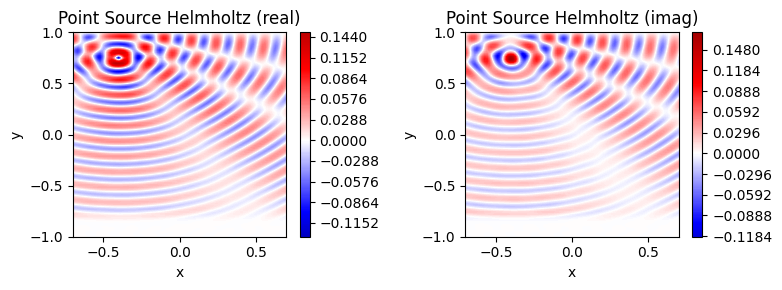

In [11]:
model_pred(model, 0.7, 1, bar_max=0.2)

In [12]:
import joblib
joblib.dump(model.state_dict(), 'model_batches.joblib')

['model_batches.joblib']

In [13]:
loss_min

0.11461171507835388

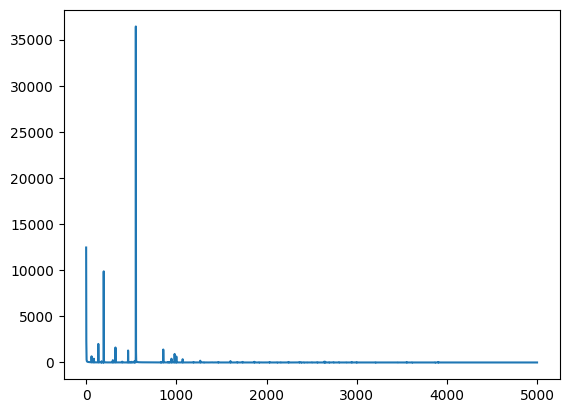

In [14]:
i = 0
loss_list = []
for loss in l_lst:
    loss_list.append(loss.to('cpu').detach().numpy())
np.save('loss.npy', loss_list)
plot_loss(l_lst)

In [15]:
def abs_field(model, Lx, Ly, N=100):
    x, y = torch.linspace(-Lx, Lx, N), torch.linspace(-Ly, Ly, N)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    model = model.to('cpu')
    inputs = torch.cat([x, y], dim=-1)
    p_real = model(inputs)[:, 0].detach().numpy()
    p_imag = model(inputs)[:, 1].detach().numpy()
    p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)
    p = p_real ** 2 + p_imag ** 2

    plt.figure(figsize=(4, 3))
    p_max = np.max(np.abs(p))
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (real)')
    plt.xlabel('x')
    plt.ylabel('y')

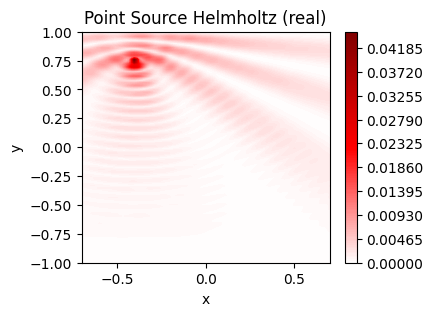

In [16]:
abs_field(model, 0.7, Ly)

Error(Real) -0.16152872145175934, Error(Imag) -1.2193573713302612


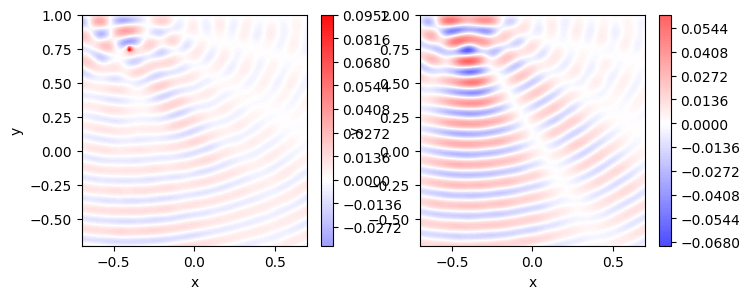

In [17]:
x, y = torch.linspace(-0.7, 0.7, N), torch.linspace(-0.7, 1, N)
x, y = torch.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
model = model.to('cpu')
inputs = torch.cat([x, y], dim=-1)
p_real = model(inputs)[:, 0].detach().numpy()
p_imag = model(inputs)[:, 1].detach().numpy()
p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)

x, y = x.numpy(), y.numpy()
hankel = scipy.special.hankel2(0, k * np.sqrt((x+0.4) ** 2 + (y-0.75) ** 2) + 1e-6) -\
    scipy.special.hankel2(0, k * np.sqrt((x+0.4) ** 2 + (y-1.25) ** 2) + 1e-6)
p_ref = 0.25j * hankel
p_ref_real, p_ref_imag = p_ref.real.reshape(N, N), p_ref.imag.reshape(N, N)

error_real = p_real - p_ref_real
error_imag = p_imag - p_ref_imag

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_real, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
print(f"Error(Real) {error_real.mean() / p_ref_real.mean()}, Error(Imag) {error_imag.mean() / p_ref_imag.mean()}")